In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import meteva.base as meb
import meteva.method as mem
import meteva.product as mpd
import numpy as np
import datetime
import copy
import matplotlib.pyplot as plt
import pandas as pd

本模块的函数族旨在提供各类数值型检验指标的分组统计方法。在浏览本模块函数说明之前可先参阅函数设计的[关键技术思想](https://www.showdoc.cc/meteva?page_id=4072178802924517)。本模块包含数值型检验指标的计算方法，为对其进行介绍，以下先对测试数据进行一个简单的介绍。

### 测试数据集：  
 **观测数据** ： 2019年全年2m温度观测数据，时间间隔3小时（1月1日02时），每个时刻包含6个站点（54398，54410，54416，54419，54499，54412）  
   
 **预报数据** ：  
    **ECMWF：** 2019年全年2m温度温度预报数据（少部分缺失），起报时刻北京时间08和20时，预报时效0-72小时内逐3小时间隔，网格范围115 - 118° E，39 - 42°N，格距 0.5°  
   
    **GRAPES_GFS：** 2019年全年2m温度温度预报数据（少部分缺失），起报时刻北京时间08和20时，预报时效0-72小时内逐3小时间隔，网格范围115 - 118° E，39 - 42°N，格距 0.5°  


########################################################
#以下先通过打印和图片的方式简单预览一下部分数据内容

In [2]:
#设置数据路径的通配格式
dir_ob = r"H:\test_data\input\mpd\ob\temp_2m\BTYYMMDDHH.000"
dir_ec = r"H:\test_data\input\mpd\ec\temp_2m\YYMMDD\BTYYMMDDHH.TTT"
dir_grapes = r"H:\test_data\input\mpd\grapes\temp_2m\YYMMDD\BTYYMMDDHH.TTT"

In [3]:
time0 = datetime.datetime(2019,7,1,20,0)   
dh = 12
path = meb.get_path(dir_ob,time0)
sta_ob= meb.read_stadata_from_micaps3(path)   #读取一个时刻的观测数据示例，并打印显示
print(sta_ob)

   level                time  dtime     id    lon   lat      data0
0      0 2019-07-01 20:00:00      0  54398  116.6  40.1  31.400000
1      0 2019-07-01 20:00:00      0  54410  116.1  40.6  20.400000
2      0 2019-07-01 20:00:00      0  54416  116.9  40.4  29.500000
3      0 2019-07-01 20:00:00      0  54419  116.6  40.4  28.500000
4      0 2019-07-01 20:00:00      0  54499  116.2  40.2  31.200001
5      0 2019-07-01 20:00:00      0  54412  116.6  40.7  27.900000


In [4]:
path = meb.get_path(dir_ec,time0,dh)
grd_ec = meb.read_griddata_from_micaps4(path)  #读取一个ec预报数据场示例
meb.set_griddata_coords(grd_ec,name = "t2m",gtime = [time0],dtime_list = [dh],member_list = ["ecmwf"])
print(grd_ec)                                  #打印显示

<xarray.DataArray 't2m' (member: 1, level: 1, time: 1, dtime: 1, lat: 7, lon: 7)>
array([[[[[[25.2, 26.9, 26.2, 27. , 26.3, 26.2, 25.3],
           [21.1, 23.9, 26.4, 25.9, 25.8, 25. , 25.5],
           [19.7, 19.7, 21.6, 25.6, 25.7, 24.6, 24.5],
           [20.1, 20.7, 20.9, 19.1, 22.4, 19.1, 19.7],
           [18.8, 15.4, 17.6, 16.6, 19.4, 18.7, 19.1],
           [16.4, 16.3, 15.1, 15.8, 16.1, 17. , 16.4],
           [16.1, 15.7, 15.7, 16.2, 14.9, 16.2, 16.1]]]]]])
Coordinates:
  * member   (member) <U5 'ecmwf'
  * level    (level) float64 -2.147e+09
  * time     (time) datetime64[ns] 2019-07-01T20:00:00
  * dtime    (dtime) int32 12
  * lat      (lat) float64 39.0 39.5 40.0 40.5 41.0 41.5 42.0
  * lon      (lon) float64 115.0 115.5 116.0 116.5 117.0 117.5 118.0
Attributes:
    dtime_type:  hour


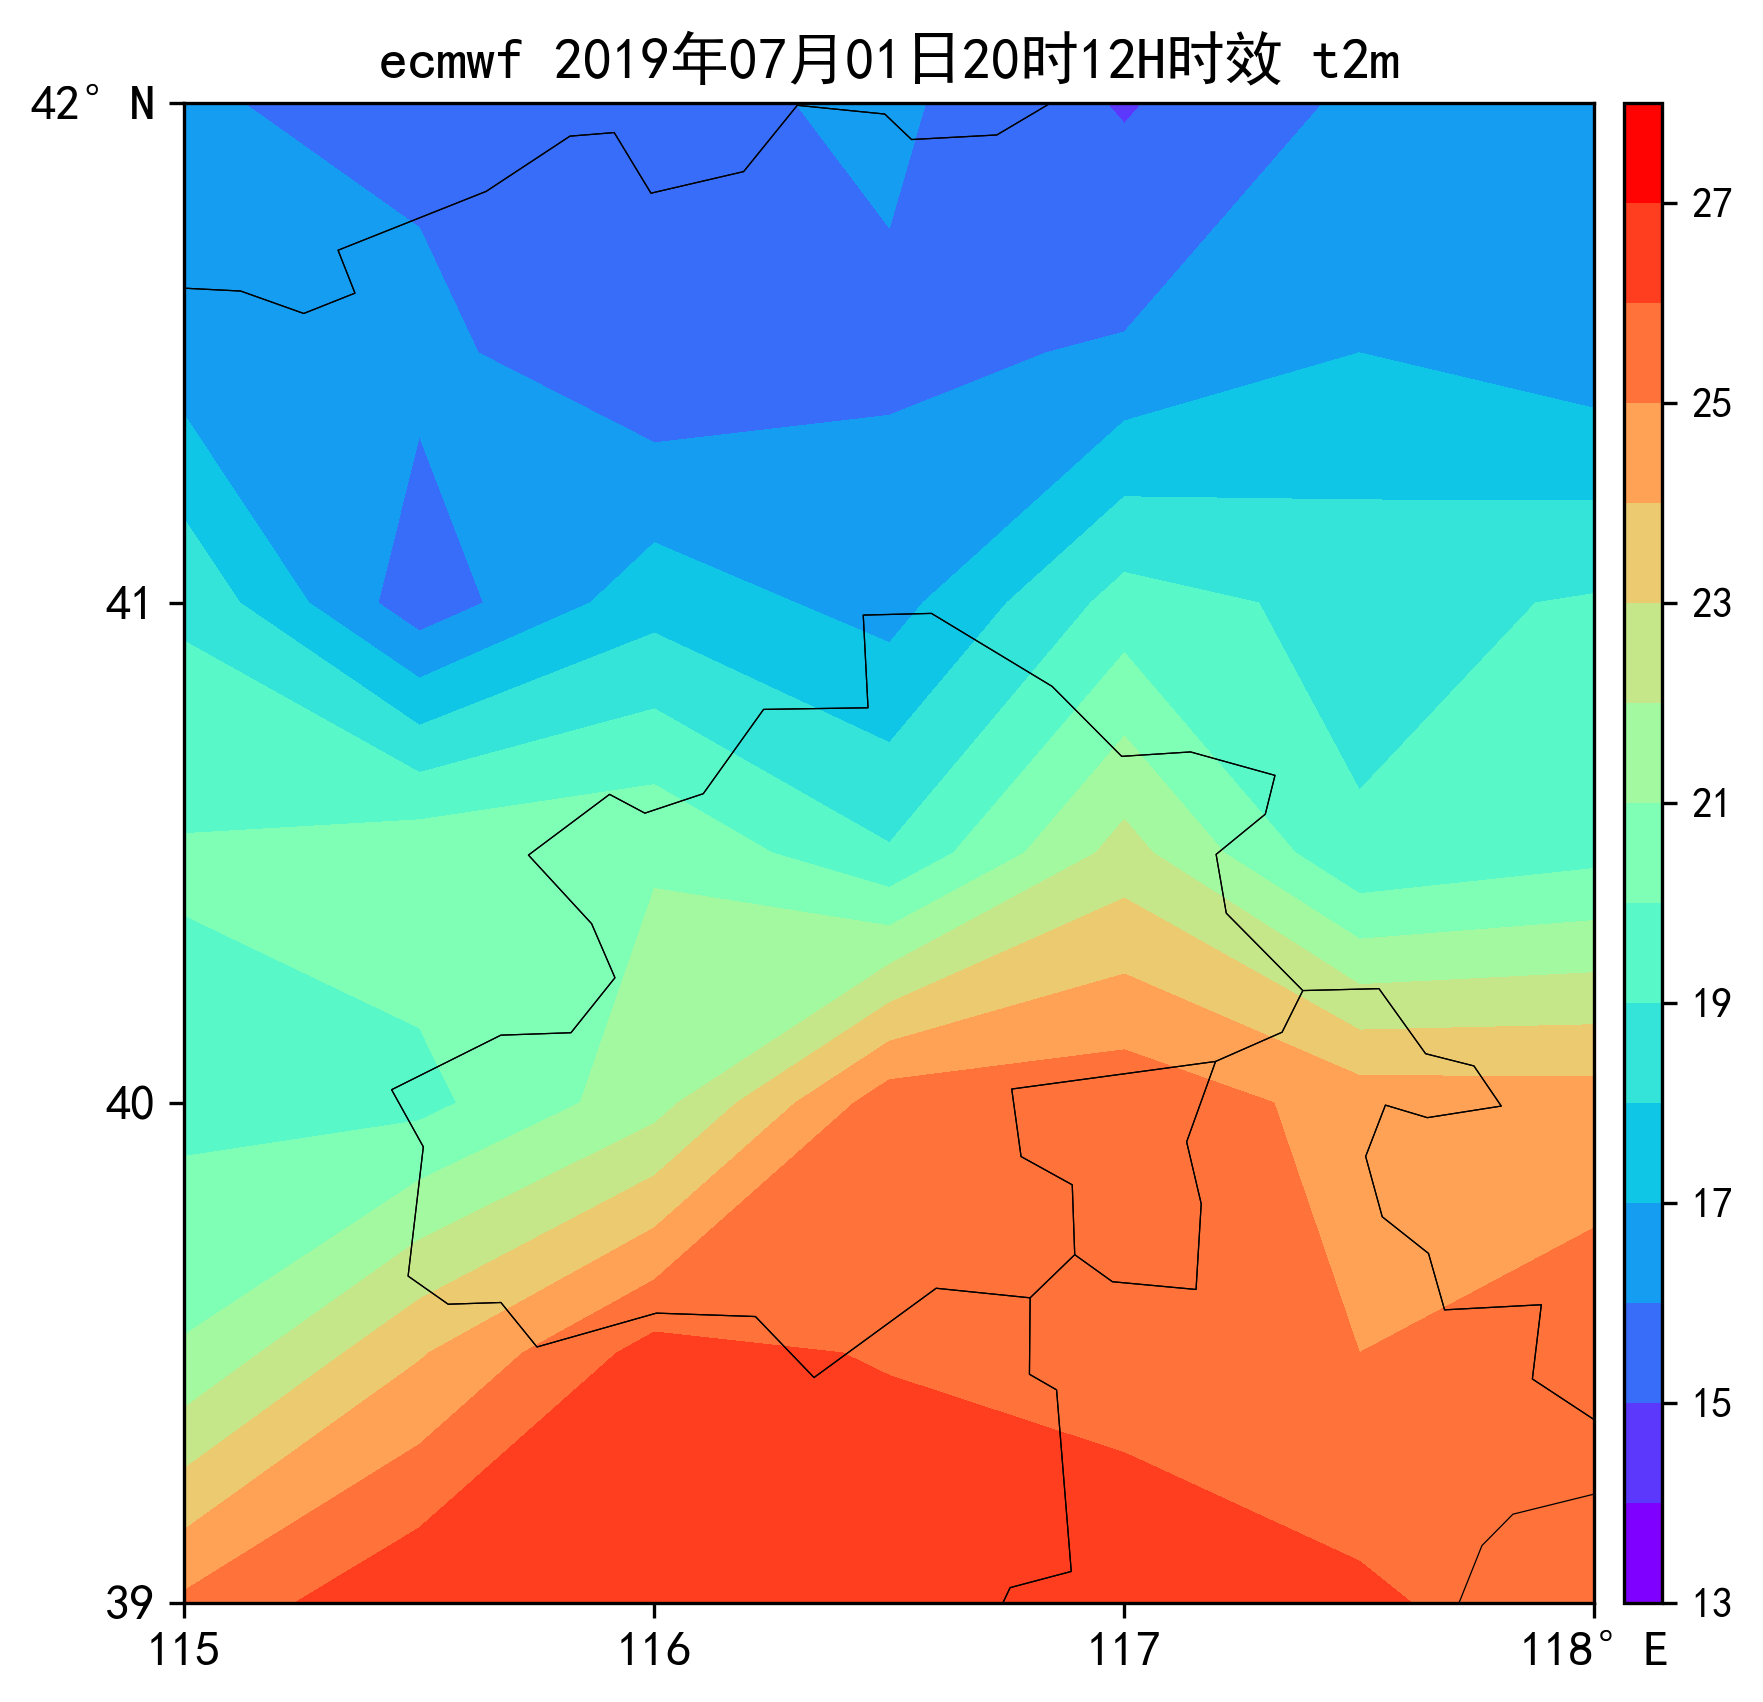

In [5]:
meb.plot_tools.contourf_2d_grid(grd_ec)   #以图片形式显示

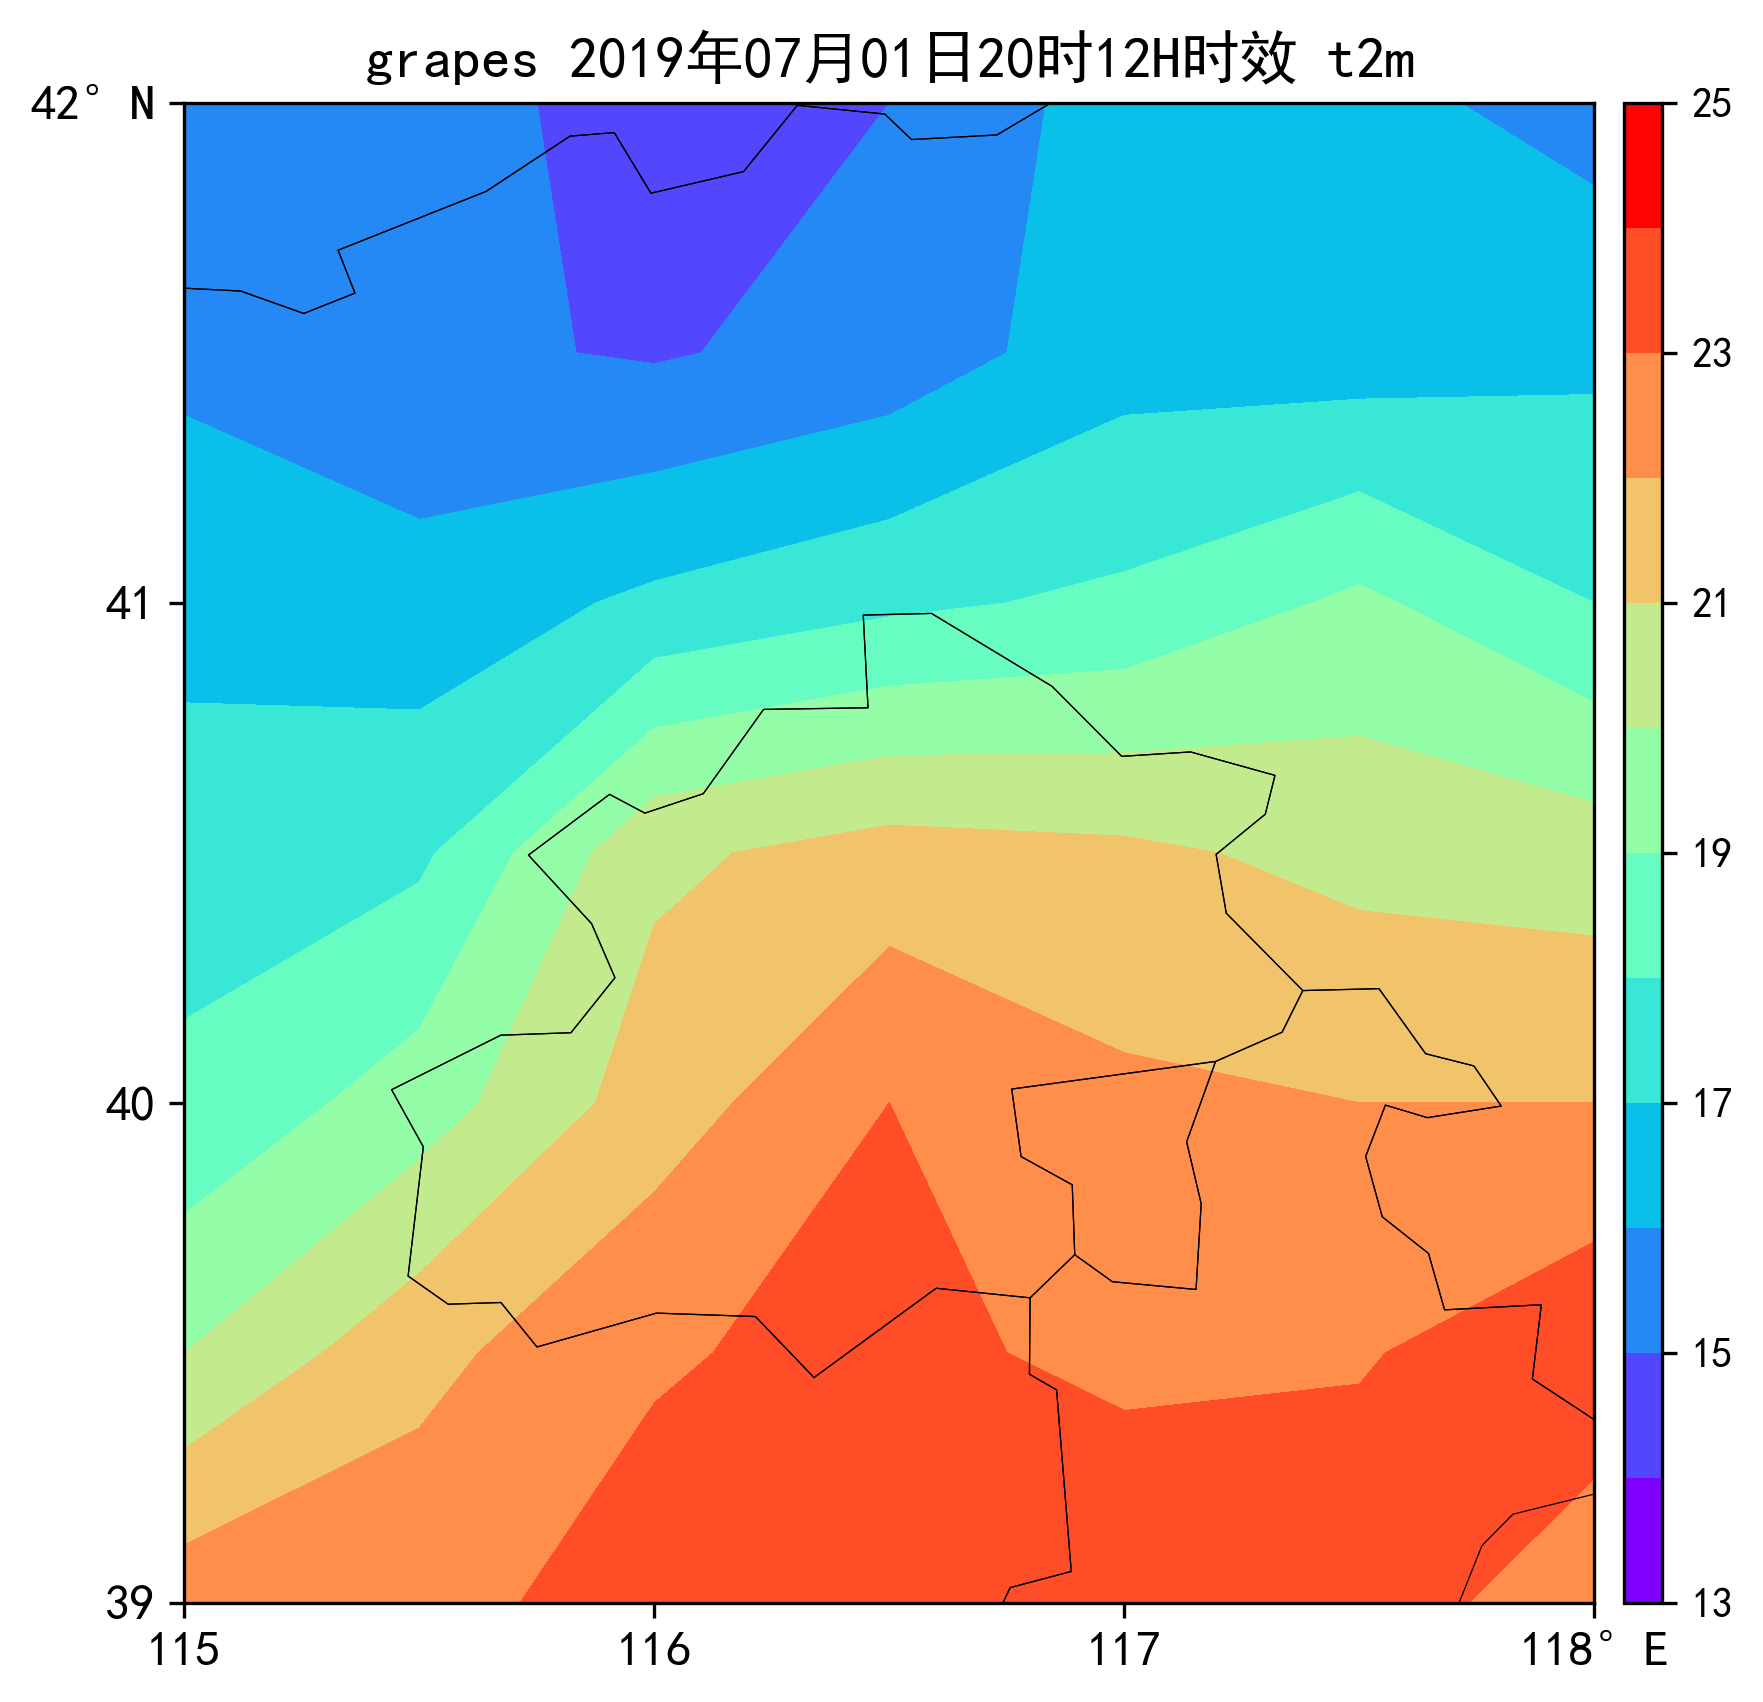

In [6]:
path = meb.get_path(dir_grapes,time0,dh)
grd_grapes = meb.read_griddata_from_micaps4(path)
meb.set_griddata_coords(grd_grapes,name = "t2m",gtime = [time0],dtime_list = [dh],member_list = ["grapes"])
meb.plot_tools.contourf_2d_grid(grd_grapes)     #以图片形式显示一个grapes预报场

#以上先通过打印和图片的方式简单预览了部分数据内容
########################################################

In [7]:
###################以下开始为数据收集部分的程序

#设置关注的起始时段
time_start = datetime.datetime(2019,1,1,8,0)   
time_end = datetime.datetime(2020,1,1,8,0)
#读取站点列表，并将站点内容为缺省值，当其作为读取站点数据的参数时，如果站点文件中某个站号不存在时,返回结果中该站点保持为缺省值
station = meb.read_stadata_from_micaps3(r"H:\test_data\input\mpd\ob\temp_2m\BT19010102.000")
station.iloc[:,-1] = meb.IV 


##读取收集观测数据
dir_ob = r"H:\test_data\input\mpd\ob\temp_2m\BTYYMMDDHH.000"
sta_list = []
time0 = time_start
while time0 < time_end:
    path = meb.get_path(dir_ob,time0)
    sta = meb.read_stadata_from_micaps3(path,station = station,time = time0,dtime = 0,level = 0,data_name = "ob",show = True)
    sta_list.append(sta)
    time0 += datetime.timedelta(hours = 3)
ob_sta_all = pd.concat(sta_list,axis = 0)  #数据拼接
    

#读取收集ec预报数据
dir_ec = r"H:\test_data\input\mpd\ec\temp_2m\YYMMDD\BTYYMMDDHH.TTT"
sta_list =[]
time0 = time_start
while time0 <= time_end:
    for dh in range(0,73,3):
        path = meb.get_path(dir_ec,time0,dh)
        grd = meb.read_griddata_from_micaps4(path,show = False)
        if grd is not None:
            sta = meb.interp_gs_linear(grd,station)
            meb.set_stadata_coords(sta,time = time0,dtime = dh,level = 0)
            meb.set_stadata_names(sta,["ecmwf"])
            sta_list.append(sta)
    time0 += datetime.timedelta(hours = 132)  #此处跳着读是为了减少测试用时
ec_sta_all = pd.concat(sta_list,axis = 0)  #数据拼接
            
#读取收集grapes预报数据
dir_grapes = r"H:\test_data\input\mpd\grapes\temp_2m\YYMMDD\BTYYMMDDHH.TTT"
sta_list =[]
time0 = time_start
while time0 <= time_end:
    for dh in range(0,73,3):
        path = meb.get_path(dir_grapes,time0,dh)
        grd = meb.read_griddata_from_micaps4(path,show = False)
        if grd is not None:
            sta = meb.interp_gs_linear(grd,station)
            meb.set_stadata_coords(sta,time = time0,dtime = dh,level = 0)
            meb.set_stadata_names(sta,["grapes"])
            sta_list.append(sta)  
    time0 += datetime.timedelta(hours = 132)
grapes_sta_all = pd.concat(sta_list,axis = 0)  #数据拼接
    
#数据匹配合并
sta_all = meb.combine_on_obTime_id(ob_sta_all,[ec_sta_all,grapes_sta_all])
sta_all = meb.sele_by_para(sta_all,drop_IV = True)  #删除包含缺省值的样本

###################以上为数据收集部分的程序

success read from H:\test_data\input\mpd\ob\temp_2m\BT19010108.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19010111.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19010114.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19010117.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19010120.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19010123.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19010202.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19010205.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19010208.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19010211.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19010214.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19010217.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19010220.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19010223.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19010302

success read from H:\test_data\input\mpd\ob\temp_2m\BT19011802.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19011805.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19011808.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19011811.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19011814.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19011817.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19011820.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19011823.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19011902.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19011905.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19011908.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19011911.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19011914.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19011917.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19011920

success read from H:\test_data\input\mpd\ob\temp_2m\BT19020217.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19020220.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19020223.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19020302.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19020305.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19020308.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19020311.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19020314.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19020317.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19020320.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19020323.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19020402.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19020405.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19020408.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19020411

success read from H:\test_data\input\mpd\ob\temp_2m\BT19021808.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19021811.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19021814.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19021817.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19021820.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19021823.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19021902.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19021905.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19021908.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19021911.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19021914.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19021917.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19021920.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19021923.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19022002

success read from H:\test_data\input\mpd\ob\temp_2m\BT19030523.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19030602.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19030605.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19030608.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19030611.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19030614.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19030617.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19030620.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19030623.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19030702.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19030705.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19030708.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19030711.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19030714.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19030717

success read from H:\test_data\input\mpd\ob\temp_2m\BT19032120.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19032123.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19032202.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19032205.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19032208.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19032211.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19032214.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19032217.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19032220.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19032223.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19032302.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19032305.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19032308.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19032311.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19032314

success read from H:\test_data\input\mpd\ob\temp_2m\BT19040623.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19040702.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19040705.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19040708.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19040711.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19040714.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19040717.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19040720.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19040723.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19040802.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19040805.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19040808.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19040811.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19040814.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19040817

success read from H:\test_data\input\mpd\ob\temp_2m\BT19042308.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19042311.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19042314.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19042317.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19042320.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19042323.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19042402.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19042405.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19042408.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19042411.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19042414.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19042417.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19042420.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19042423.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19042502

success read from H:\test_data\input\mpd\ob\temp_2m\BT19050920.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19050923.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19051002.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19051005.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19051008.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19051011.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19051014.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19051017.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19051020.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19051023.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19051102.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19051105.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19051108.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19051111.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19051114

success read from H:\test_data\input\mpd\ob\temp_2m\BT19052514.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19052517.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19052520.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19052523.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19052602.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19052605.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19052608.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19052611.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19052614.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19052617.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19052620.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19052623.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19052702.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19052705.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19052708

success read from H:\test_data\input\mpd\ob\temp_2m\BT19061102.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19061105.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19061108.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19061111.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19061114.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19061117.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19061120.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19061123.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19061202.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19061205.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19061208.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19061211.000
H:\test_data\input\mpd\ob\temp_2m\BT19061214.000文件不存在
H:\test_data\input\mpd\ob\temp_2m\BT19061217.000文件不存在
success read from H:\test_data\input\mpd\ob\temp_2m\BT19061220.000
success read from H:\

success read from H:\test_data\input\mpd\ob\temp_2m\BT19062711.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19062714.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19062717.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19062720.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19062723.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19062802.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19062805.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19062808.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19062811.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19062814.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19062817.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19062820.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19062823.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19062902.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19062905

success read from H:\test_data\input\mpd\ob\temp_2m\BT19071311.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19071314.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19071317.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19071320.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19071323.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19071402.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19071405.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19071408.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19071411.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19071414.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19071417.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19071420.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19071423.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19071502.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19071505

success read from H:\test_data\input\mpd\ob\temp_2m\BT19072920.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19072923.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19073002.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19073005.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19073008.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19073011.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19073014.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19073017.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19073020.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19073023.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19073102.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19073105.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19073108.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19073111.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19073114

success read from H:\test_data\input\mpd\ob\temp_2m\BT19081423.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19081502.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19081505.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19081508.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19081511.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19081514.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19081517.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19081520.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19081523.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19081602.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19081605.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19081608.000
H:\test_data\input\mpd\ob\temp_2m\BT19081611.000文件不存在
success read from H:\test_data\input\mpd\ob\temp_2m\BT19081614.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19081617.000
success 

success read from H:\test_data\input\mpd\ob\temp_2m\BT19083017.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19083020.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19083023.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19083102.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19083105.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19083108.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19083111.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19083114.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19083117.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19083120.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19083123.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19090102.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19090105.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19090108.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19090111

success read from H:\test_data\input\mpd\ob\temp_2m\BT19091617.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19091620.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19091623.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19091702.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19091705.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19091708.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19091711.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19091714.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19091717.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19091720.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19091723.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19091802.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19091805.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19091808.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19091811

success read from H:\test_data\input\mpd\ob\temp_2m\BT19100311.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19100314.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19100317.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19100320.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19100323.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19100402.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19100405.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19100408.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19100411.000
H:\test_data\input\mpd\ob\temp_2m\BT19100414.000文件不存在
success read from H:\test_data\input\mpd\ob\temp_2m\BT19100417.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19100420.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19100423.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19100502.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19100505.000
success 

success read from H:\test_data\input\mpd\ob\temp_2m\BT19102014.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19102017.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19102020.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19102023.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19102102.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19102105.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19102108.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19102111.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19102114.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19102117.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19102120.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19102123.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19102202.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19102205.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19102208

success read from H:\test_data\input\mpd\ob\temp_2m\BT19110517.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19110520.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19110523.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19110602.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19110605.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19110608.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19110611.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19110614.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19110617.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19110620.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19110623.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19110702.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19110705.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19110708.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19110711

success read from H:\test_data\input\mpd\ob\temp_2m\BT19112108.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19112111.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19112114.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19112117.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19112120.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19112123.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19112202.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19112205.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19112208.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19112211.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19112214.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19112217.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19112220.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19112223.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19112302

success read from H:\test_data\input\mpd\ob\temp_2m\BT19120620.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19120623.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19120702.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19120705.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19120708.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19120711.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19120714.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19120717.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19120720.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19120723.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19120802.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19120805.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19120808.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19120811.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19120814

success read from H:\test_data\input\mpd\ob\temp_2m\BT19122214.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19122217.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19122220.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19122223.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19122302.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19122305.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19122308.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19122311.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19122314.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19122317.000
H:\test_data\input\mpd\ob\temp_2m\BT19122320.000文件不存在
success read from H:\test_data\input\mpd\ob\temp_2m\BT19122323.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19122402.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19122405.000
success read from H:\test_data\input\mpd\ob\temp_2m\BT19122408.000
success 

H:\test_data\input\mpd\grapes\temp_2m\190117\BT19011720.000 is not exist
H:\test_data\input\mpd\grapes\temp_2m\190117\BT19011720.003 is not exist
H:\test_data\input\mpd\grapes\temp_2m\190117\BT19011720.006 is not exist
H:\test_data\input\mpd\grapes\temp_2m\190117\BT19011720.009 is not exist
H:\test_data\input\mpd\grapes\temp_2m\190117\BT19011720.012 is not exist
H:\test_data\input\mpd\grapes\temp_2m\190117\BT19011720.015 is not exist
H:\test_data\input\mpd\grapes\temp_2m\190117\BT19011720.018 is not exist
H:\test_data\input\mpd\grapes\temp_2m\190117\BT19011720.021 is not exist
H:\test_data\input\mpd\grapes\temp_2m\190117\BT19011720.024 is not exist
H:\test_data\input\mpd\grapes\temp_2m\190117\BT19011720.027 is not exist
H:\test_data\input\mpd\grapes\temp_2m\190117\BT19011720.030 is not exist
H:\test_data\input\mpd\grapes\temp_2m\190117\BT19011720.033 is not exist
H:\test_data\input\mpd\grapes\temp_2m\190117\BT19011720.036 is not exist
H:\test_data\input\mpd\grapes\temp_2m\190117\BT1901

H:\test_data\input\mpd\grapes\temp_2m\190421\BT19042108.000 is not exist
H:\test_data\input\mpd\grapes\temp_2m\190421\BT19042108.003 is not exist
H:\test_data\input\mpd\grapes\temp_2m\190421\BT19042108.006 is not exist
H:\test_data\input\mpd\grapes\temp_2m\190421\BT19042108.009 is not exist
H:\test_data\input\mpd\grapes\temp_2m\190421\BT19042108.012 is not exist
H:\test_data\input\mpd\grapes\temp_2m\190421\BT19042108.015 is not exist
H:\test_data\input\mpd\grapes\temp_2m\190421\BT19042108.018 is not exist
H:\test_data\input\mpd\grapes\temp_2m\190421\BT19042108.021 is not exist
H:\test_data\input\mpd\grapes\temp_2m\190421\BT19042108.024 is not exist
H:\test_data\input\mpd\grapes\temp_2m\190421\BT19042108.027 is not exist
H:\test_data\input\mpd\grapes\temp_2m\190421\BT19042108.030 is not exist
H:\test_data\input\mpd\grapes\temp_2m\190421\BT19042108.033 is not exist
H:\test_data\input\mpd\grapes\temp_2m\190421\BT19042108.036 is not exist
H:\test_data\input\mpd\grapes\temp_2m\190421\BT1904

在以上的代码中，通过调用base中的函数完成了对观测数据和模式预报资料的收集，数据的对齐，缺省数据的删除等操作，这些代码均具有较好的可复用性，用户也可以根据需要将上述代码经过一定修改后进一步封装成一个函数。  

**<font face="黑体" color=blue size = 5>数值型检验指标计算 </font>**     
**score(sta_ob_and_fos0,method,s = None,g = None,gll = None,group_name_list = None,plot = None,save_path = None,show = False,dpi = 300,excel_path = None,\*\* kwargs)**  
根据输入的站点数据和检验方法，选择部分数据，将选择的数据进行进行分组检验，计算各种数值型检验指标（不包括检验中间量）


|参数|说明|  
|:--|:--|  
|**<font face="黑体" color=blue size = 5>sta_ob_and_fos </font>**|实况和预报合并对齐后的数据，形式为站点数据格式如上述例子中的sta_all|   
|**<font face="黑体" color=blue size = 5>method </font>**|method中的各类数值型检验指标的函数名称，例如在本页面中已经import meteva.method as mem ，则ts评分的函数名称可以写为mem.ts ，均方根误差计算函数的名称可以写为 mem.rmse。这些函数选项包括[连续型预报](https://www.showdoc.cc/nmc?page_id=2858658548509727)，[二分类预报](https://www.showdoc.cc/nmc?page_id=2860336958932349),[多分类预报](https://www.showdoc.cc/nmc?page_id=2859693269266585),[概率预报](https://www.showdoc.cc/nmc?page_id=3651805946039771),[集合预报](https://www.showdoc.cc/nmc?page_id=3629735872716279)等类别中的评分函数|   
|**s**| 用于选择数据样本的字典参数，具体的参数说明可参见meb.sele_by_dict中的[<font face="黑体" color=red size=5>s</font>](https://www.showdoc.cc/meteva?page_id=3975604785954540)参数  |   
|**g**|用于分组检验的参数，具体用法可参见meb.group中的[<font face="黑体" color=red size=5>g</font>](https://www.showdoc.cc/meteva?page_id=4071849185300418)参数|     
|**gll**| 用于分组检验的参数，具体用法可参见meb.group中的[<font face="黑体" color=red size=5>gll</font>](https://www.showdoc.cc/meteva?page_id=4071849185300418)参数|  
|**group_name_list**| 分组名称的列表|  
|**plot**|是否需要直接将检验结果绘制图片，该参数为None时不绘制，当参数为"bar"时绘制柱状图，当参数为"plot"时绘制线条图|   
|**save_path**|该参数不为None时将图片结果输出值save_path|  
|**show**|该参数不为None时在屏幕显示图片，如果生成了图片save_path又为None,则该参数会自动切换为True|  
|**dpi**|绘图的dpi参数，用法同matplotlib中dpi参数|  
|**excel_path**|该参数不为None时将数值结果输出至路径为excel_path的excel文件|  
|**kwargs| 检验方法 meteva.method 中的可选参数，具体用法参见下面的示例|   
|<font face="黑体" color=blue size=5>return</font>|返回一个元组，其包含2个元素，分别是包含数值检验指标的numpy数组和group_list_list,如果group_by不为None。检验指标数组的shape = （分组数目 ， 预报（模式）数目 ， 参数列表长度） 的数组经删除size= 1的维度后的结果。其中集合预报情况相对特殊，在sta_ob_and_fos中后面几列数据为不同集合成员的结果，而返回的评分则只返回集合预报整体的评分，而不区分各成员的评分，因此集合预报评分时预报（模式）数目相当于等于1.||  
  
**调用示例：**

In [8]:
sta_all = meb.sele_by_para(sta_all,value = [-100,100])  #选取合理取值范围的数据，即进行简单的阈值质控

In [9]:
result = mpd.score(sta_all,mem.me) 
print(result) #result[0]中包含2个模式的结果，由于没有分组所以 result[1] 里元素为None

(array([-1.1911513, -2.4201992], dtype=float32), None)


In [10]:
result = mpd.score(sta_all,mem.mae) 
print(result) #将检验指标切换为rmse

(array([2.6599662, 3.4411268], dtype=float32), None)


In [11]:
result= mpd.score(sta_all,mem.mae,s  = {"dtime":24})
print(result)   #通过s参数选择部分数据，在本例中选择了时效为24的数据进行检验

(array([2.5120938, 3.651695 ], dtype=float32), None)


In [12]:
result = mpd.score(sta_all,mem.mae,g= "hour")  #g = "hour"代表将预报按起报时间（日周期中的小时）进行分组
print(result)   #result[0]中包含2种起报时间 * 2个模式 的结果, result[1]中包含把数据分为两组的依据 ：即 hour = 8 和 hour = 20

(array([[2.5817587, 3.1089883],
       [2.7356095, 3.7623775]], dtype=float32), [8, 20])


In [13]:
result = mpd.score(sta_all,mem.mae,g= "hour",gll = [8,20,[8,20]])  
#gll代表将预报按指定方式分组，第一组是hour = 8,第二组是hour = 20,第三组是 前两种的并集  
print(result)   #result[0]中包含3组起报时间 * 2个模式 的结果, result[1]中包含把数据分为3组的依据

(array([[2.5817587, 3.1089883],
       [2.7356095, 3.7623775],
       [2.6599662, 3.4411268]], dtype=float32), [[8], [20], [8, 20]])


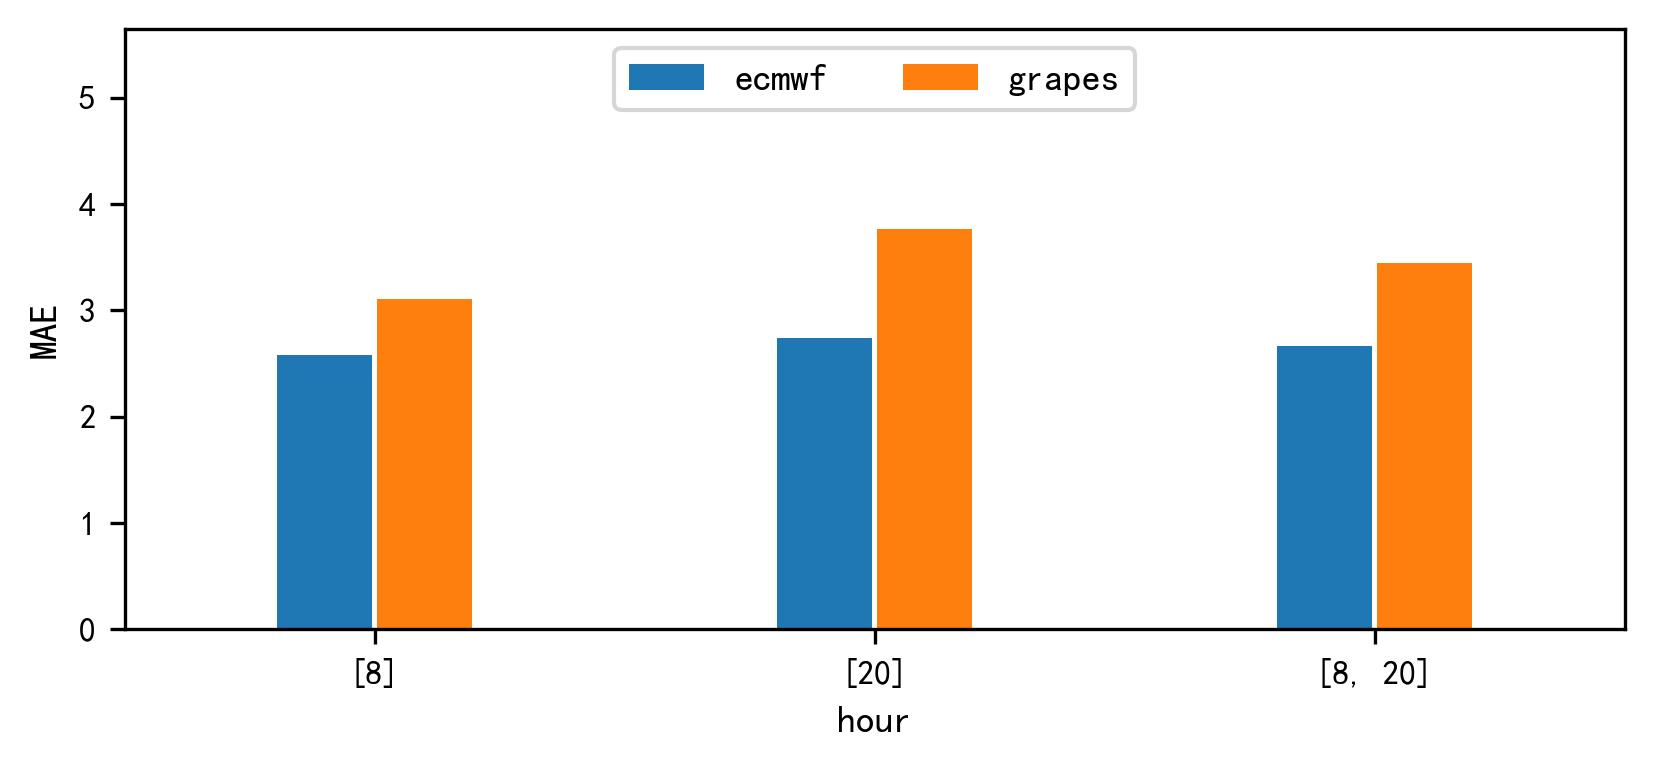

(array([[2.5817587, 3.1089883],
       [2.7356095, 3.7623775],
       [2.6599662, 3.4411268]], dtype=float32), [[8], [20], [8, 20]])


In [14]:
result = mpd.score(sta_all,mem.mae,g= "hour",gll = [8,20,[8,20]],plot = "bar") #plot = "bar"代表将结果同时以柱状图的形式输出
print(result)  

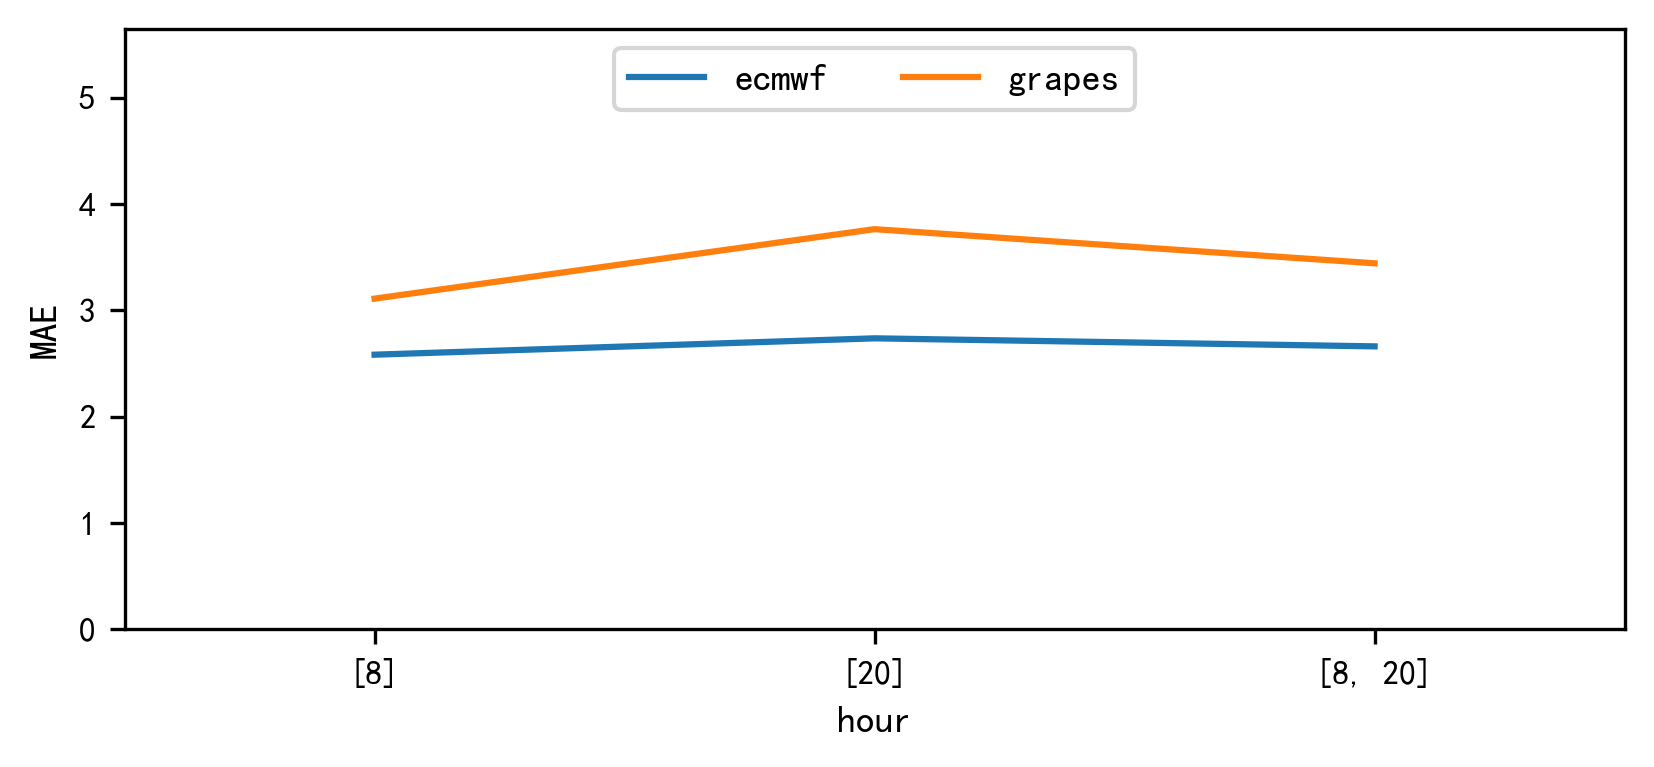

(array([[2.5817587, 3.1089883],
       [2.7356095, 3.7623775],
       [2.6599662, 3.4411268]], dtype=float32), [[8], [20], [8, 20]])


In [15]:
result = mpd.score(sta_all,mem.mae,g= "hour",gll = [8,20,[8,20]],plot = "line") #plot = "line"代表将结果同时以线条的形式输出
print(result)  

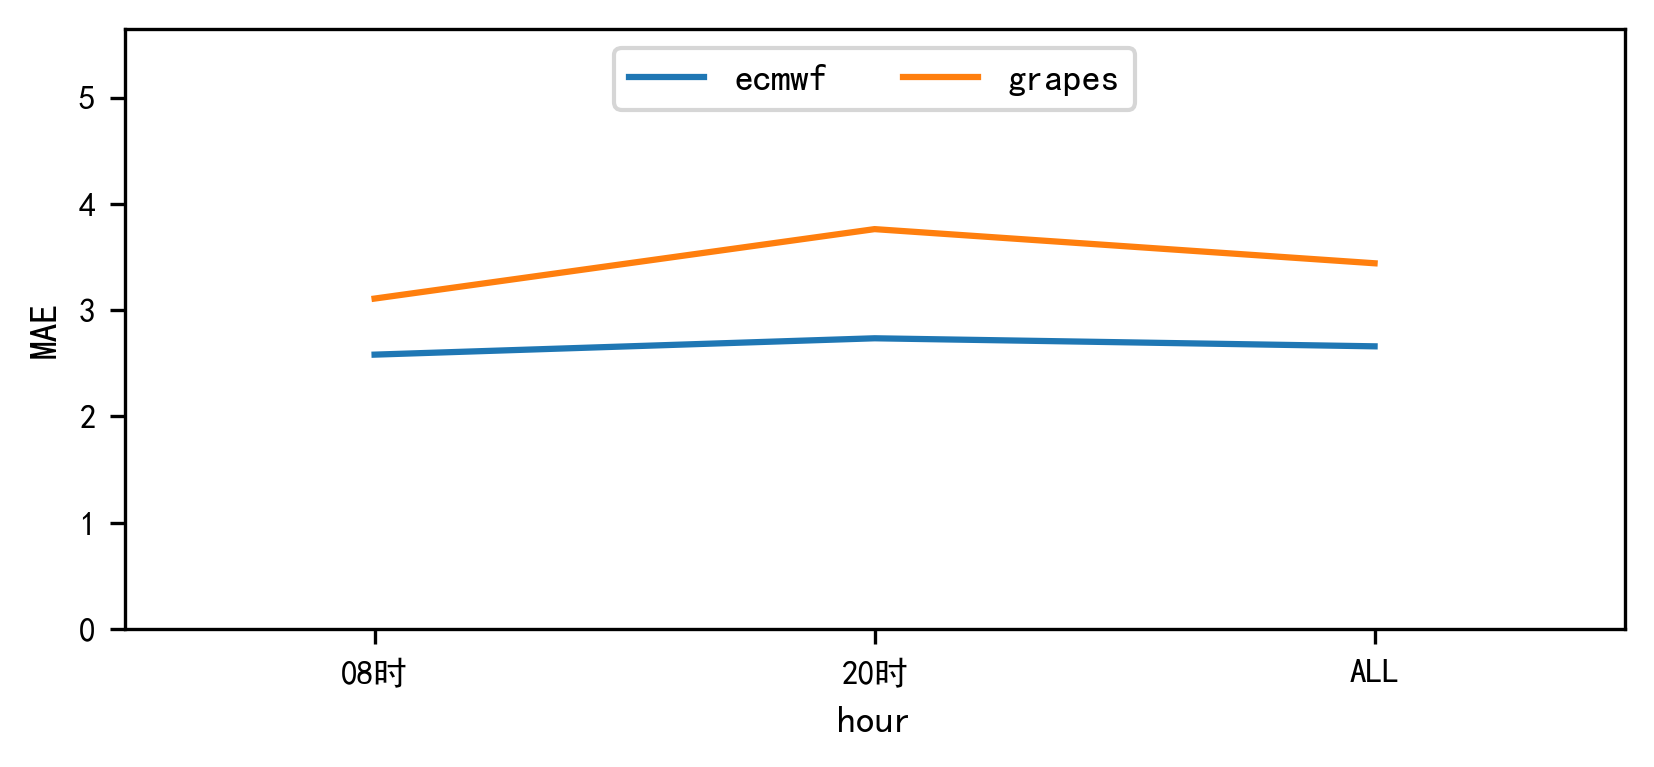

(array([[2.5817587, 3.1089883],
       [2.7356095, 3.7623775],
       [2.6599662, 3.4411268]], dtype=float32), [[8], [20], [8, 20]])


In [16]:
result = mpd.score(sta_all,mem.mae,g= "hour",gll = [8,20,[8,20]],group_name_list = ["08时","20时","ALL"],plot = "line") 
print(result)  #group_name_list 是给gll中每个元素取一个名字，否则系统会自动生成，在不生成图片或表格时并不起什么作用

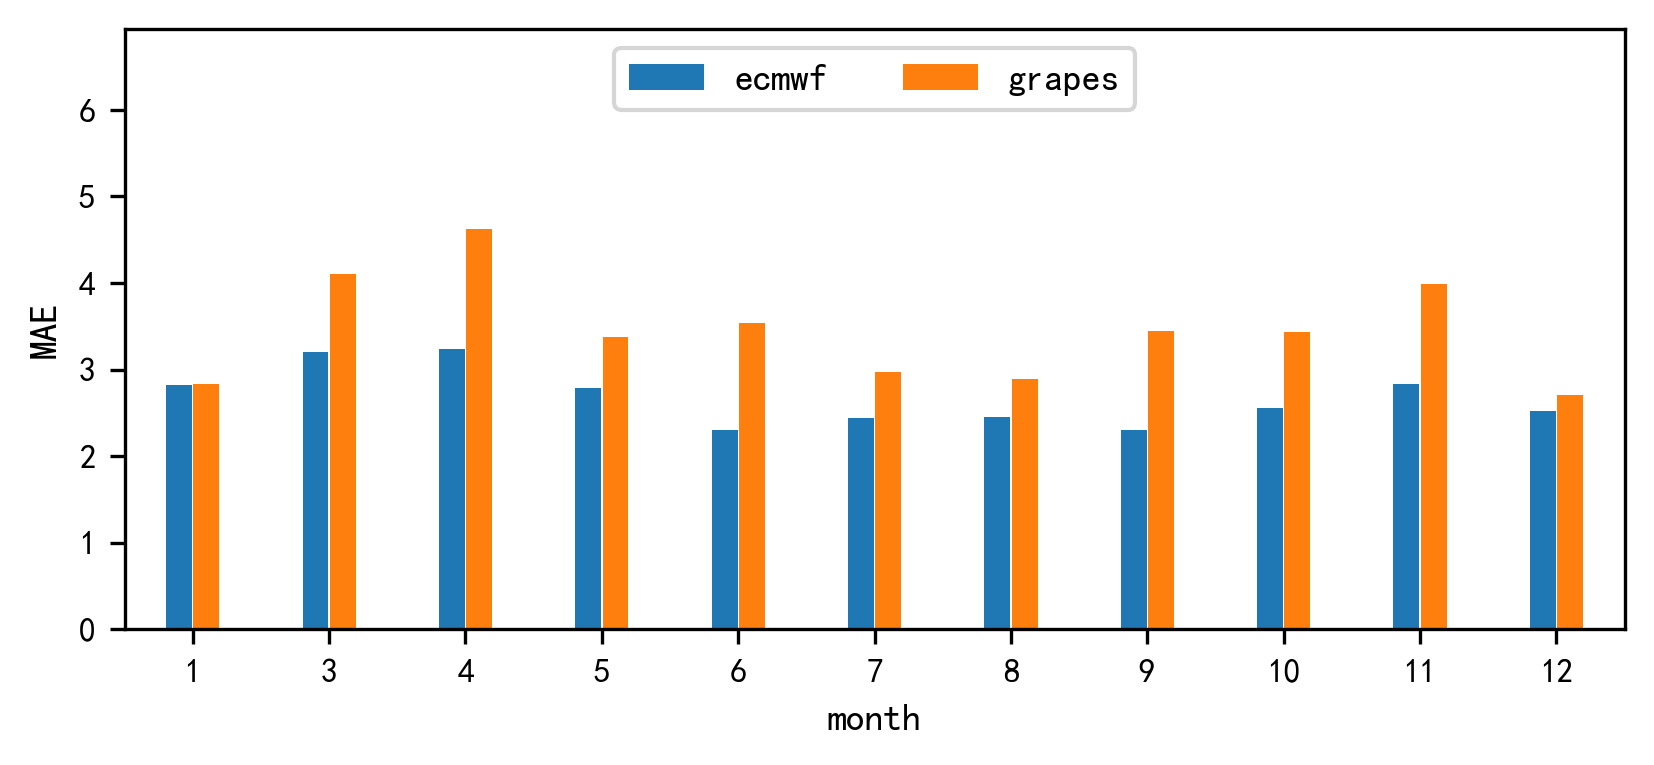

(array([[2.8249524, 2.8323264],
       [3.2048826, 4.1073327],
       [3.232286 , 4.6219287],
       [2.7828076, 3.3794649],
       [2.306571 , 3.54016  ],
       [2.444566 , 2.9754698],
       [2.4502914, 2.886426 ],
       [2.3026464, 3.446947 ],
       [2.5522623, 3.429648 ],
       [2.8287828, 3.990504 ],
       [2.518351 , 2.7032976]], dtype=float32), [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])


In [17]:
result = mpd.score(sta_all,mem.mae,g= "month",plot = "bar") #改变g的参数，就切换了分组对比的方式，在本例中是按月分组检验
print(result)  

In [18]:
result = mpd.score(sta_all,mem.mae,g= "month",plot = "bar",save_path = r"H:\test_data\output\mpd\program\s1.png") 
print(result)  #在本例中设置了save_path,检验结果将会保持到图片文件中，而不是在屏幕上显示  

检验结果已以图片形式保存至H:\test_data\output\mpd\program\s1.png
(array([[2.8249524, 2.8323264],
       [3.2048826, 4.1073327],
       [3.232286 , 4.6219287],
       [2.7828076, 3.3794649],
       [2.306571 , 3.54016  ],
       [2.444566 , 2.9754698],
       [2.4502914, 2.886426 ],
       [2.3026464, 3.446947 ],
       [2.5522623, 3.429648 ],
       [2.8287828, 3.990504 ],
       [2.518351 , 2.7032976]], dtype=float32), [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])


检验结果已以图片形式保存至H:\test_data\output\mpd\program\s1.png


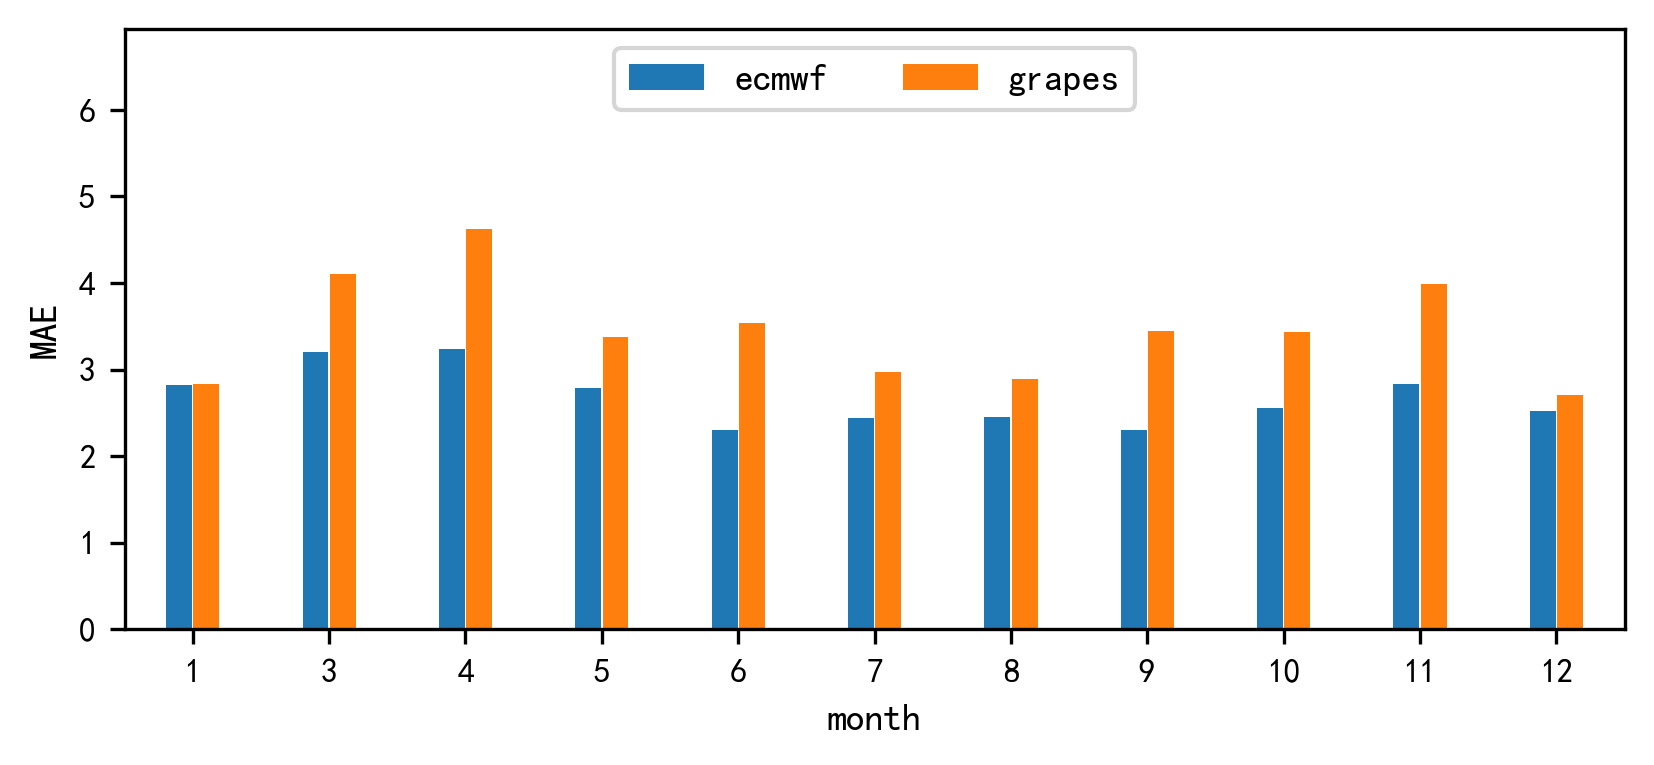

(array([[2.8249524, 2.8323264],
       [3.2048826, 4.1073327],
       [3.232286 , 4.6219287],
       [2.7828076, 3.3794649],
       [2.306571 , 3.54016  ],
       [2.444566 , 2.9754698],
       [2.4502914, 2.886426 ],
       [2.3026464, 3.446947 ],
       [2.5522623, 3.429648 ],
       [2.8287828, 3.990504 ],
       [2.518351 , 2.7032976]], dtype=float32), [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])


In [19]:
result = mpd.score(sta_all,mem.mae,g= "month",plot = "bar",save_path = r"H:\test_data\output\mpd\program\s1.png",show = True) 
print(result)  #如果既要输出到文件中，又要在屏幕上打印，需要设置参数show   

In [20]:
result = mpd.score(sta_all,mem.mae,g= "month",excel_path = r"H:\test_data\output\mpd\program\s1.xlsx") 
#通过设置excel_path参数可以将结果输出到表格文件中

列联表已以excel表格形式保存至H:\test_data\output\mpd\program\s1.xlsx


上述表格的形式如下：
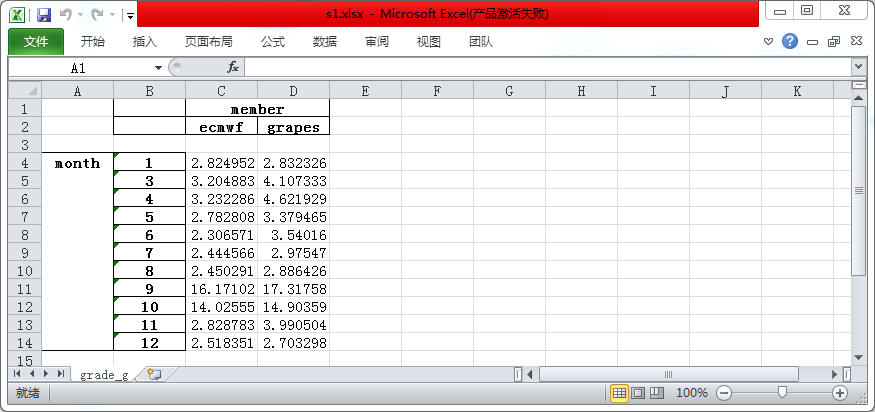

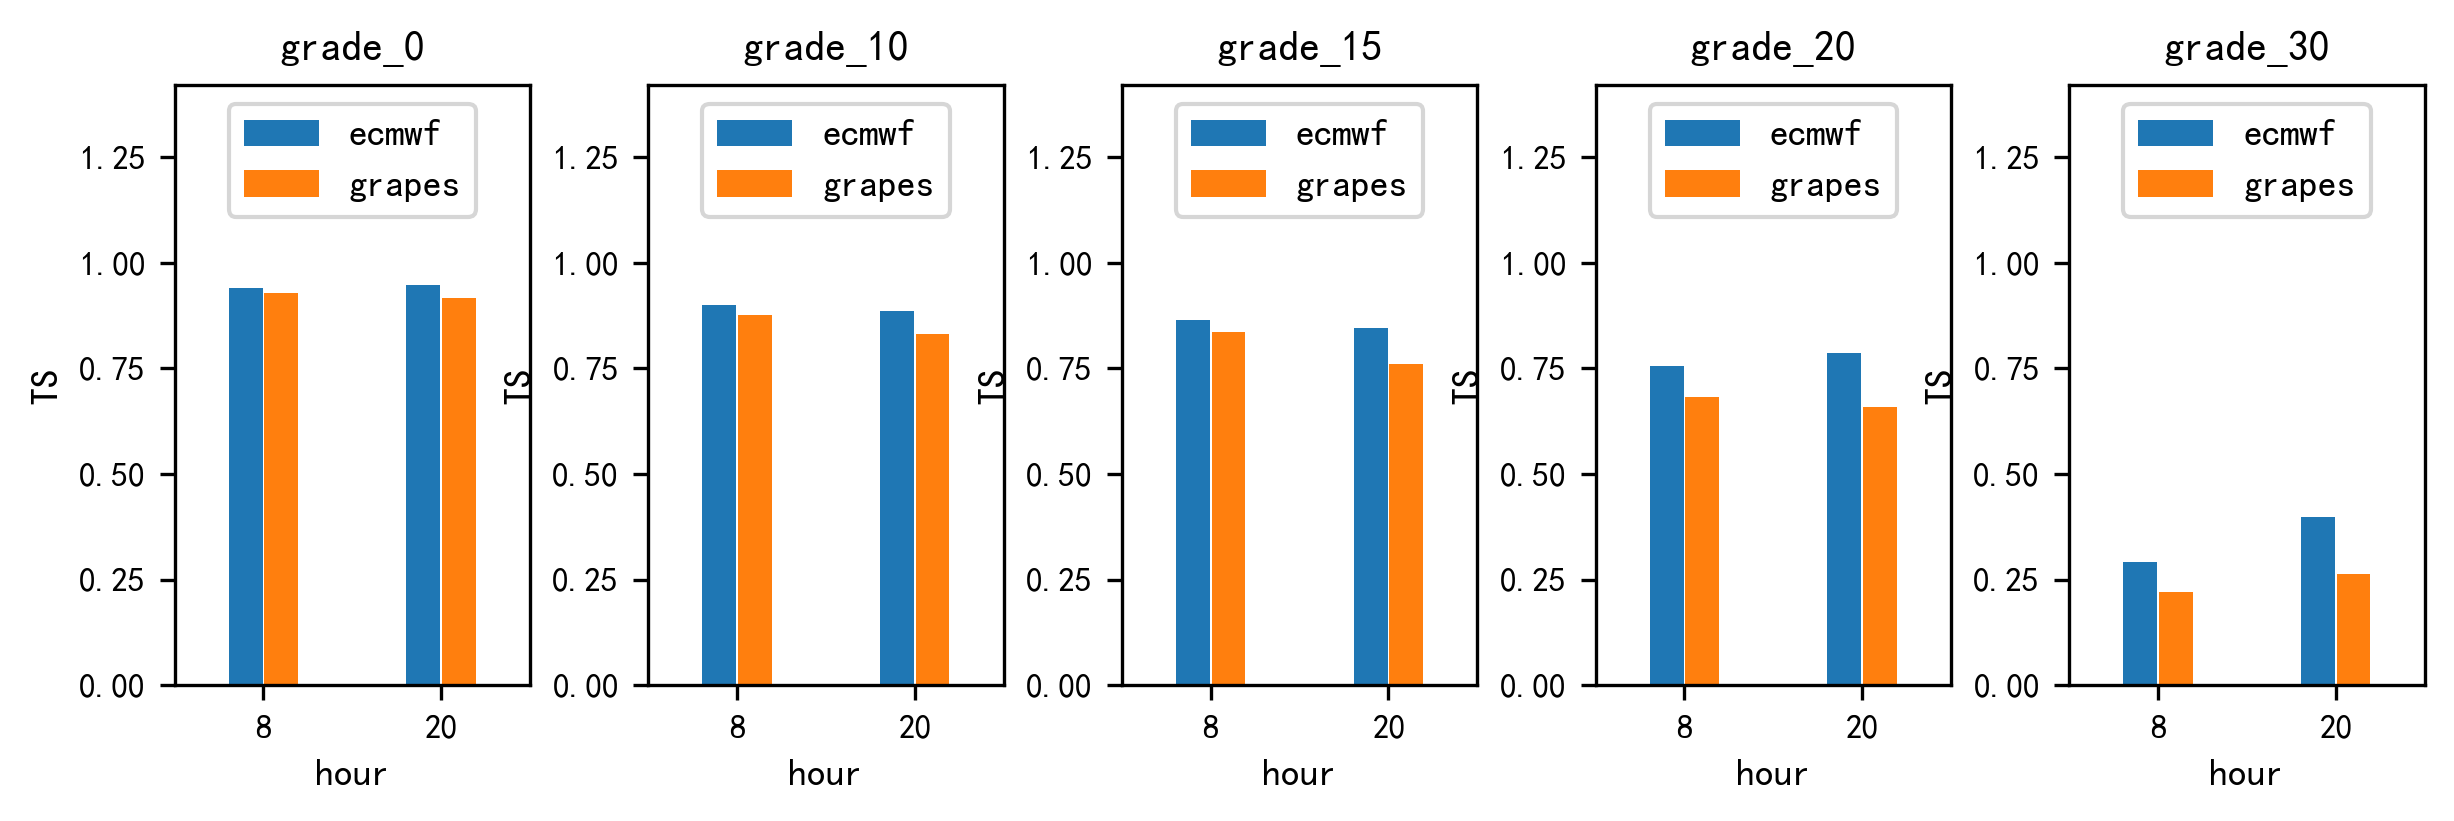

(array([[[0.9413643 , 0.89973108, 0.8646789 , 0.75480451, 0.29213483],
        [0.92840444, 0.8775589 , 0.83722015, 0.68144611, 0.22099448]],

       [[0.94731268, 0.88559614, 0.84479032, 0.78593653, 0.39747634],
        [0.91784476, 0.83257761, 0.76157205, 0.65872505, 0.26332288]]]), [8, 20])


In [21]:
result = mpd.score(sta_all,mem.ts,grade_list = [0,10,15,20,30],g = "hour",plot = "bar") 
#当mothod 参数为 mem.ts这类可以带等级的函数时，mpd。score就可以接受grade_list，因为mpd_score有个 **kwargs参数可以接受mem.ts的参数
print(result)  #reuslt[0]。shape = (2 ,2,5),(分组数，预报数，等级数)， result[1] 为分组方式

In [22]:
result = mpd.score(sta_all,mem.ts,grade_list = [0,10,15,20,30],g = "hour",excel_path = r"H:\test_data\output\mpd\program\s2.xlsx") 

列联表已以excel表格形式保存至H:\test_data\output\mpd\program\s2.xlsx


上述表格形式如下，其中不同等级的结果位于不同的sheet上
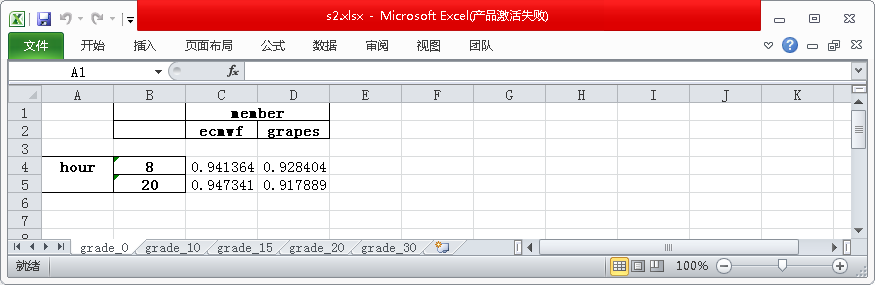

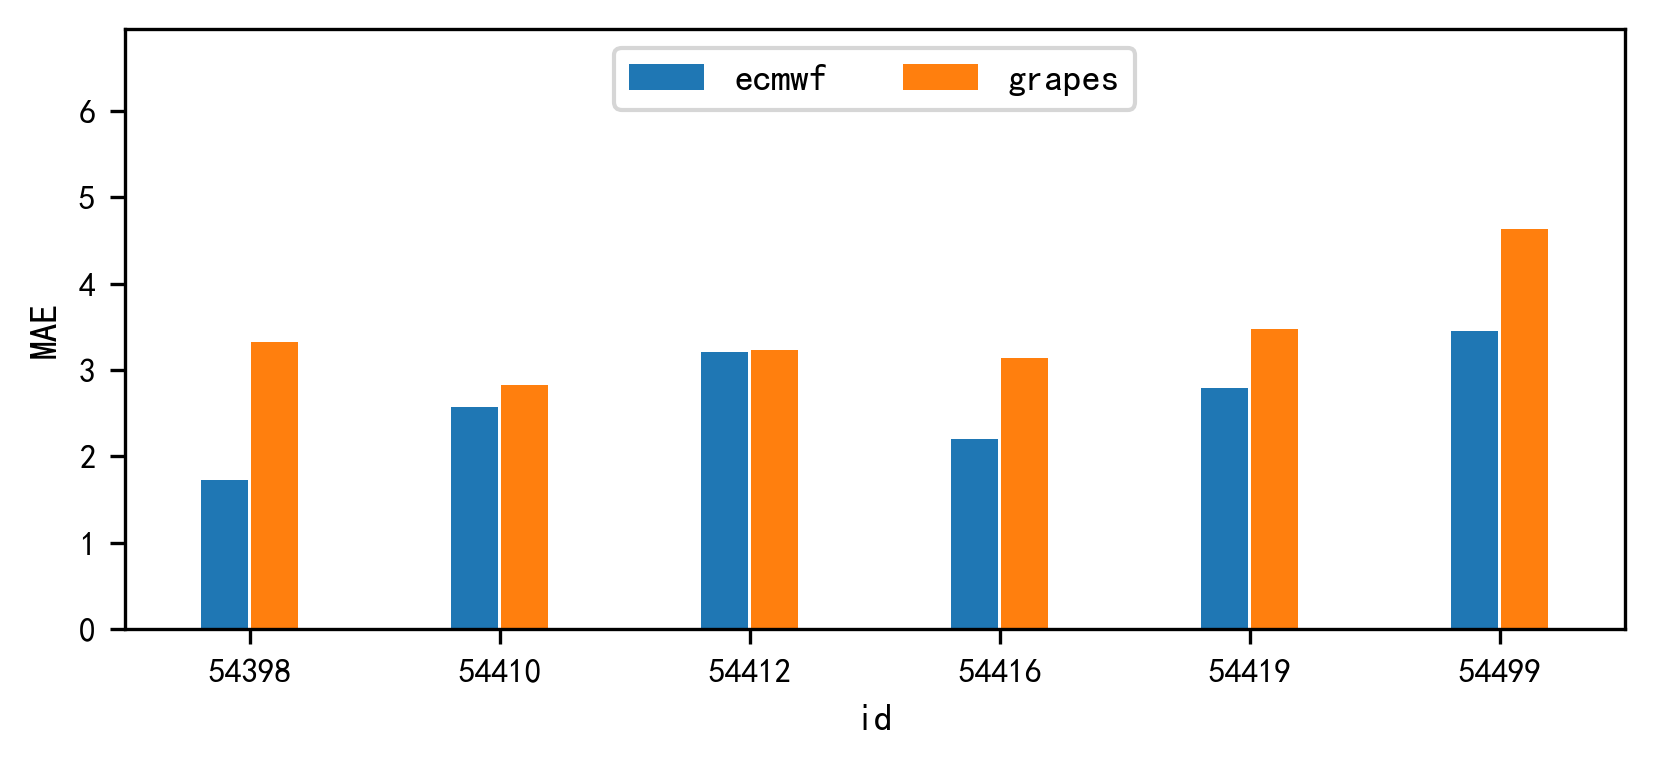

In [23]:
result = mpd.score(sta_all,mem.mae, g = "id",plot  ="bar")  #以站号分组

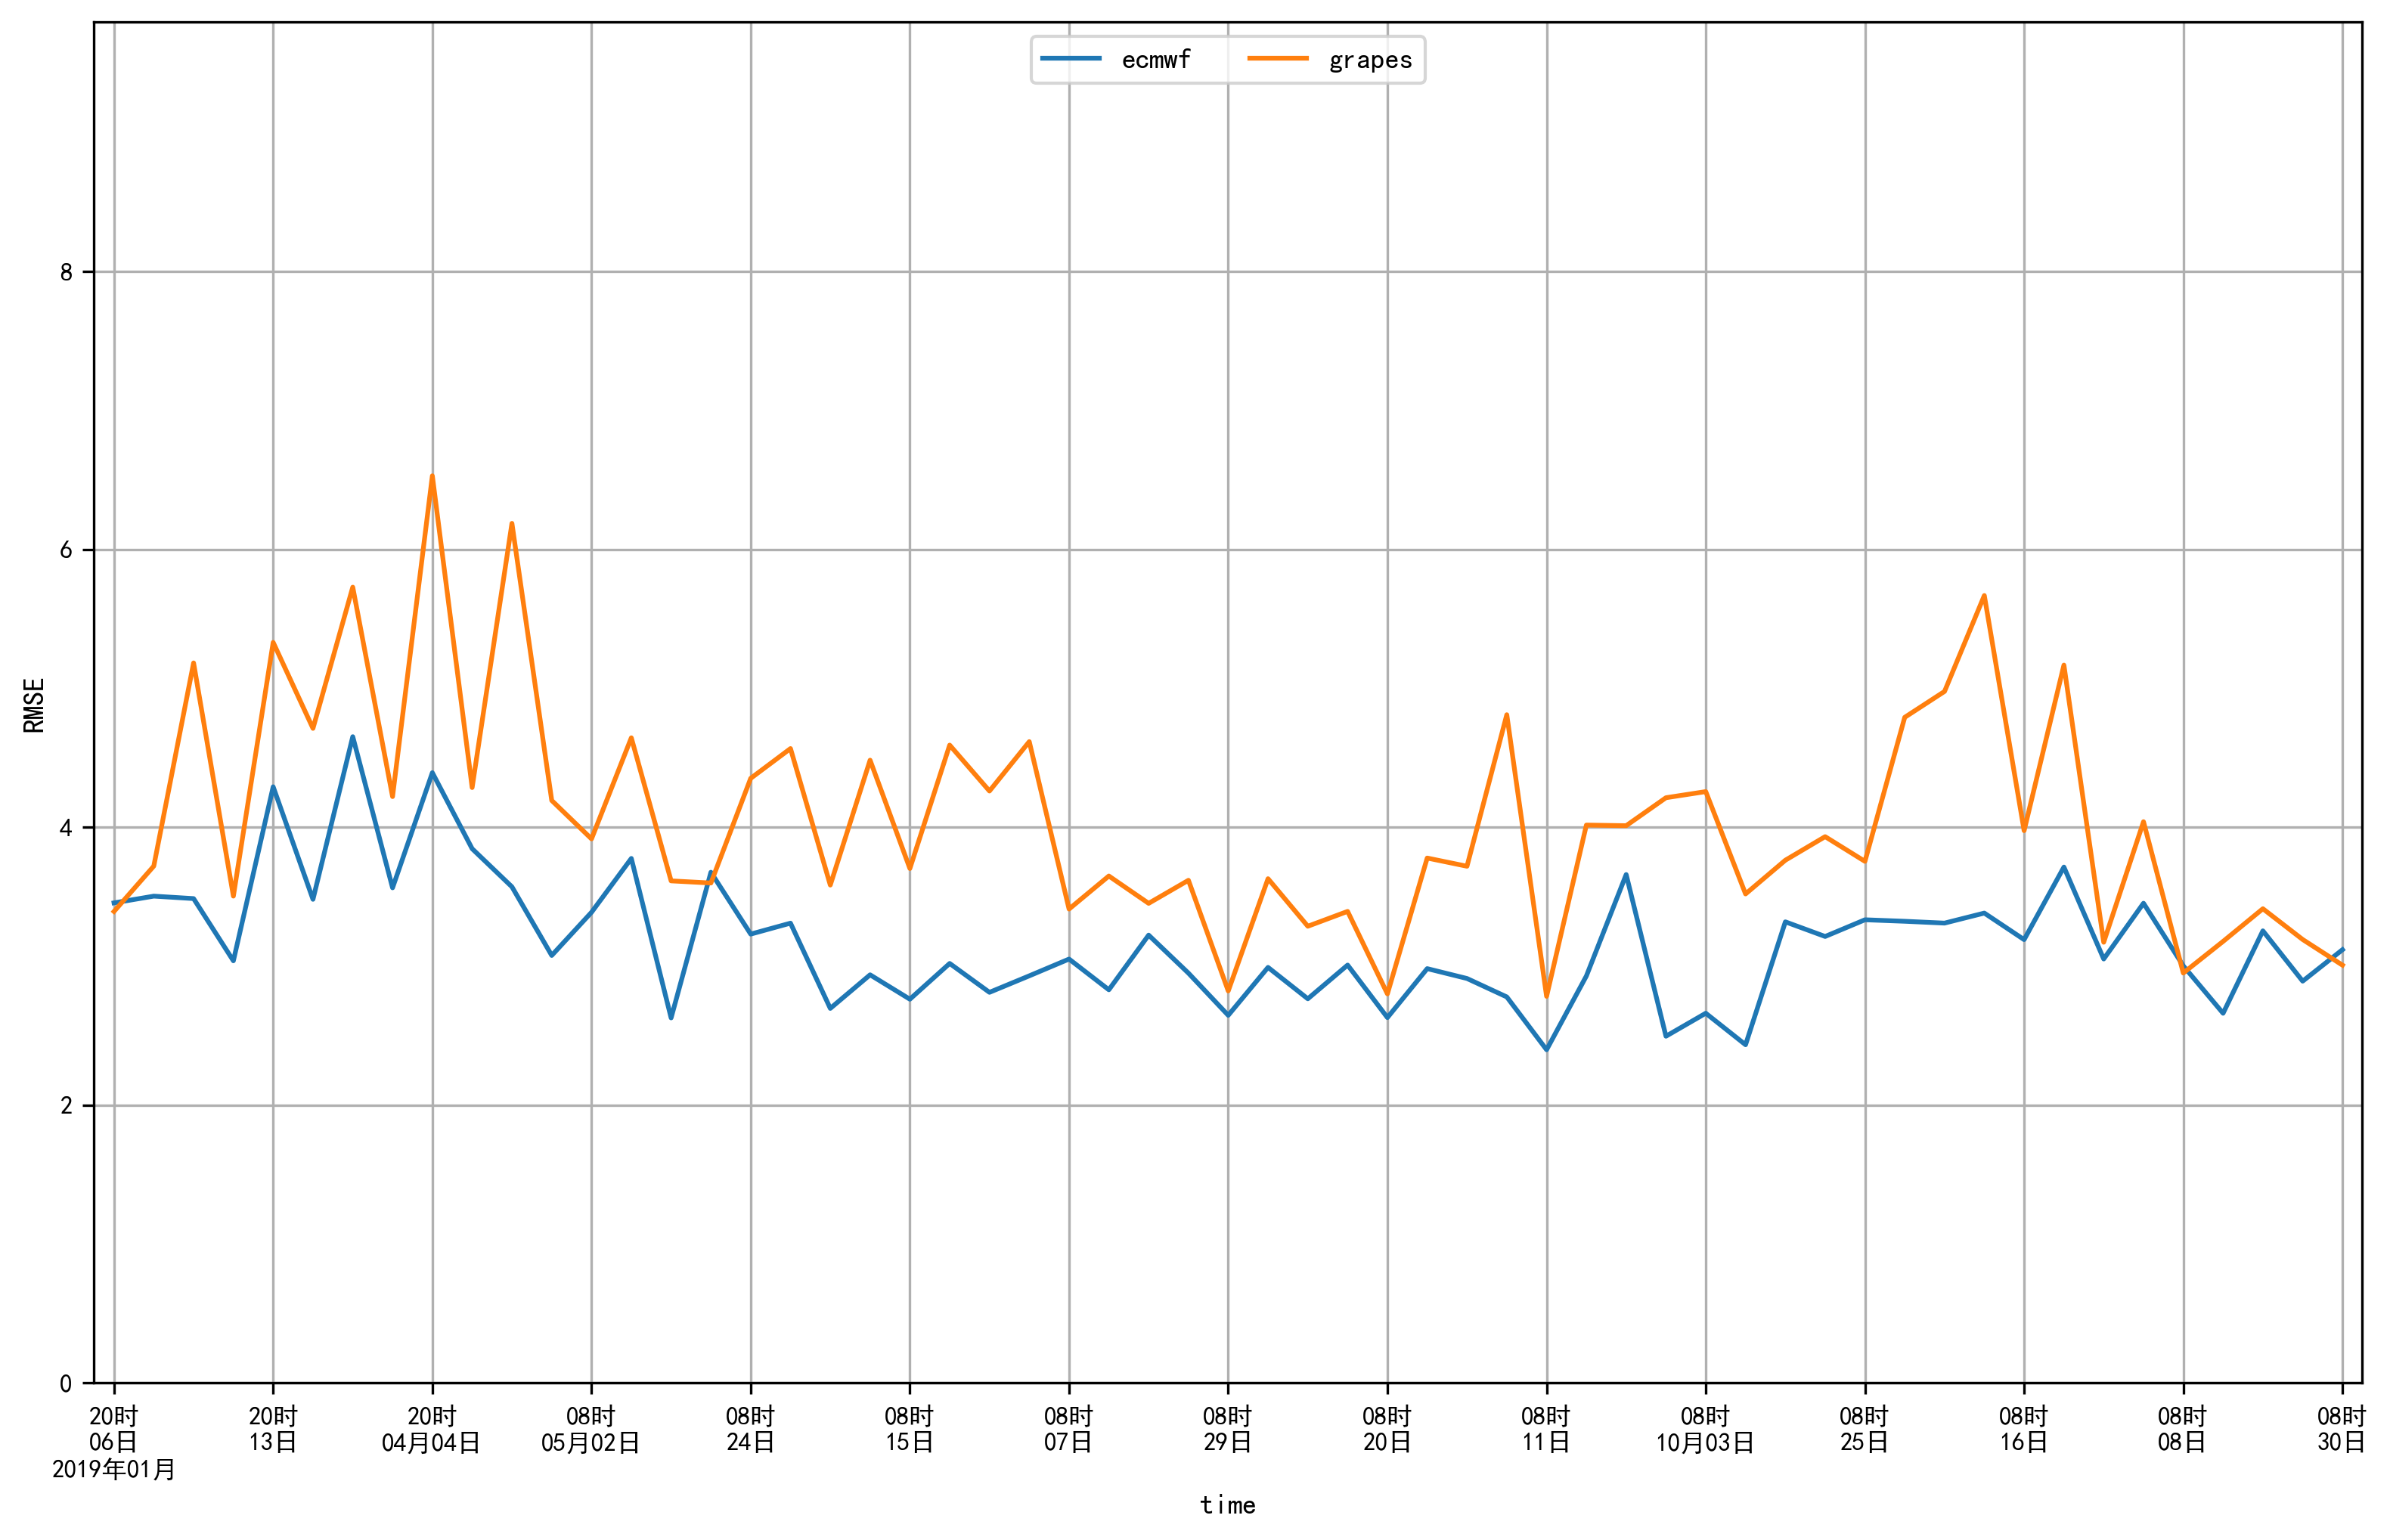

In [24]:
result = mpd.score(sta_all,mem.rmse, g = "time",plot = "plot")  
#以起报时间分组，由于分组较多x轴不能完全显示，因此自动采用了跳点显示的方式，同时为了定位方便，自动增加了网格线

**<font face="黑体" color=blue size = 5>数值型检验指标计算 </font>**     
**score_id(sta_ob_and_fos0,method,s = None,g = None,gll = None,group_name_list = None,plot = None,save_dir = None,save_path = None,show = False, add_county_line = False,map_extend= None,print_max=0,print_min=0,dpi = 300,**kwargs)**  
根据输入的站点数据和检验方法，选择部分数据，将选择的数据进行进行分组检验，计算各种数值型检验指标（不包括检验中间量）


|参数|说明|  
|:--|:--|  
|**<font face="黑体" color=blue size = 5>sta_ob_and_fos </font>**|实况和预报合并对齐后的数据，形式为站点数据格式如上述例子中的sta_all|   
|**<font face="黑体" color=blue size = 5>method </font>**|method中的各类数值型检验指标的函数名称，例如在本页面中已经import meteva.method as mem ，则ts评分的函数名称可以写为mem.ts ，均方根误差计算函数的名称可以写为 mem.rmse。这些函数选项包括[连续型预报](https://www.showdoc.cc/nmc?page_id=2858658548509727)，[二分类预报](https://www.showdoc.cc/nmc?page_id=2860336958932349),[多分类预报](https://www.showdoc.cc/nmc?page_id=2859693269266585),[概率预报](https://www.showdoc.cc/nmc?page_id=3651805946039771),[集合预报](https://www.showdoc.cc/nmc?page_id=3629735872716279)等类别中的评分函数|   
|**s**| 用于选择数据样本的字典参数，具体的参数说明可参见meb.sele_by_dict中的[<font face="黑体" color=red size=5>s</font>](https://www.showdoc.cc/meteva?page_id=3975604785954540)参数  |   
|**g**|用于分组检验的参数，具体用法可参见meb.group中的[<font face="黑体" color=red size=5>g</font>](https://www.showdoc.cc/meteva?page_id=4071849185300418)参数|     
|**gll**| 用于分组检验的参数，具体用法可参见meb.group中的[<font face="黑体" color=red size=5>gll</font>](https://www.showdoc.cc/meteva?page_id=4071849185300418)参数|  
|**group_name_list**| 分组名称的列表|  
|**plot**|是否需要直接将检验结果绘制图片，该参数为None时不绘制，当参数为"scatter"时绘制散点图|   
|**save_dir**|图片输出文件夹，文件的路径将据此自动生成|  
|**save_path**|该参数不为None时将图片结果输出值save_path|   
|**show**|该参数不为None时在屏幕显示图片，如果plot不为None，但save_dir和save_path又都为None,则该参数会自动切换为True|  
|**add_county_line**|是否在图中添加县界|  
|**map_extend**|	底图的范围,缺省时自动根据站点数据的范围确定底图范围，不缺省时采用[slon,elon,slat,elat] 列表作为参数，也可也接受[网格信息类变量](https://www.showdoc.cc/meteva?page_id=3975600815874861)作为地图范围的参数|    
|**print_max**|在屏幕上打印评分指标最大的print_max的站点的信息|  
|**print_min**|在屏幕上打印评分指标最小的print_min的站点的信息|  
|**dpi**|绘图的dpi参数，用法同matplotlib中dpi参数|  
|**kwargs| 检验方法 meteva.method 中的可选参数，具体用法参见下面的示例|   
|<font face="黑体" color=blue size=5>return</font>|返回一个元组，其包含2个元素，result[0]是包含数值检验指标结果。如没有分组检验，也没有分多种等级检验，则result[0]是一个[站点数据](https://www.showdoc.cc/meteva?page_id=3975600580125986)形式的数据，其中数据列中包含了检验的结果，不同预报成员（或观测）的检验（或统计）属性位于不同的列；如果有分组检验，或者有多种等级的检验，则result[0]是一个列表，其中包含不同等级或分组的结果，每个结果是一个[站点数据](https://www.showdoc.cc/meteva?page_id=3975600580125986)形式的数据；如果既包含分组，又包含多个等级，则result[0]是一个双层列表，外层代表多个分组的集合，内层代表多个等级的集合。result[1]是实际的分组方式|  
  
**调用示例：**

In [47]:
sta_all = pd.read_hdf(r"H:\test_data\input\mpd\temp_data.h5") #加载一周的预报数据,
print(sta_all) #其中包括grapes，ecmwf模式7天内多个时效的预报和对应的观测。

        level                time  dtime     id     lon    lat         ob  \
1425      0.0 2020-06-29 08:00:00      3  57197  114.35  32.97  27.500000   
1434      0.0 2020-06-29 08:00:00      3  57231  108.53  32.53  28.799999   
1436      0.0 2020-06-29 08:00:00      3  57233  108.50  32.90  27.200001   
1437      0.0 2020-06-29 08:00:00      3  57237  108.03  32.07  30.600000   
1439      0.0 2020-06-29 08:00:00      3  57242  109.37  32.85  28.400000   
...       ...                 ...    ...    ...     ...    ...        ...   
742220    0.0 2020-06-23 08:00:00    156  58510  116.23  29.73  25.000000   
742221    0.0 2020-06-23 08:00:00    156  58512  116.55  29.90  24.100000   
742222    0.0 2020-06-23 08:00:00    156  58514  116.05  29.45  25.799999   
742223    0.0 2020-06-23 08:00:00    156  58517  116.20  29.27  26.200001   
742224    0.0 2020-06-23 08:00:00    156  58519  116.68  29.00  26.700001   

           grapes      ecmwf  
1425    27.690479  25.520103  
1434    25.48

In [65]:
#没有分组，也不用区分多个等级的情况，第二个参数mem.me代表统计sta_all数据中的平均误差
result = mpd.score_id(sta_all,mem.me) 
print(result)
#result 一个包含两个元素的元组，第0个元素是检验结果，它一个sta_data格式数据，
#result 第二个元素为实际分组方式，因为本例中没有分组参数，所以其 reulst[1]=[None]。
#其中result[0]元素中的数据列分别是grapes和ecmwf模式在每个站点上的平均误差，
#每个站点上的统计样本包括不同起报时间，不同预报时效的（预报，观测）数据对
#result[0]中的time 和dtime列的数据内容并不代表实际的时间时效含义

(     level                time  dtime     id     lon    lat    grapes  \
0      0.0 2020-06-29 08:00:00      3  57197  114.35  32.97 -1.126051   
1      0.0 2020-06-29 08:00:00      3  57231  108.53  32.53 -3.645028   
2      0.0 2020-06-29 08:00:00      3  57233  108.50  32.90 -2.947213   
3      0.0 2020-06-29 08:00:00      3  57237  108.03  32.07 -3.504351   
4      0.0 2020-06-29 08:00:00      3  57242  109.37  32.85 -4.662575   
..     ...                 ...    ...    ...     ...    ...       ...   
164    0.0 2020-06-29 08:00:00      3  58510  116.23  29.73 -0.290467   
165    0.0 2020-06-29 08:00:00      3  58512  116.55  29.90 -0.406633   
166    0.0 2020-06-29 08:00:00      3  58514  116.05  29.45 -0.434255   
167    0.0 2020-06-29 08:00:00      3  58517  116.20  29.27 -0.022070   
168    0.0 2020-06-29 08:00:00      3  58519  116.68  29.00 -0.878438   

        ecmwf  
0   -0.232724  
1   -1.013992  
2   -0.423975  
3   -2.781958  
4   -2.109641  
..        ...  
164  0.517

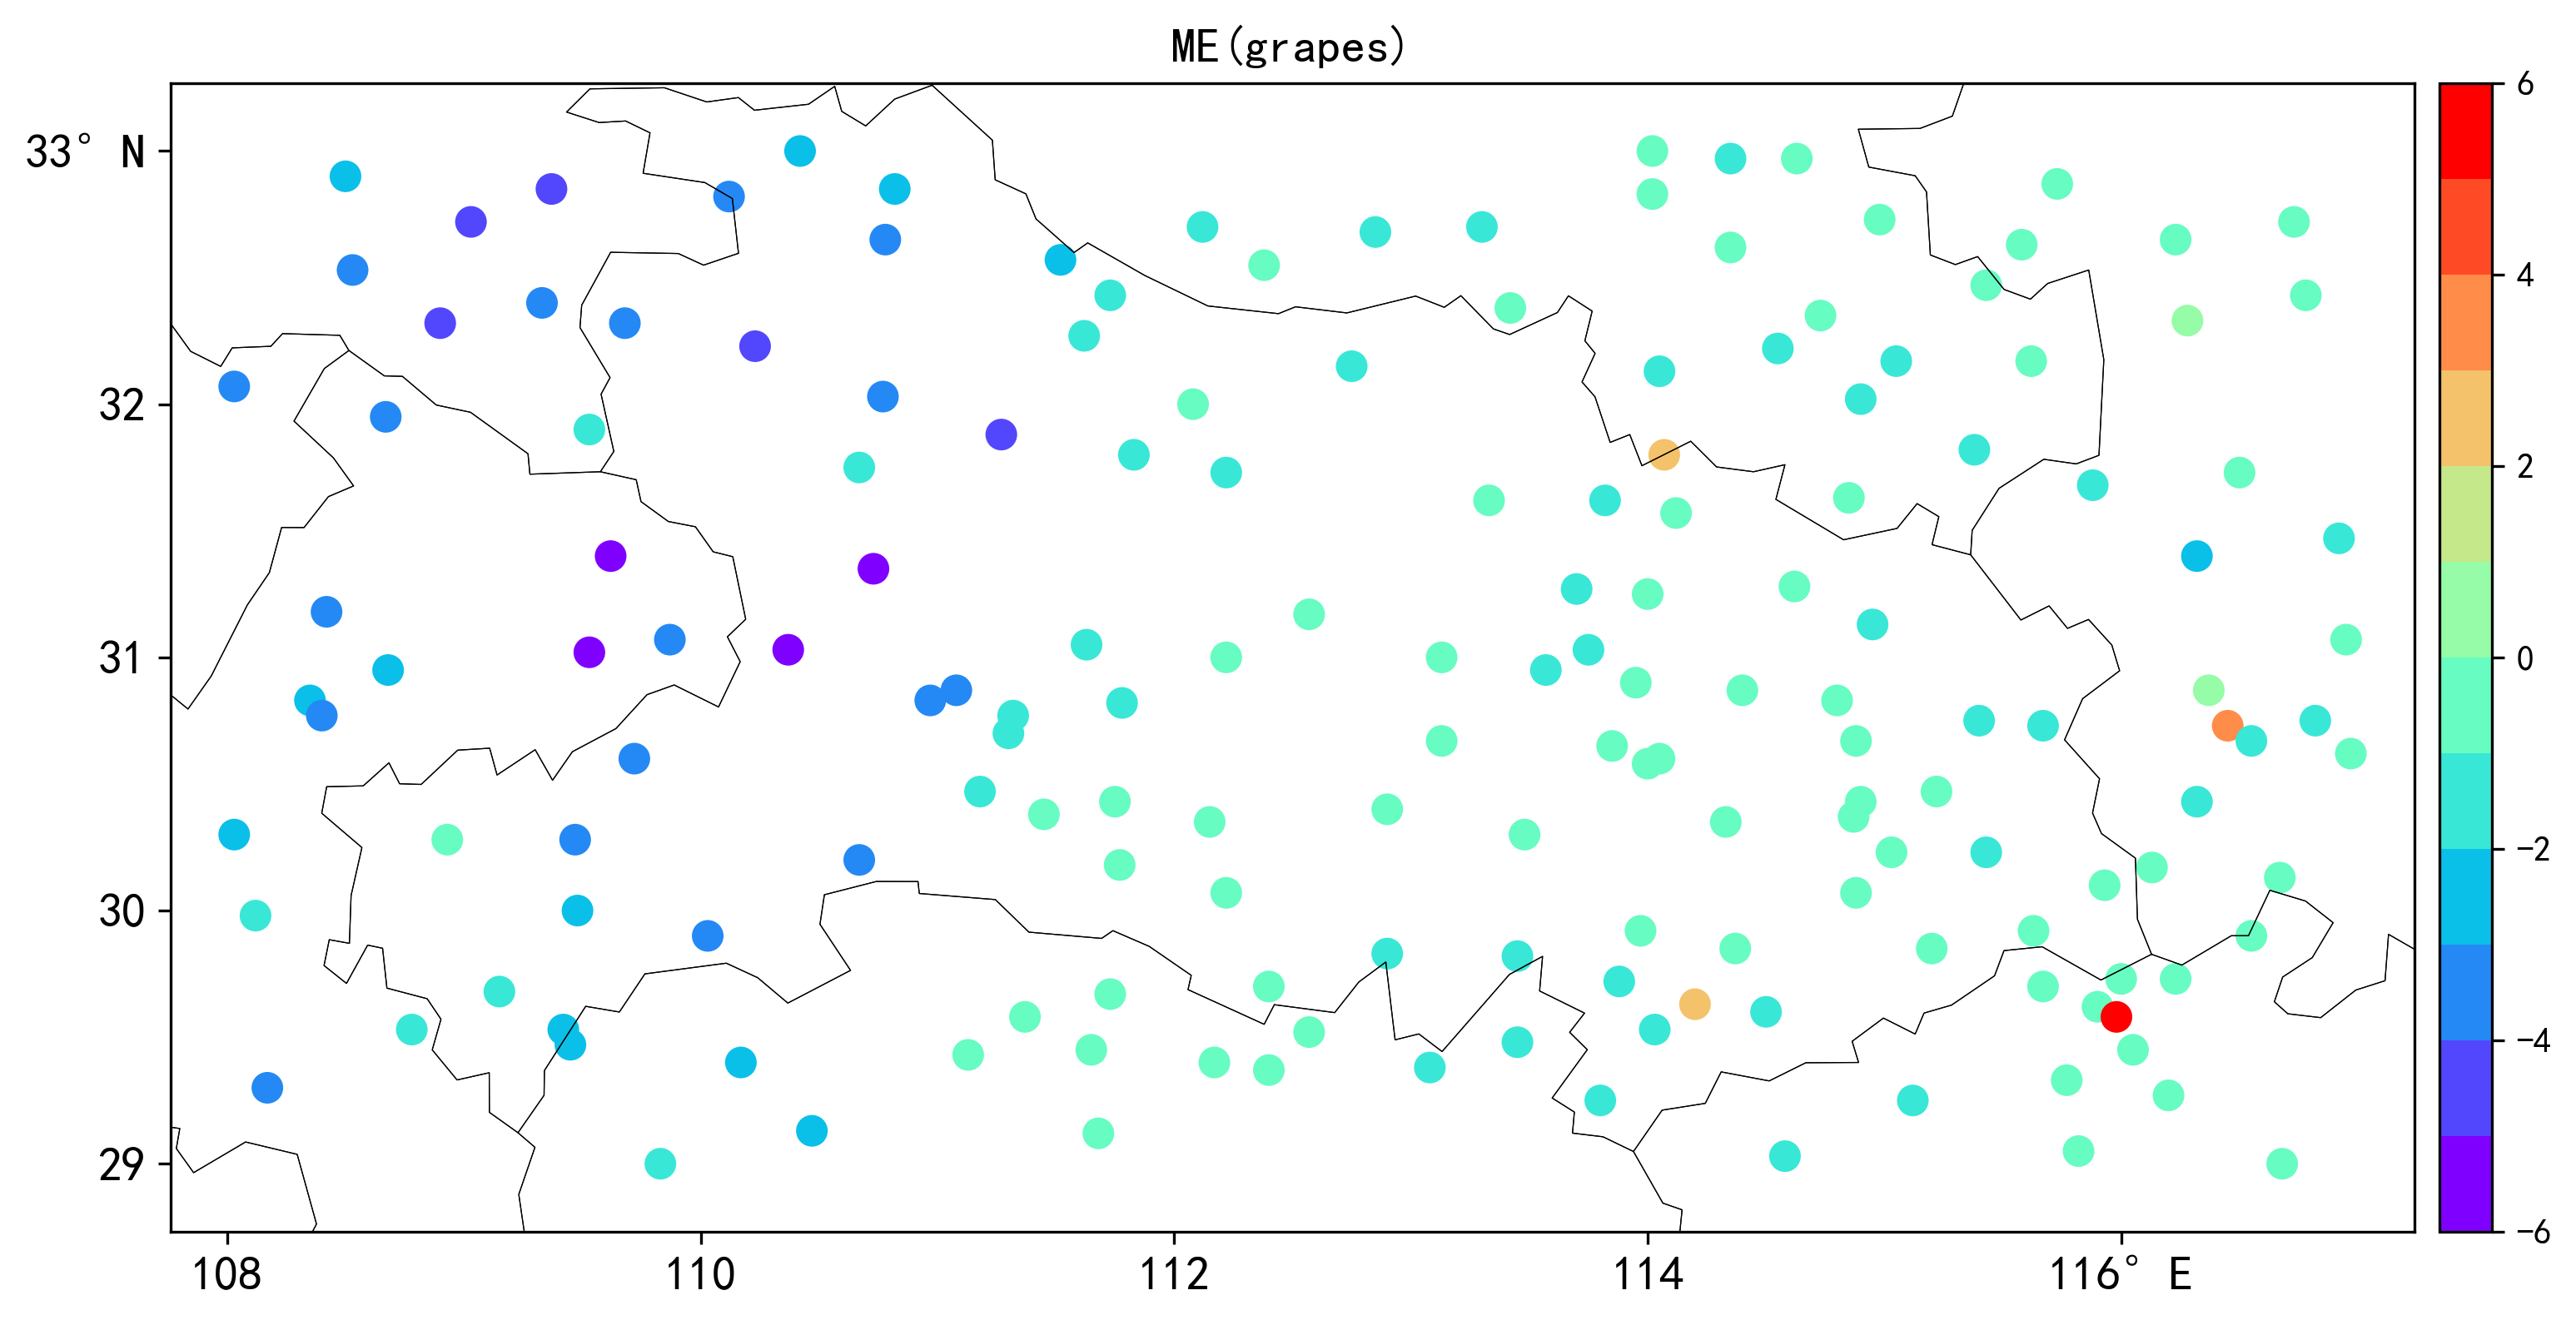

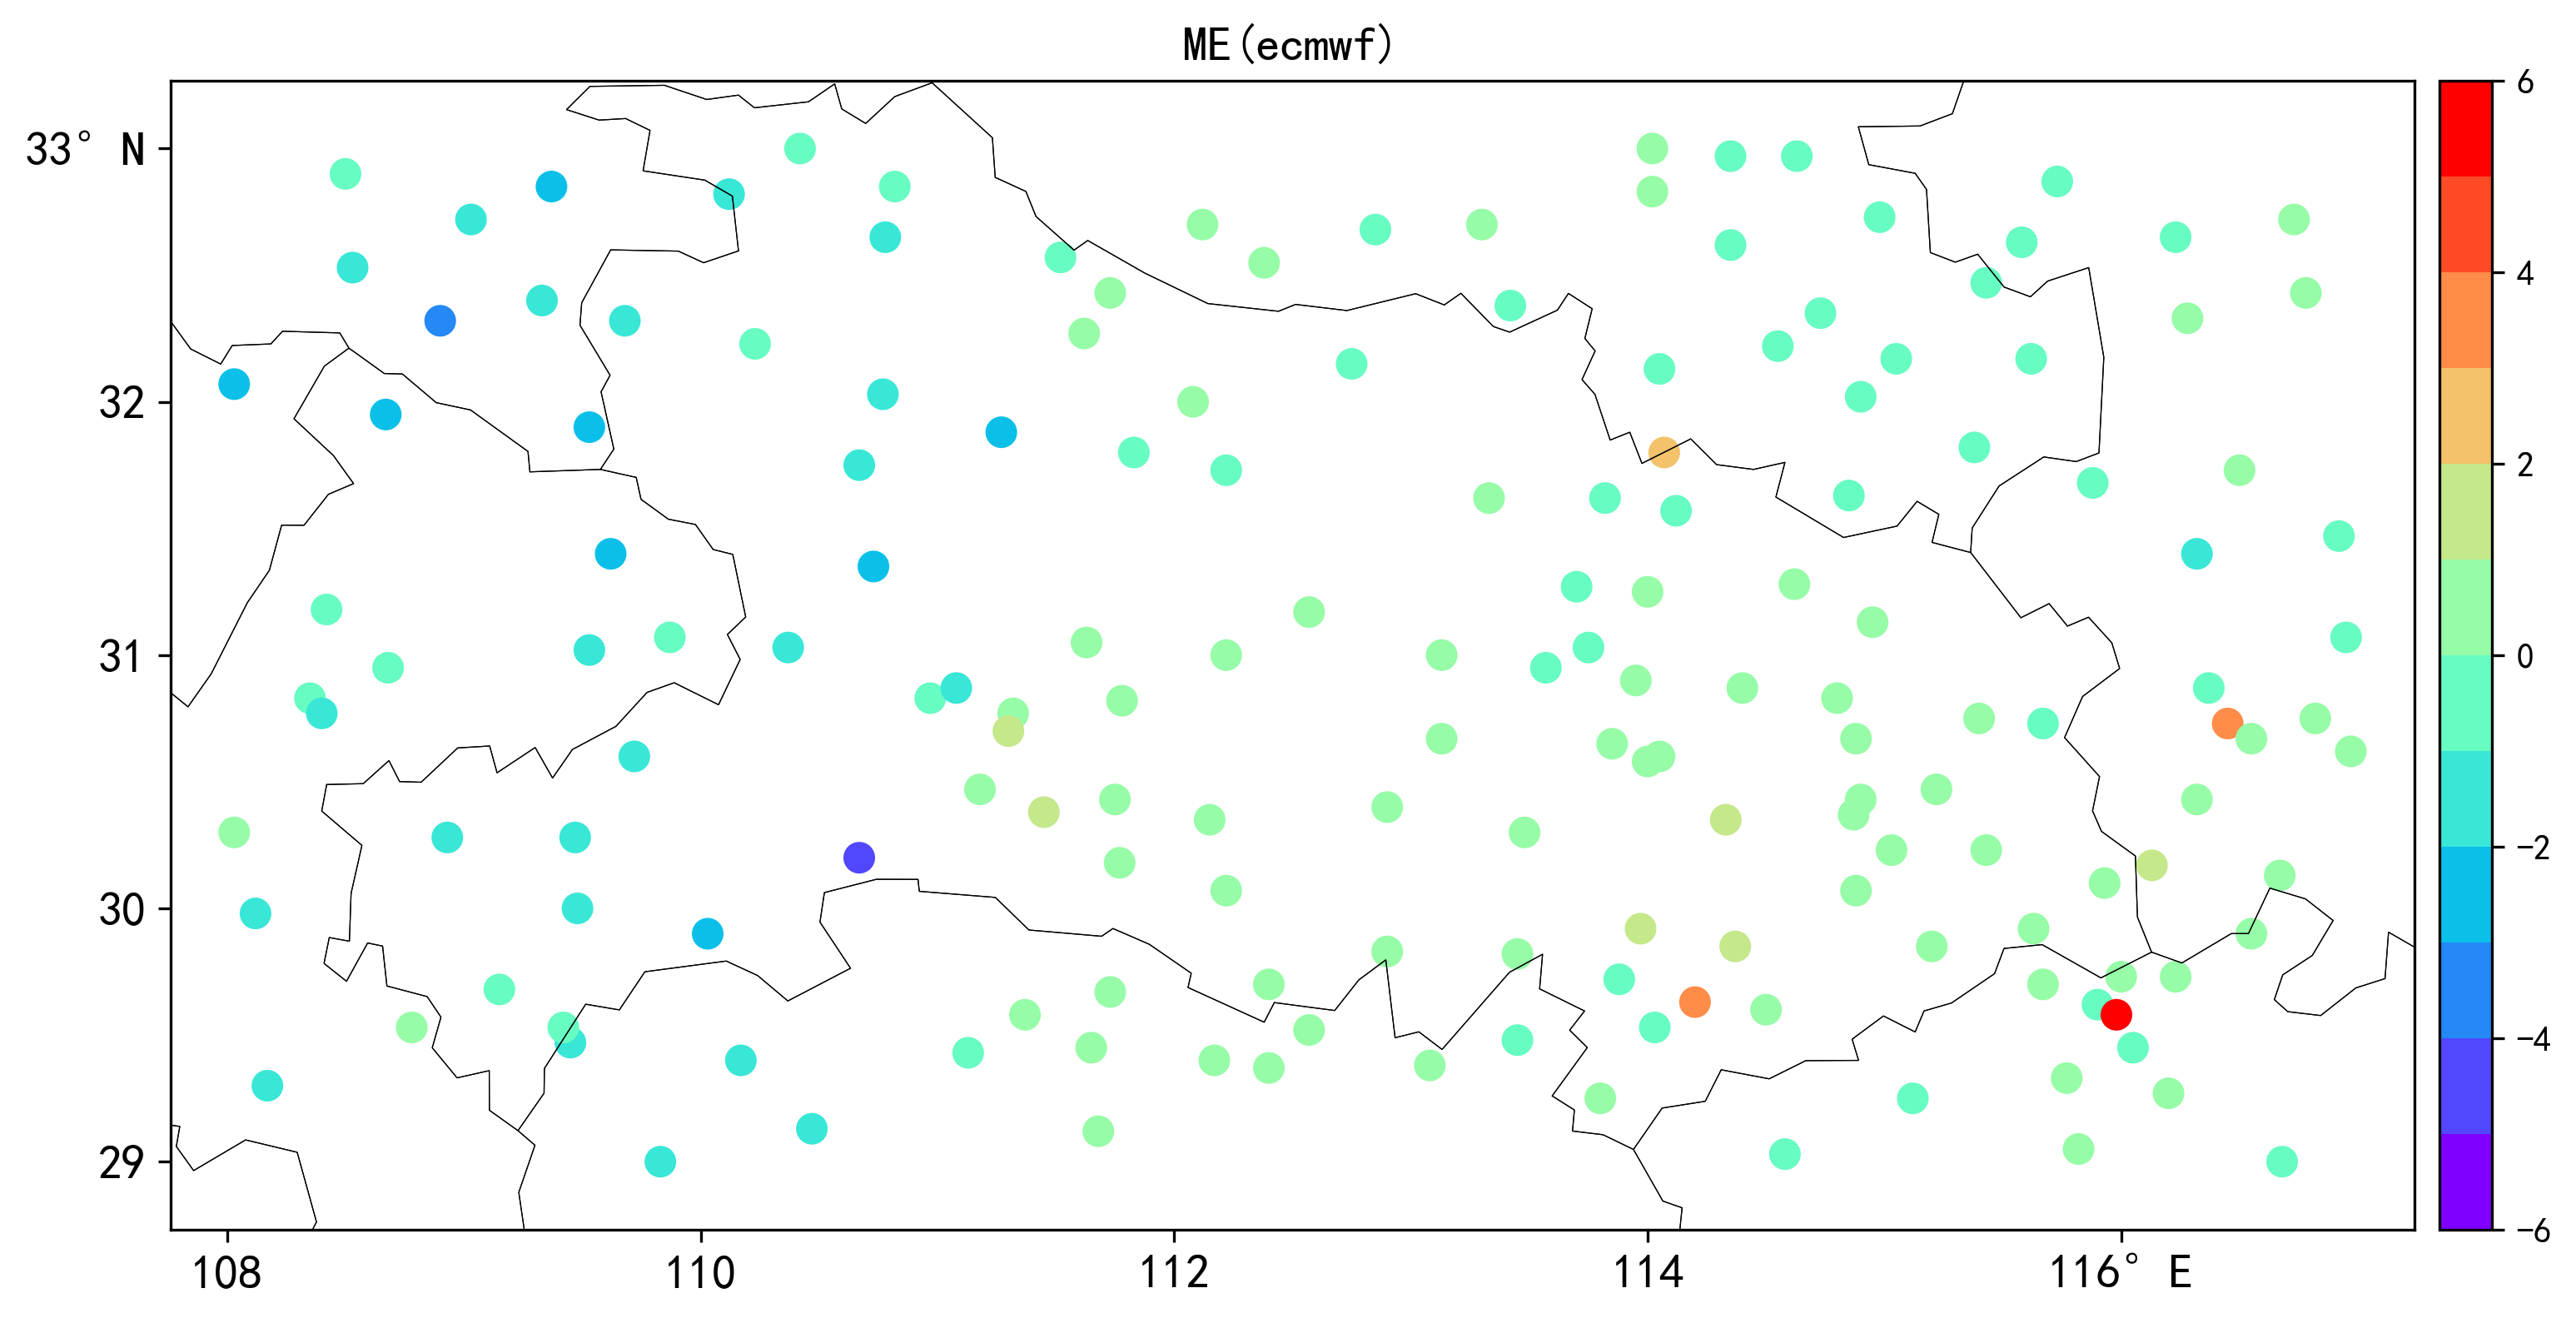

In [69]:
result = mpd.score_id(sta_all,mem.me,plot ="scatter")  
#如果plot参数设置为"scatter" 就会以散点图的形式将检验结果绘制出来
#下图所示的结果中显示，在统计数据sta_all所涉及的时间和时效范围内grapes在湖北西部附近的预报明显偏低

取值最小的1个站点：
id:57359   lon:110.73  lat:31.35 value:-5.8776984214782715


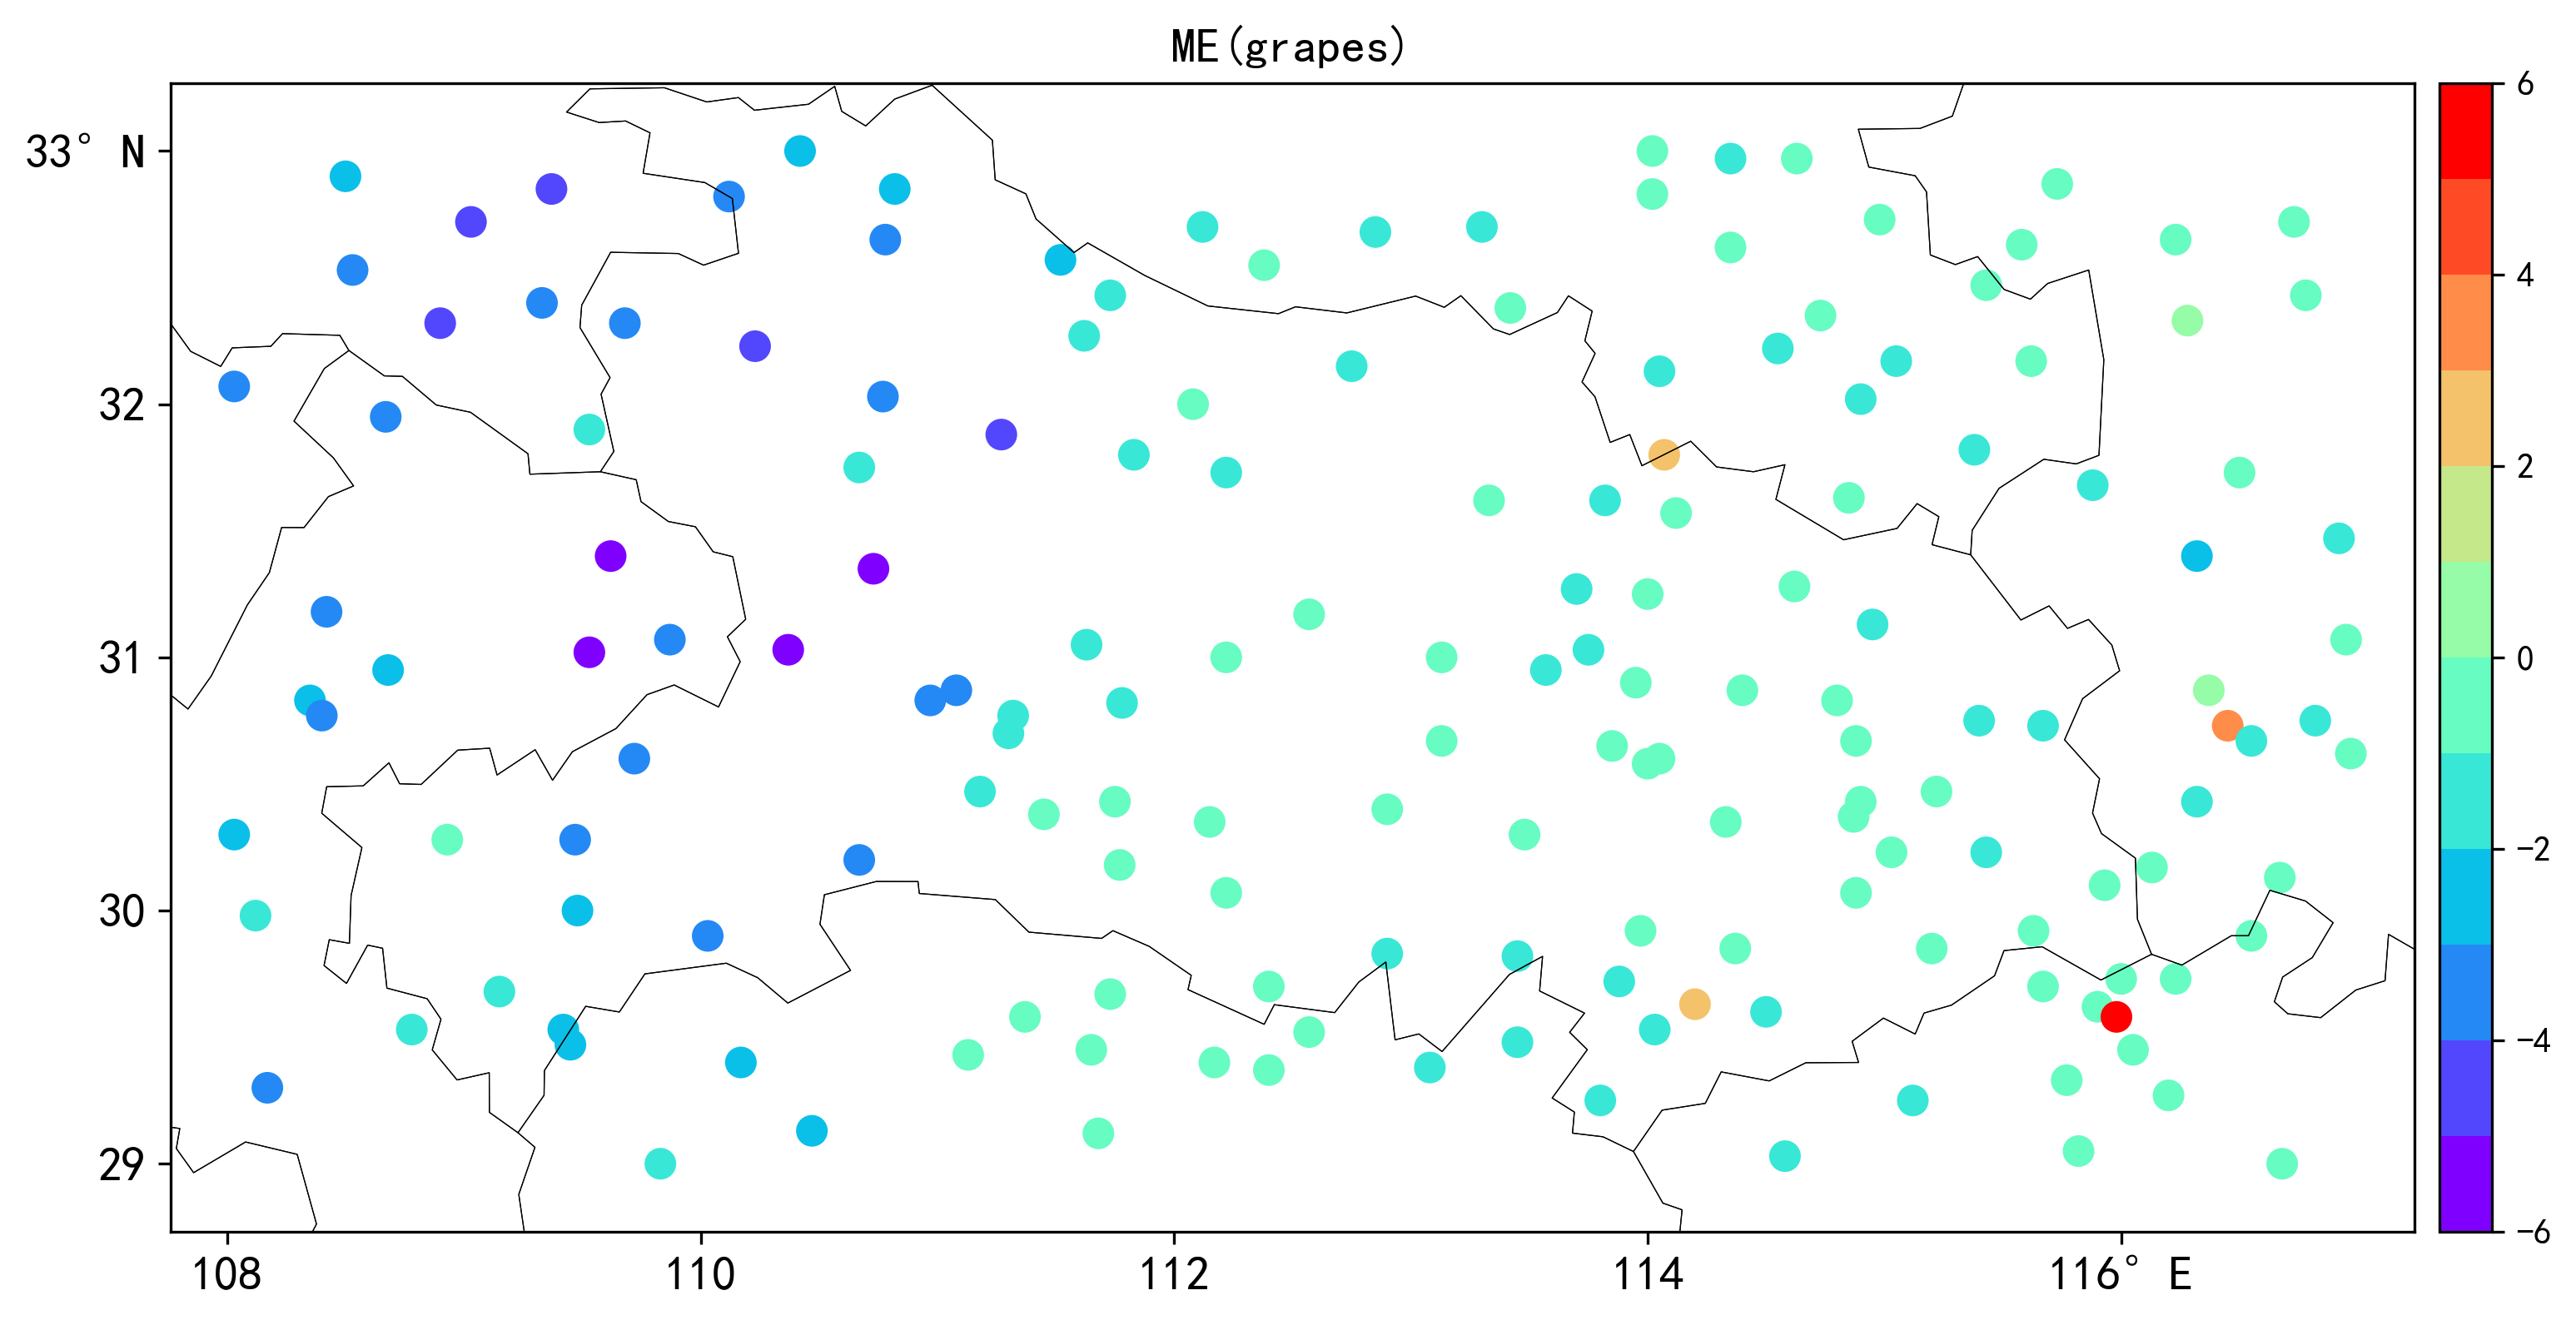

取值最小的1个站点：
id:57458   lon:110.67  lat:30.2 value:-3.5425734519958496


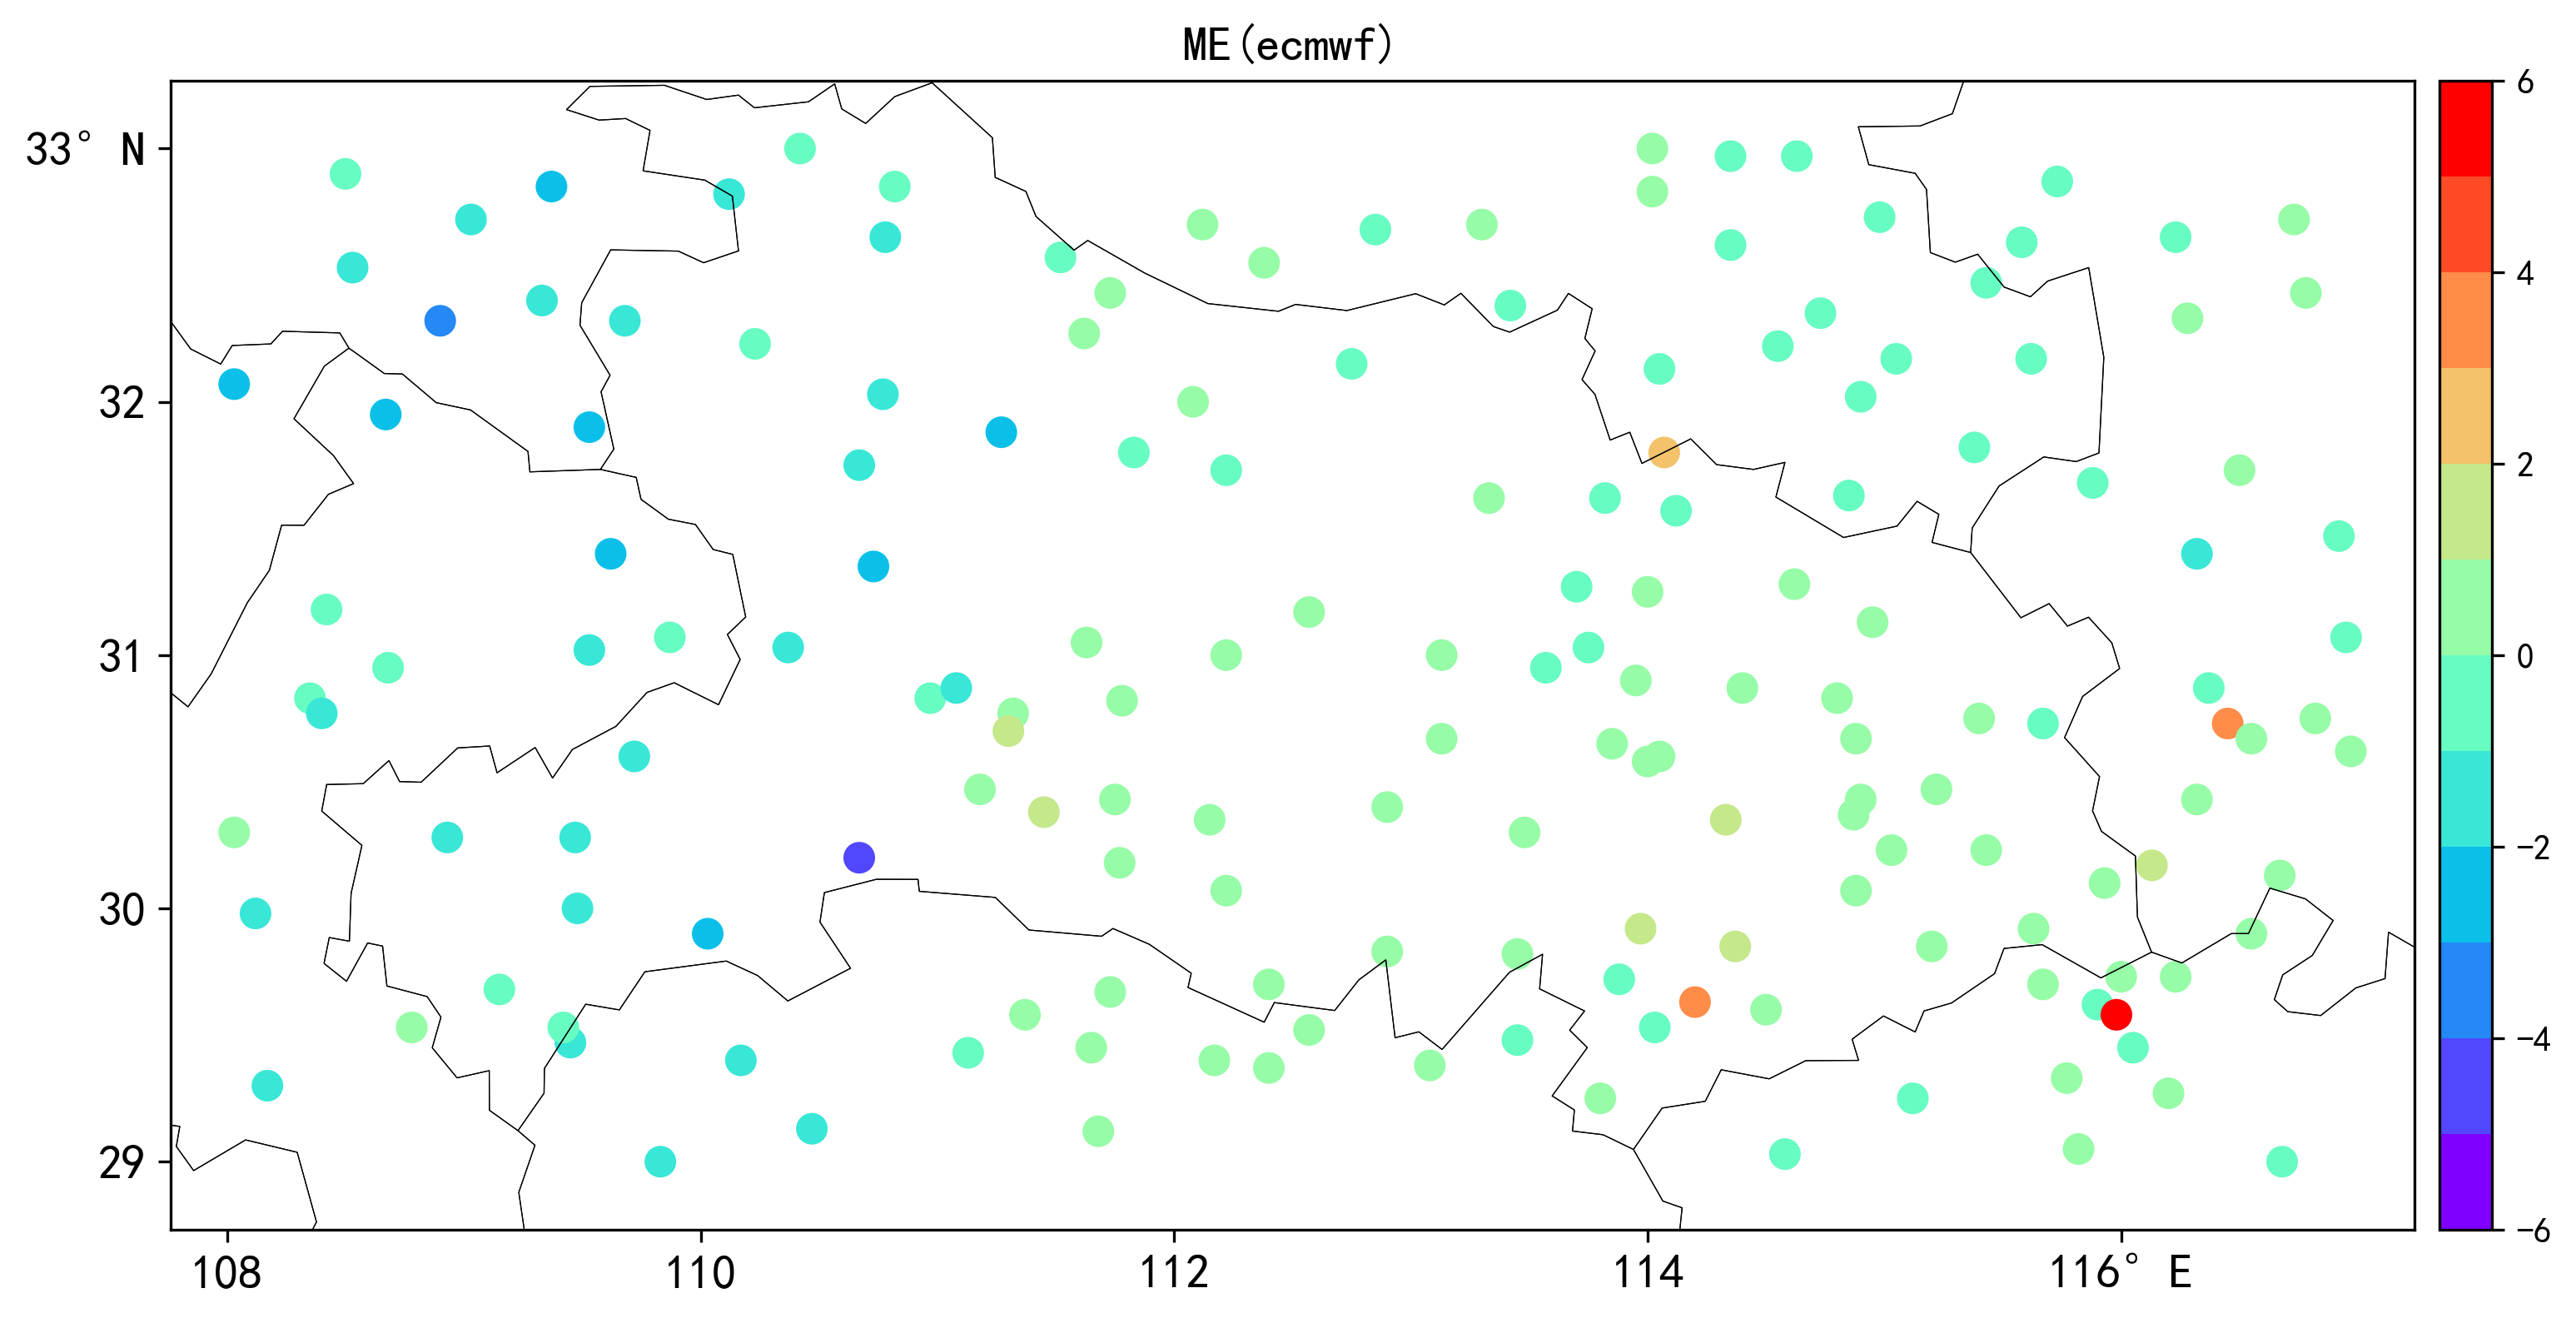

In [79]:
result = mpd.score_id(sta_all,mem.me,plot ="scatter",print_min = 1)  
#增加参数print_min = 1，意思是在屏幕上打印检验指标取值最小的1个站点信息。
#该结果不会保存在result中，也不会显示在图片中，仅仅是运行时打印在Python的输出窗口中
#打印结果先于对应的图片显示，如下所示。

取值最小的1个站点：
id:57359   lon:110.73  lat:31.35 value:-5.4762096


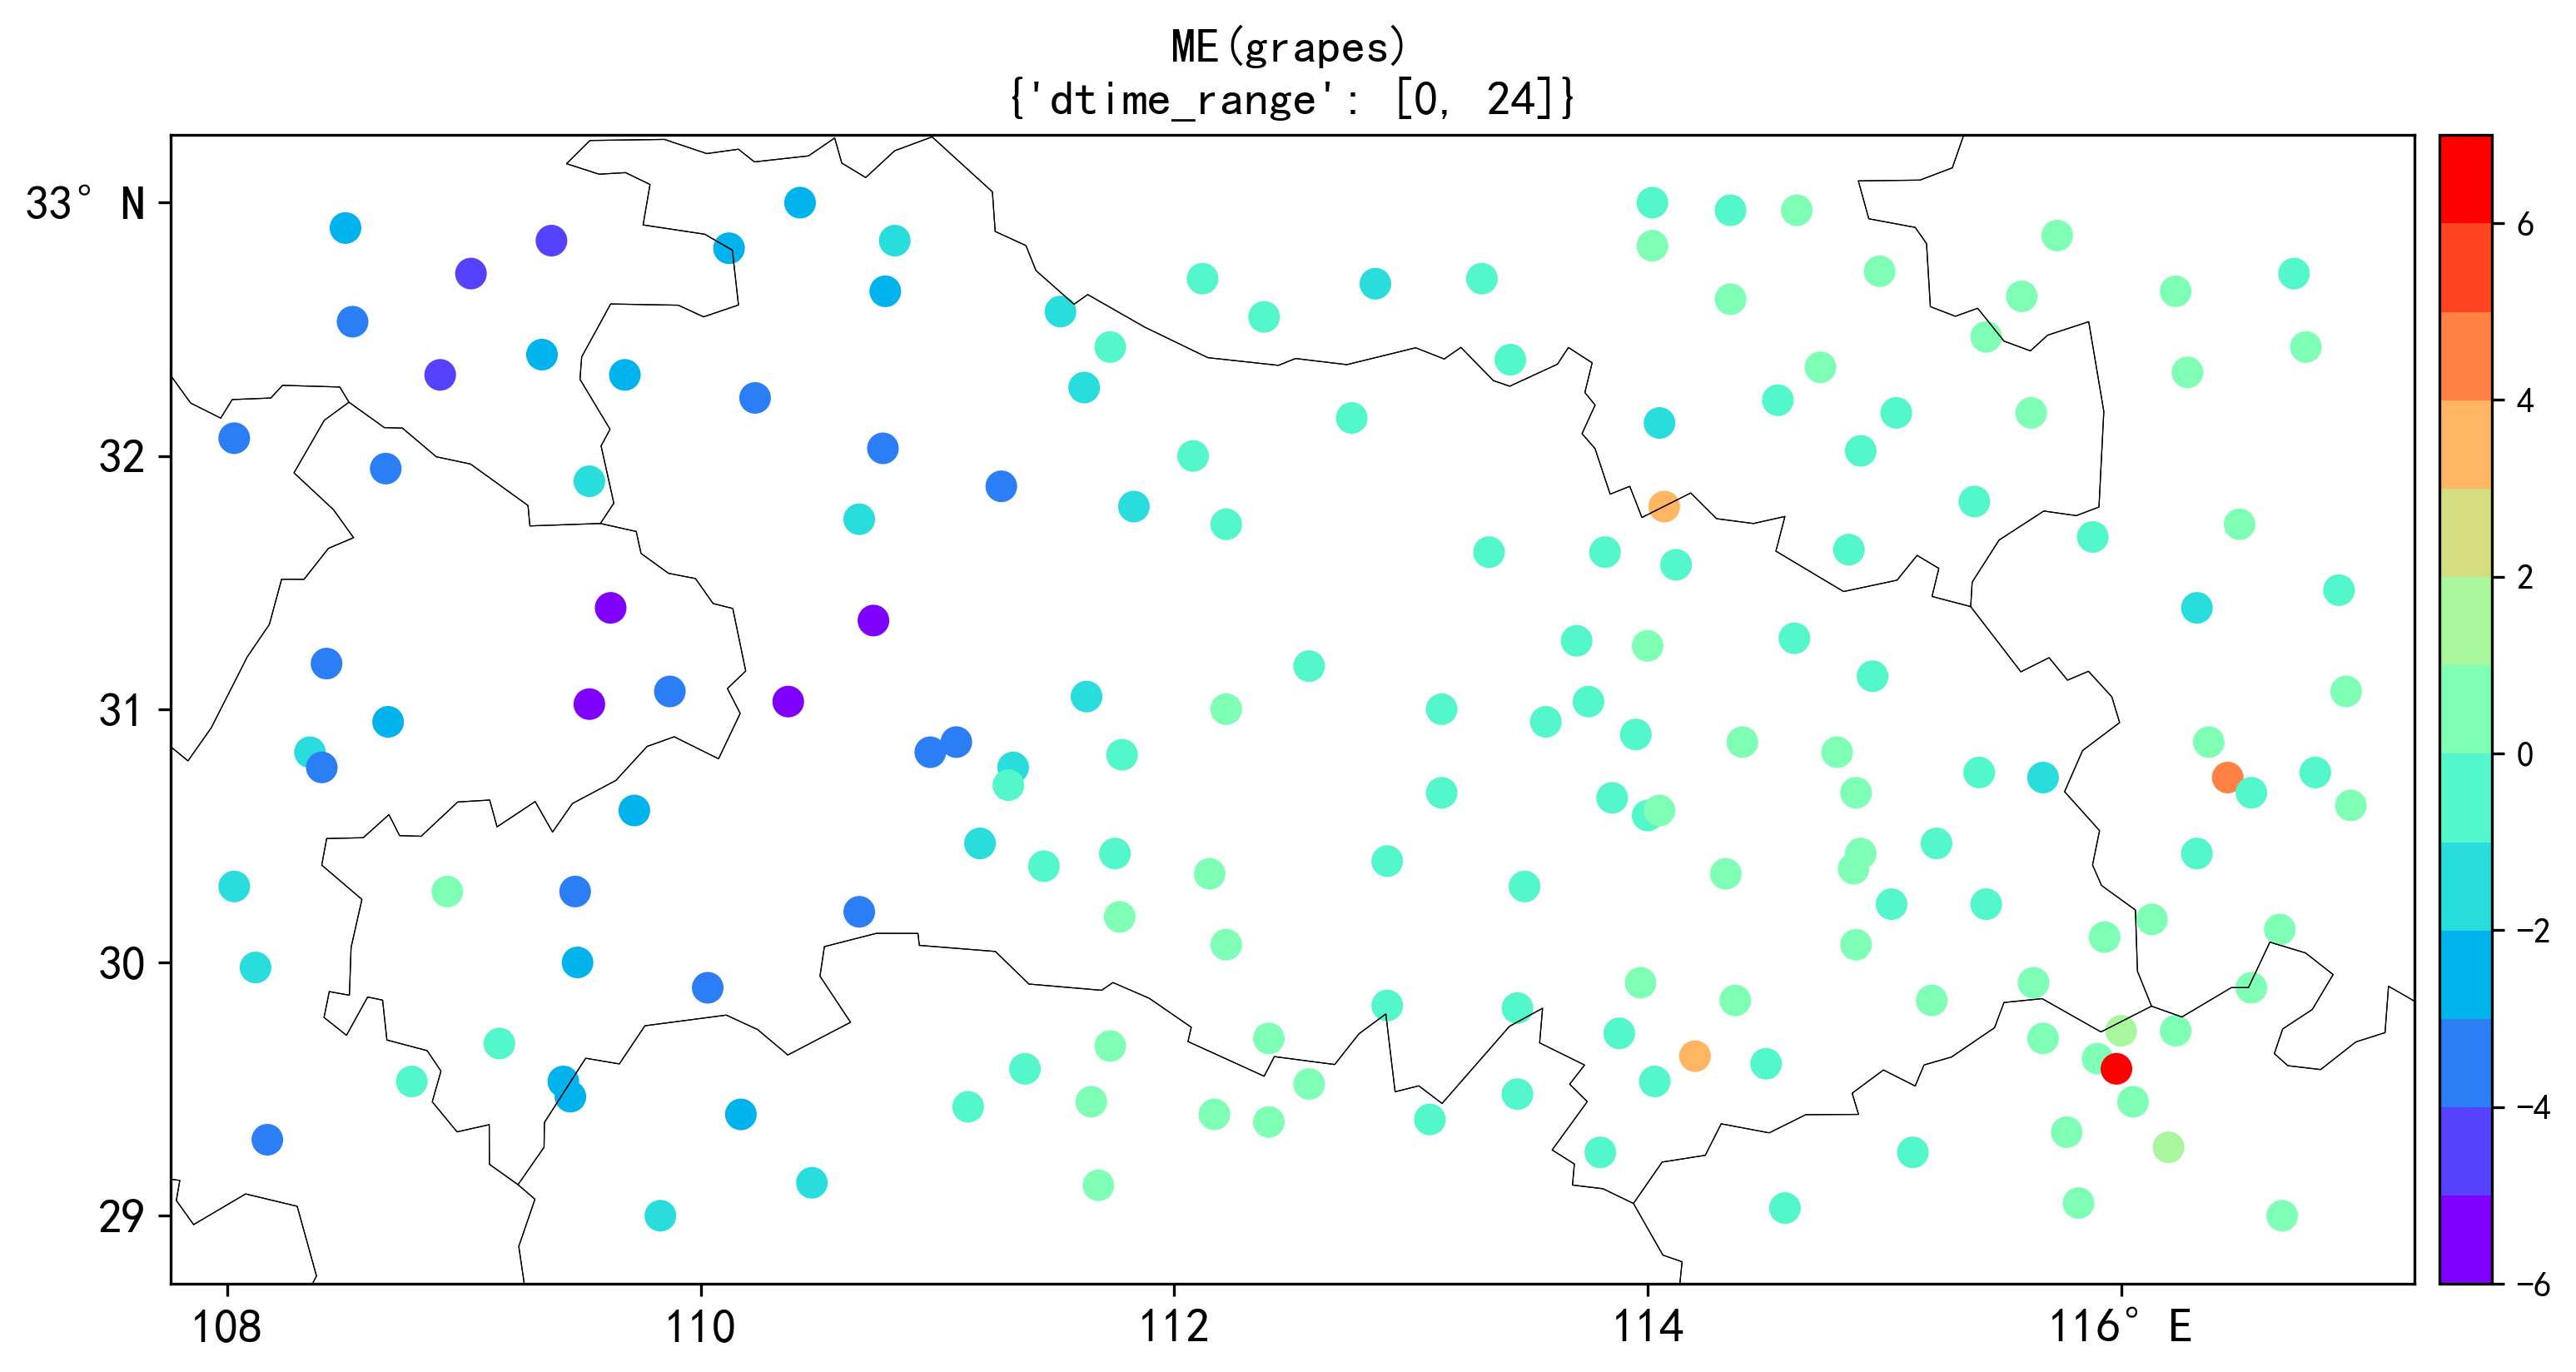

In [78]:
result = mpd.score_id(sta_all,mem.me,s = {"dtime_range":[0,24],"member":["ob","grapes"]},plot ="scatter",print_min = 1)  
#增加s参数，选择预报时效在0-24小时范围内的样本，同时在数据中只保留“ob”和“grapes”，因此也就只对grapes进行检验

取值最小的1个站点：
id:57359   lon:110.73  lat:31.35 value:-5.8377275


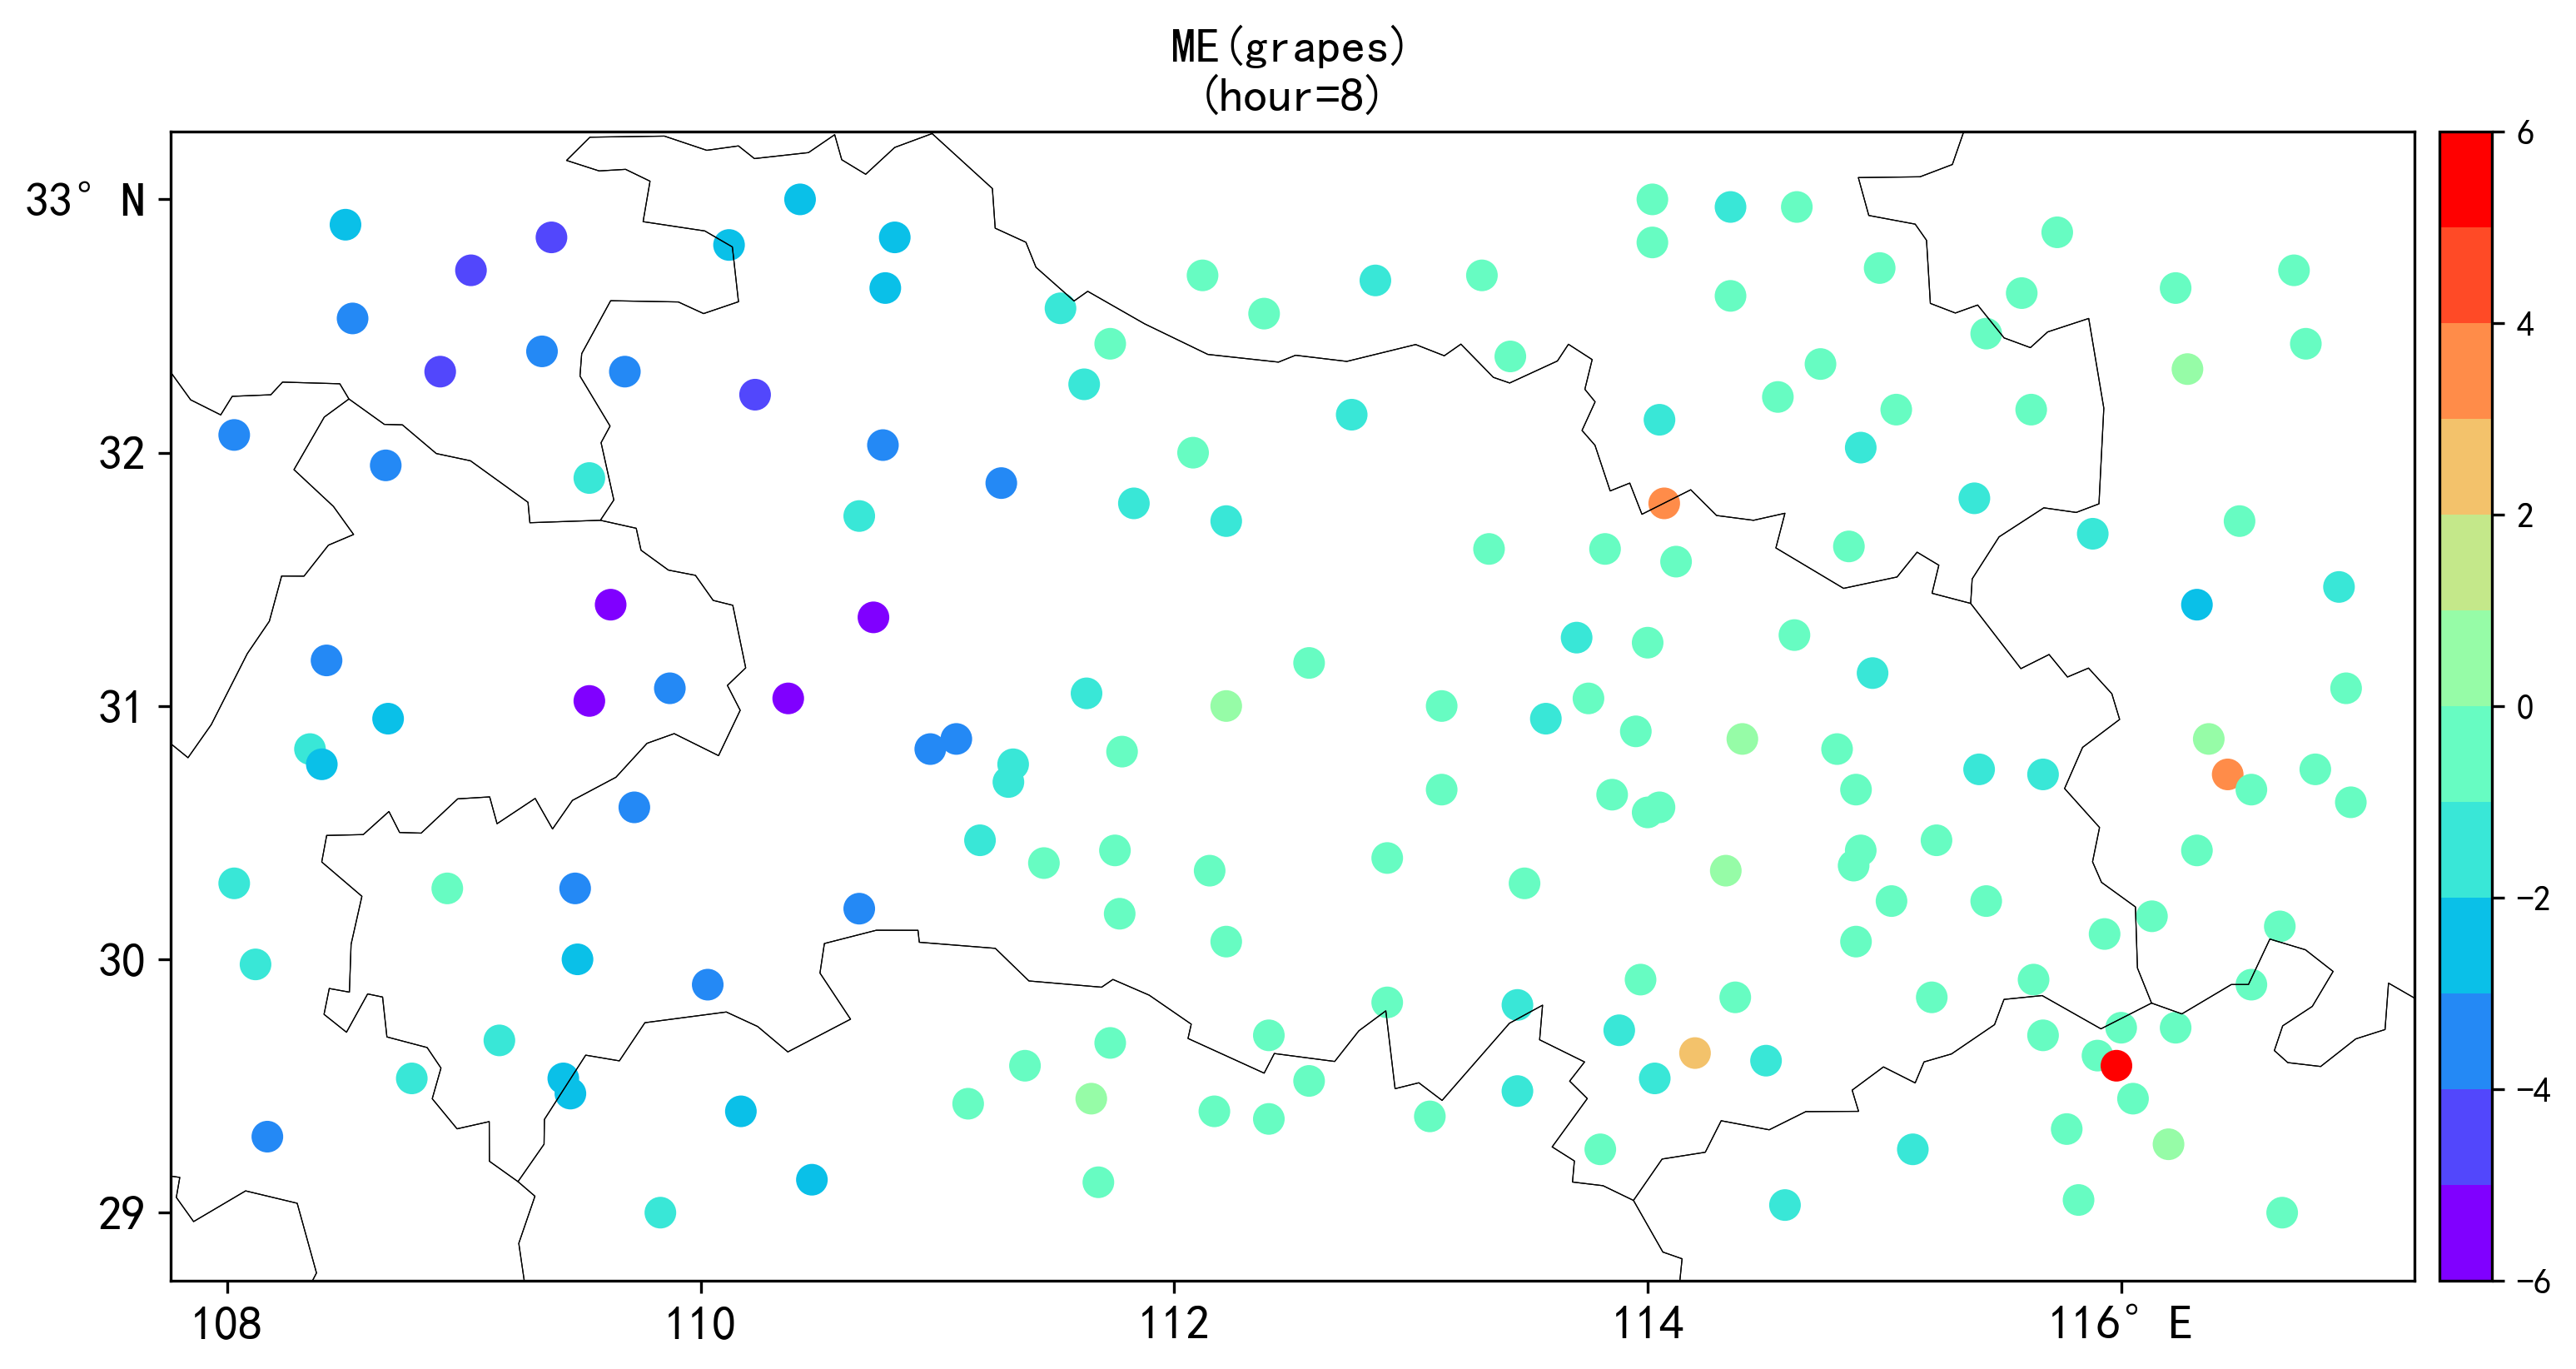

取值最小的1个站点：
id:57359   lon:110.73  lat:31.35 value:-5.922942


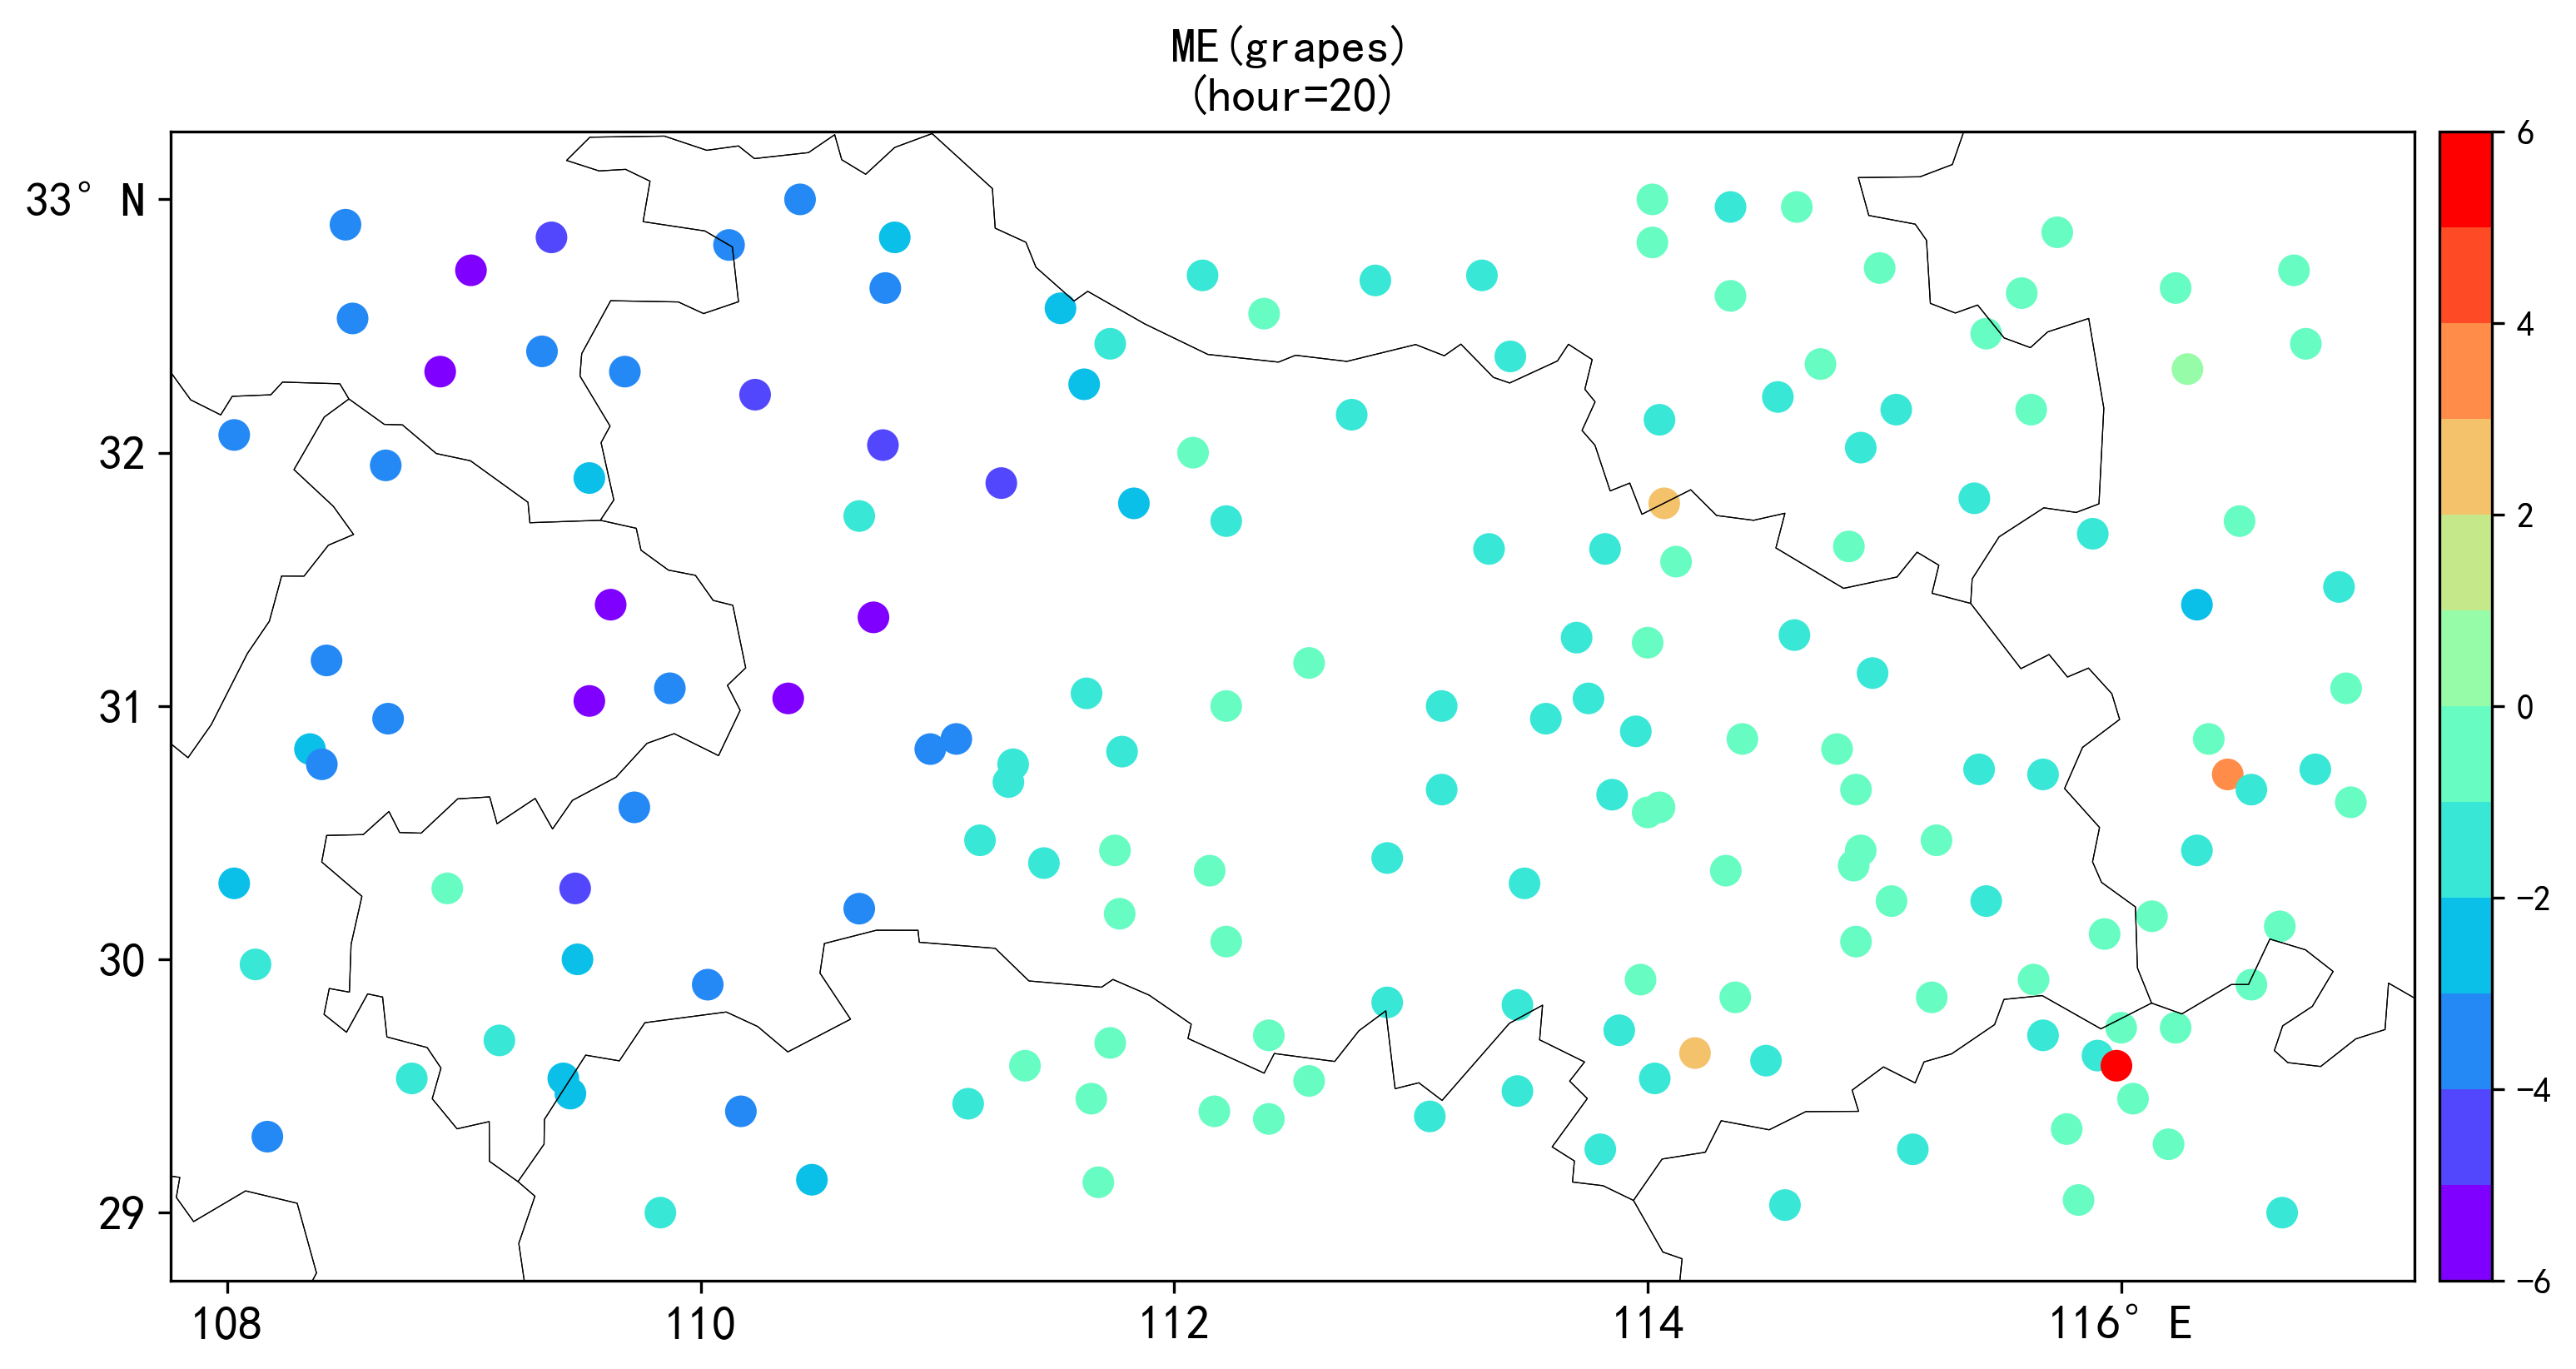

([     level                time  dtime     id     lon    lat    grapes
0      0.0 2020-06-29 08:00:00      3  57197  114.35  32.97 -1.013217
1      0.0 2020-06-29 08:00:00      3  57231  108.53  32.53 -3.599082
2      0.0 2020-06-29 08:00:00      3  57233  108.50  32.90 -2.844562
3      0.0 2020-06-29 08:00:00      3  57237  108.03  32.07 -3.369653
4      0.0 2020-06-29 08:00:00      3  57242  109.37  32.85 -4.496546
..     ...                 ...    ...    ...     ...    ...       ...
164    0.0 2020-06-29 08:00:00      3  58510  116.23  29.73 -0.173258
165    0.0 2020-06-29 08:00:00      3  58512  116.55  29.90 -0.297697
166    0.0 2020-06-29 08:00:00      3  58514  116.05  29.45 -0.291208
167    0.0 2020-06-29 08:00:00      3  58517  116.20  29.27  0.149798
168    0.0 2020-06-29 08:00:00      3  58519  116.68  29.00 -0.729456

[169 rows x 7 columns],      level                time  dtime     id     lon    lat    grapes
0      0.0 2020-06-29 08:00:00      3  57197  114.35  32.97 -1.

In [77]:
result = mpd.score_id(sta_all,mem.me,s = {"member":["ob","grapes"]},g = "hour",plot ="scatter",print_min = 1)  
#数据中只保留“ob”和“grapes”，增加分组参数g = "hour"，意思是按起报时间分组检验
print(result) #由于按起报时间将预报分成了两组，所以result[0]中是包含两组检验结果的列表

取值最小的1个站点：
id:57359   lon:110.73  lat:31.35 value:-5.8377275


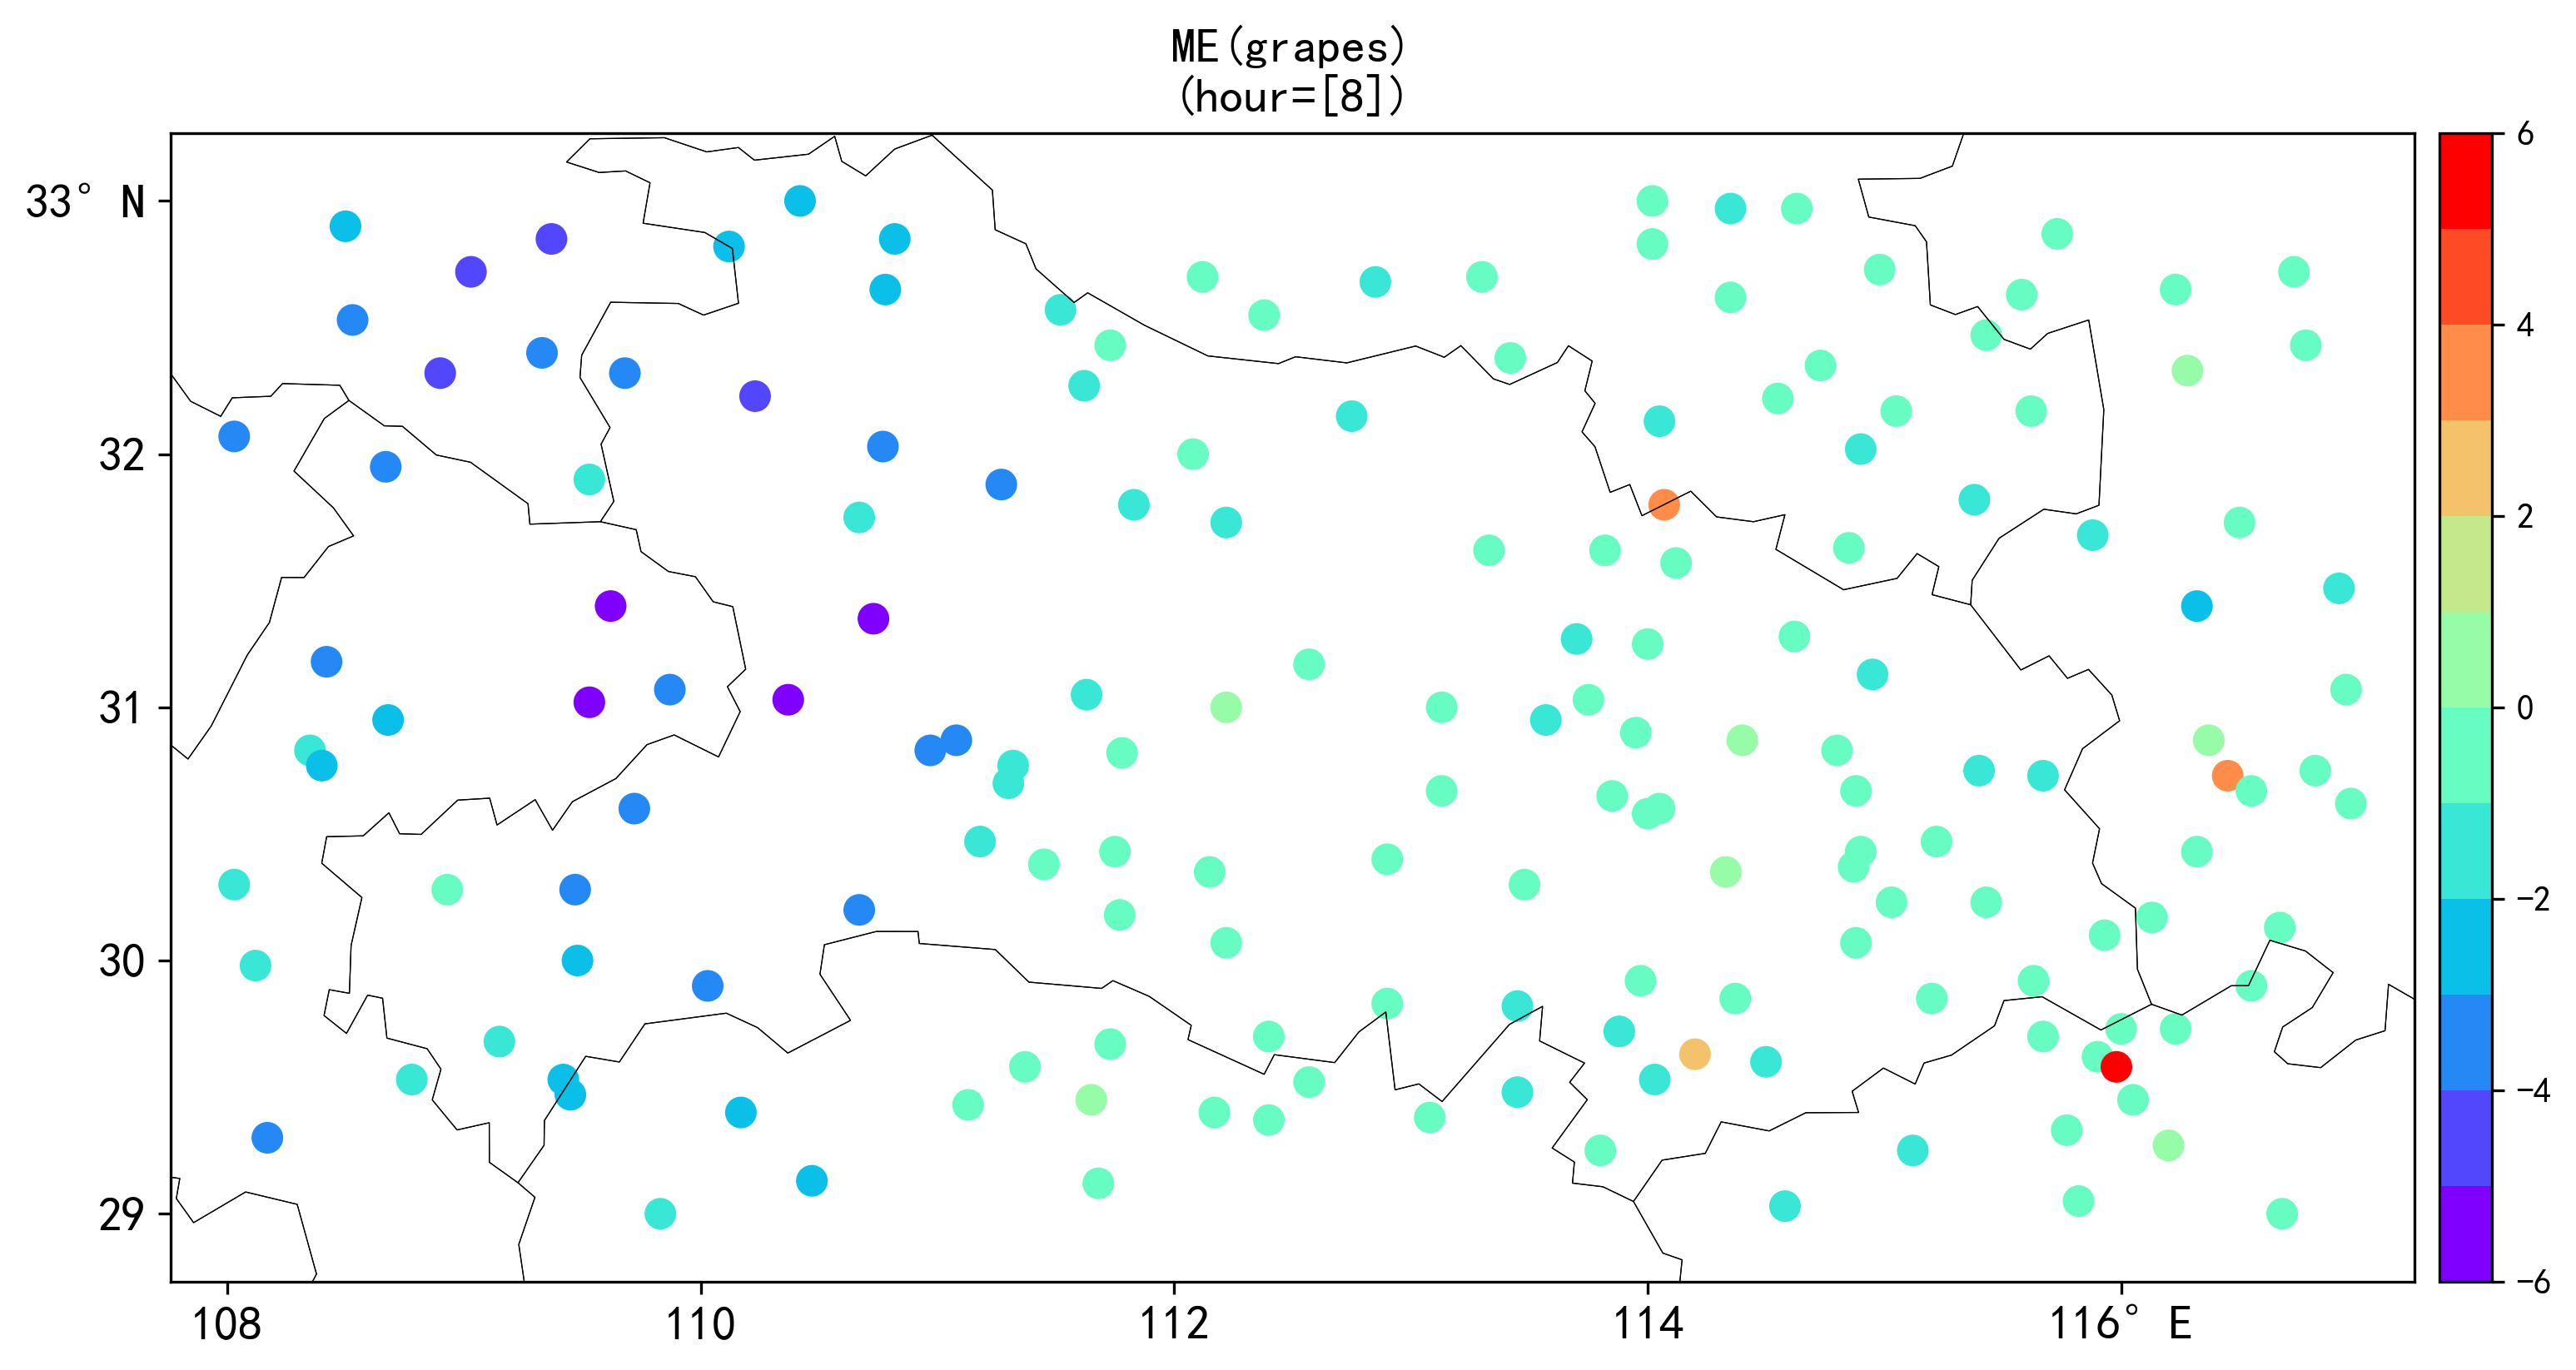

取值最小的1个站点：
id:57359   lon:110.73  lat:31.35 value:-5.922942


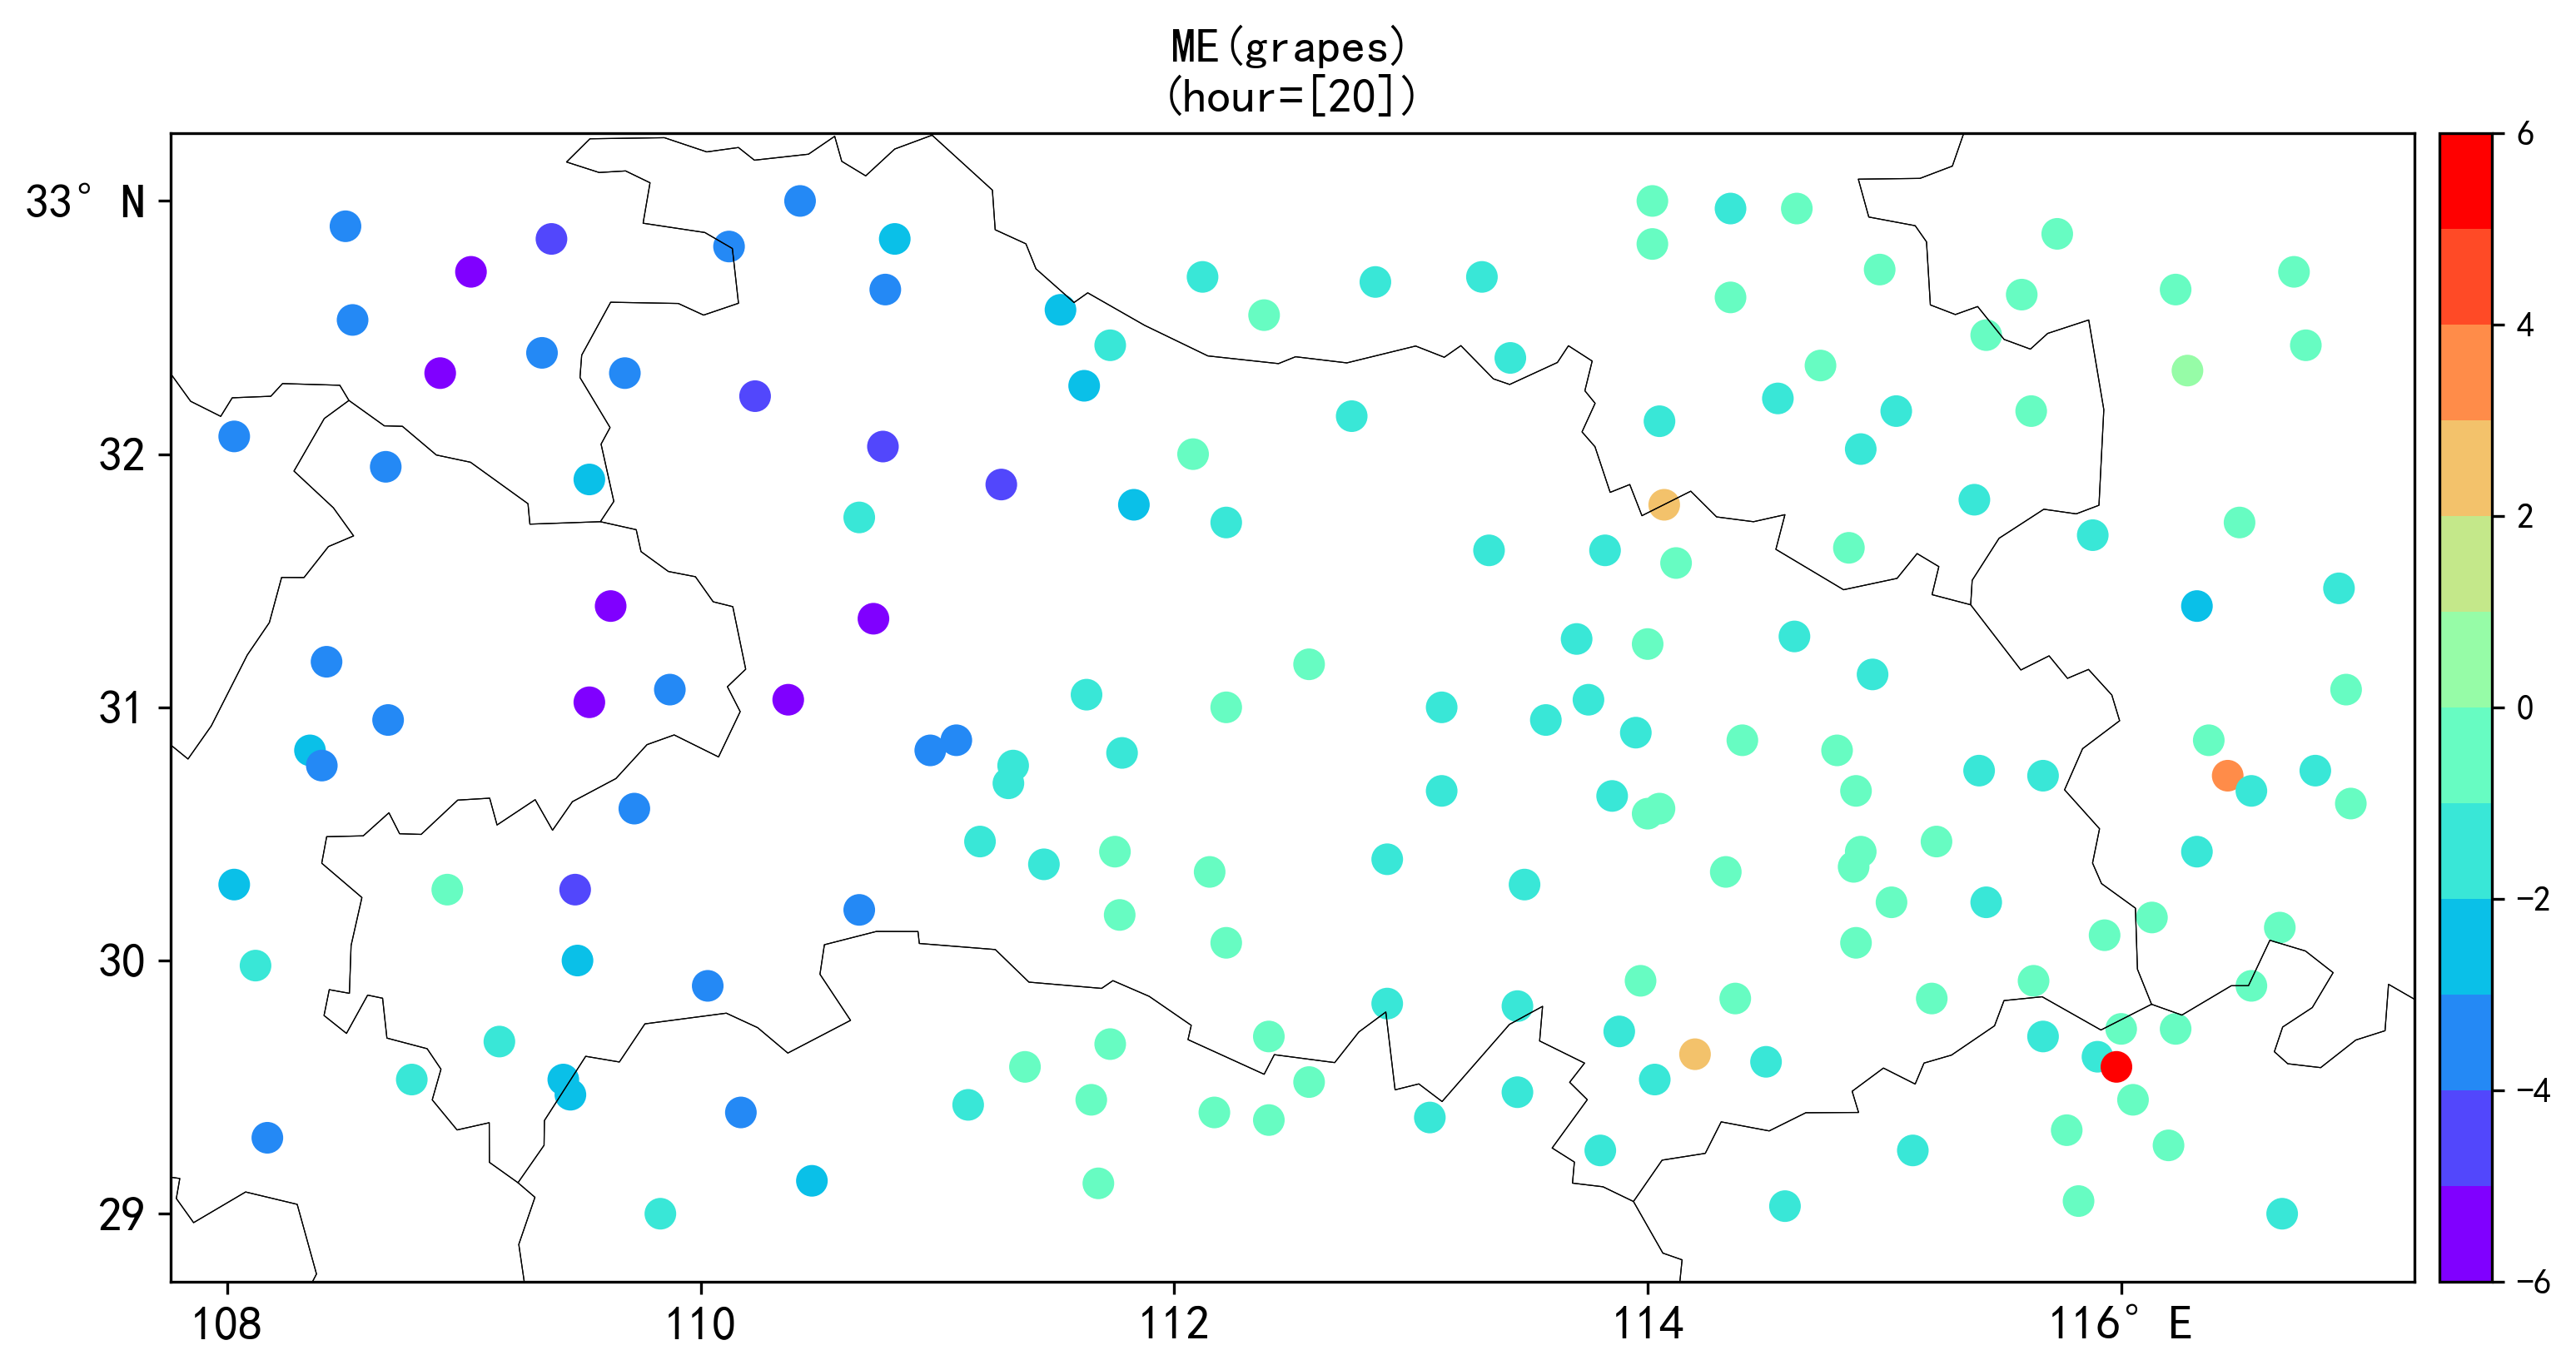

取值最小的1个站点：
id:57359   lon:110.73  lat:31.35 value:-5.8776984


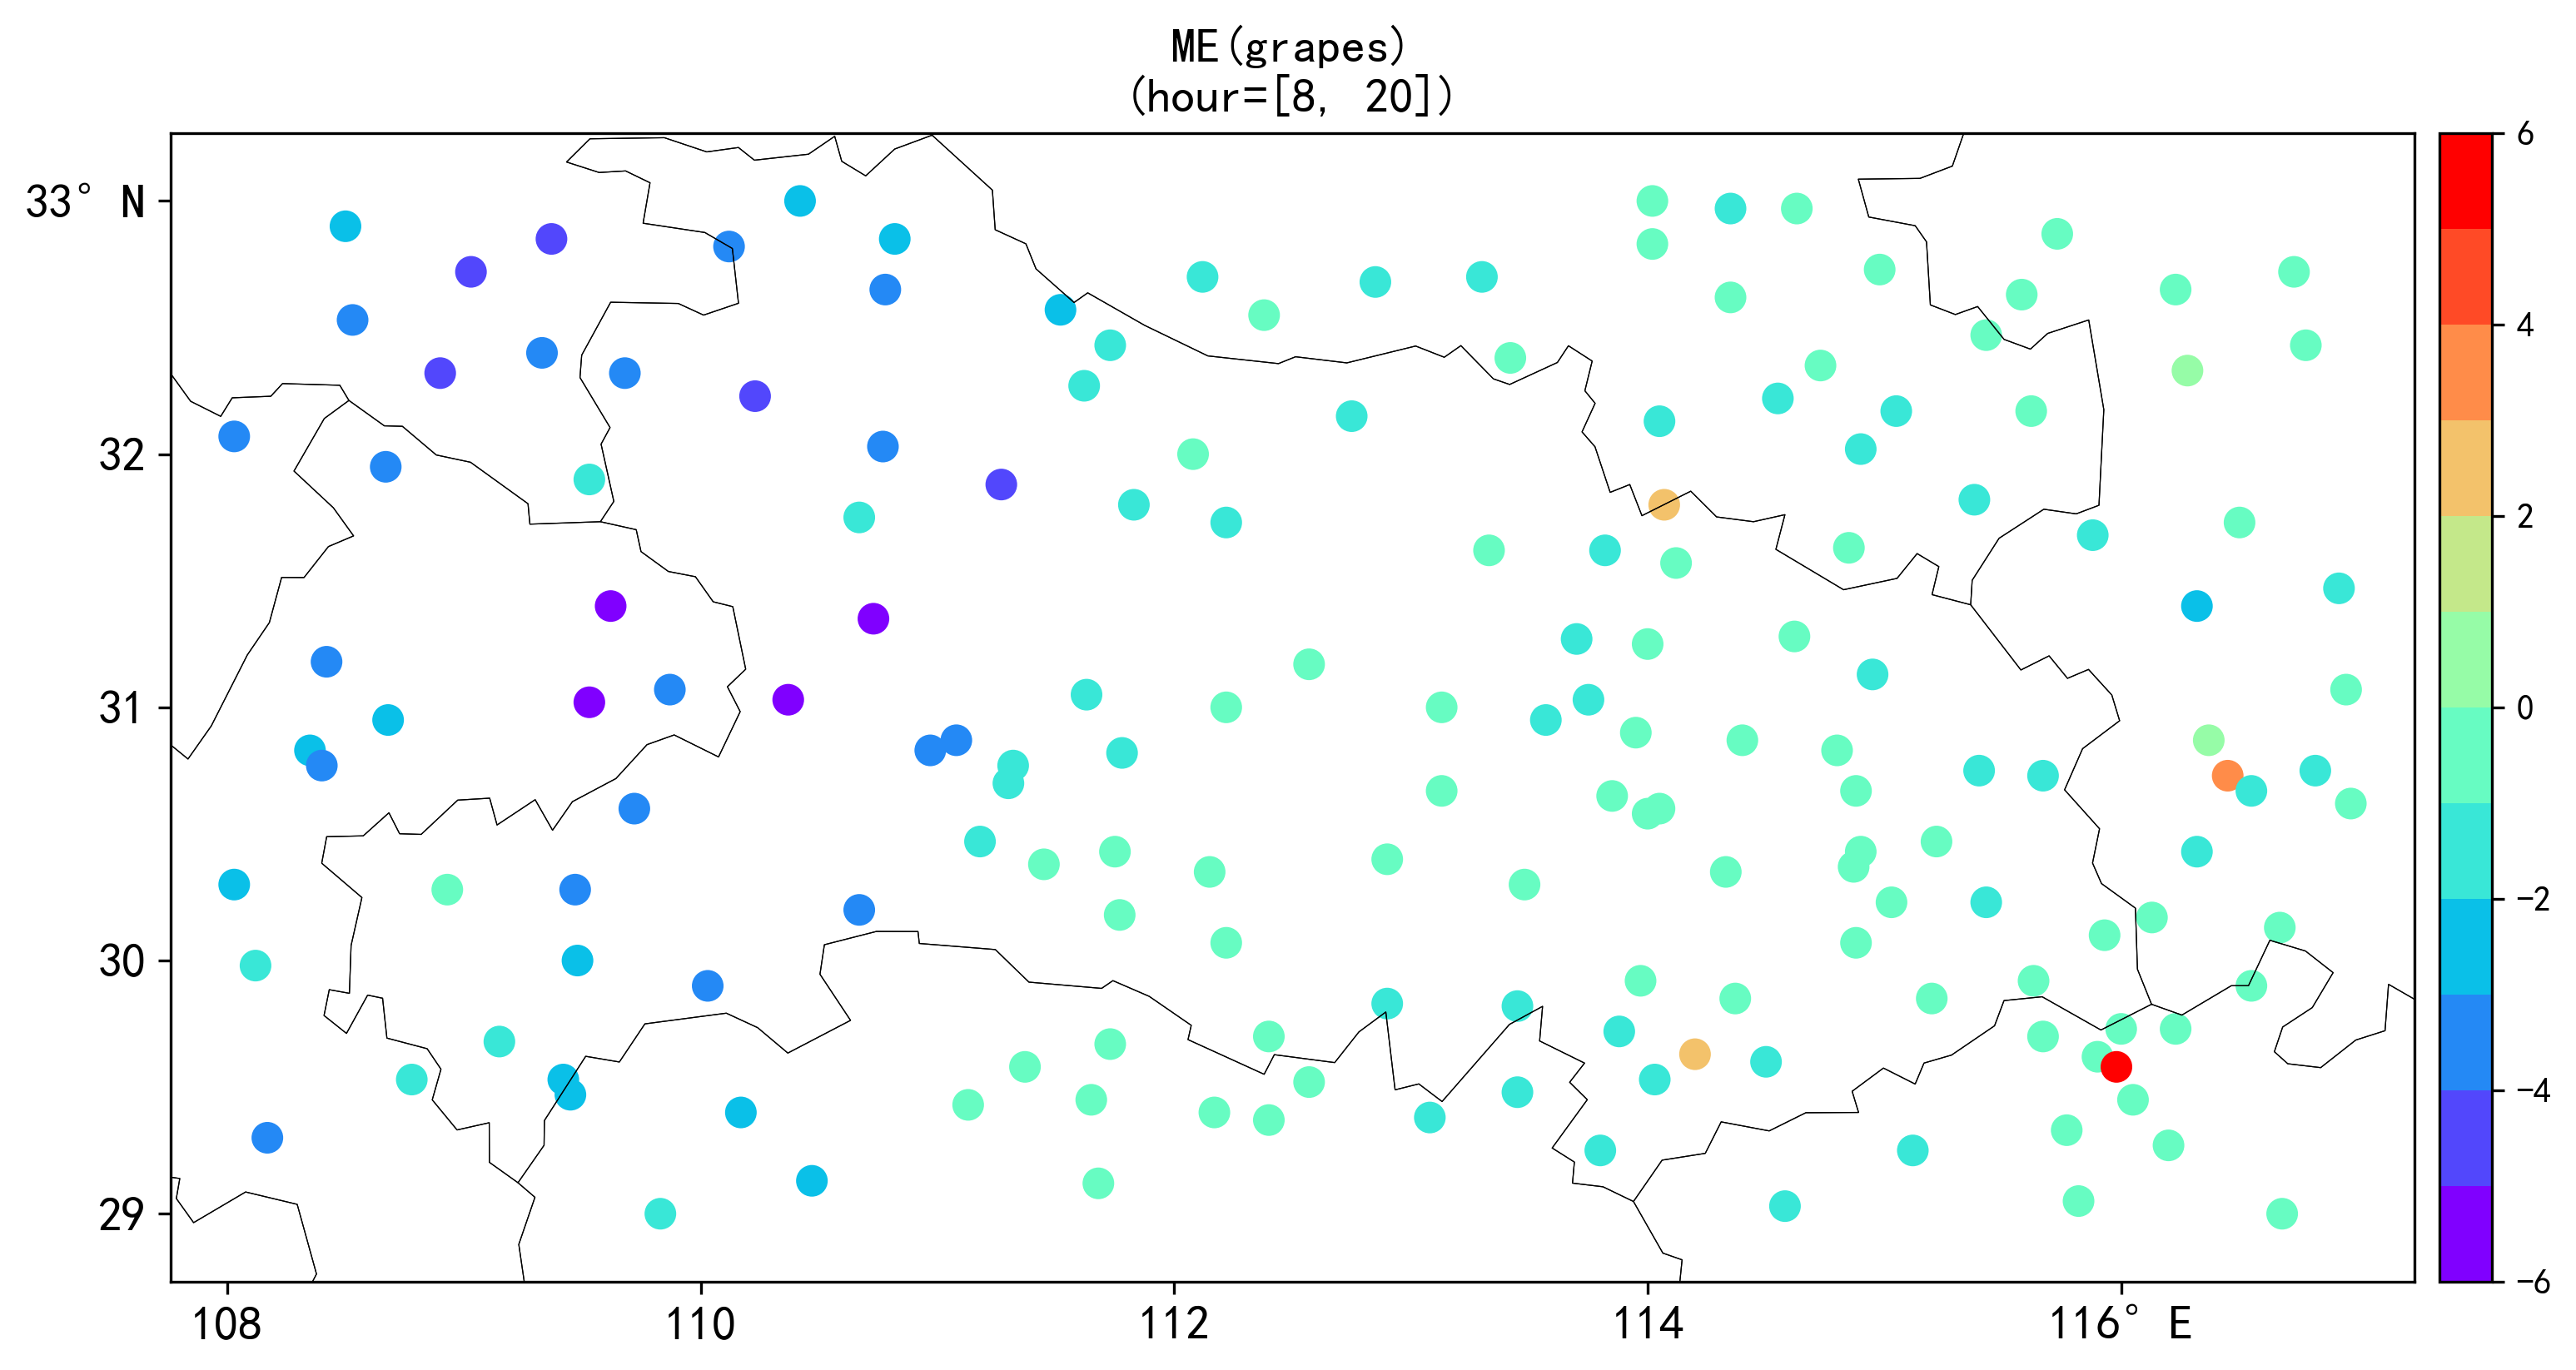

In [80]:
result = mpd.score_id(sta_all,mem.me,s = {"member":["ob","grapes"]},g = "hour",gll= [8,20,[8,20]],plot ="scatter",print_min = 1)  
#增加了gll参数，将数据分成3组，分别包括08时起报的、20时起报的、08或20时起报的（即所有） 样本

In [82]:
result = mpd.score_id(sta_all,mem.me,s = {"member":["ob","grapes"]},g = "hour",gll= [8,20,[8,20]],plot ="scatter",
                      save_dir = r"H:\test_data\output\mpd\program\score_id")  
#将结果输出至save_dir目录，程序会自动创建相应的文件夹

图片输出至H:\test_data\output\mpd\program\score_id/ME(grapes)(hour=[8]).png
图片输出至H:\test_data\output\mpd\program\score_id/ME(grapes)(hour=[20]).png
图片输出至H:\test_data\output\mpd\program\score_id/ME(grapes)(hour=[8, 20]).png


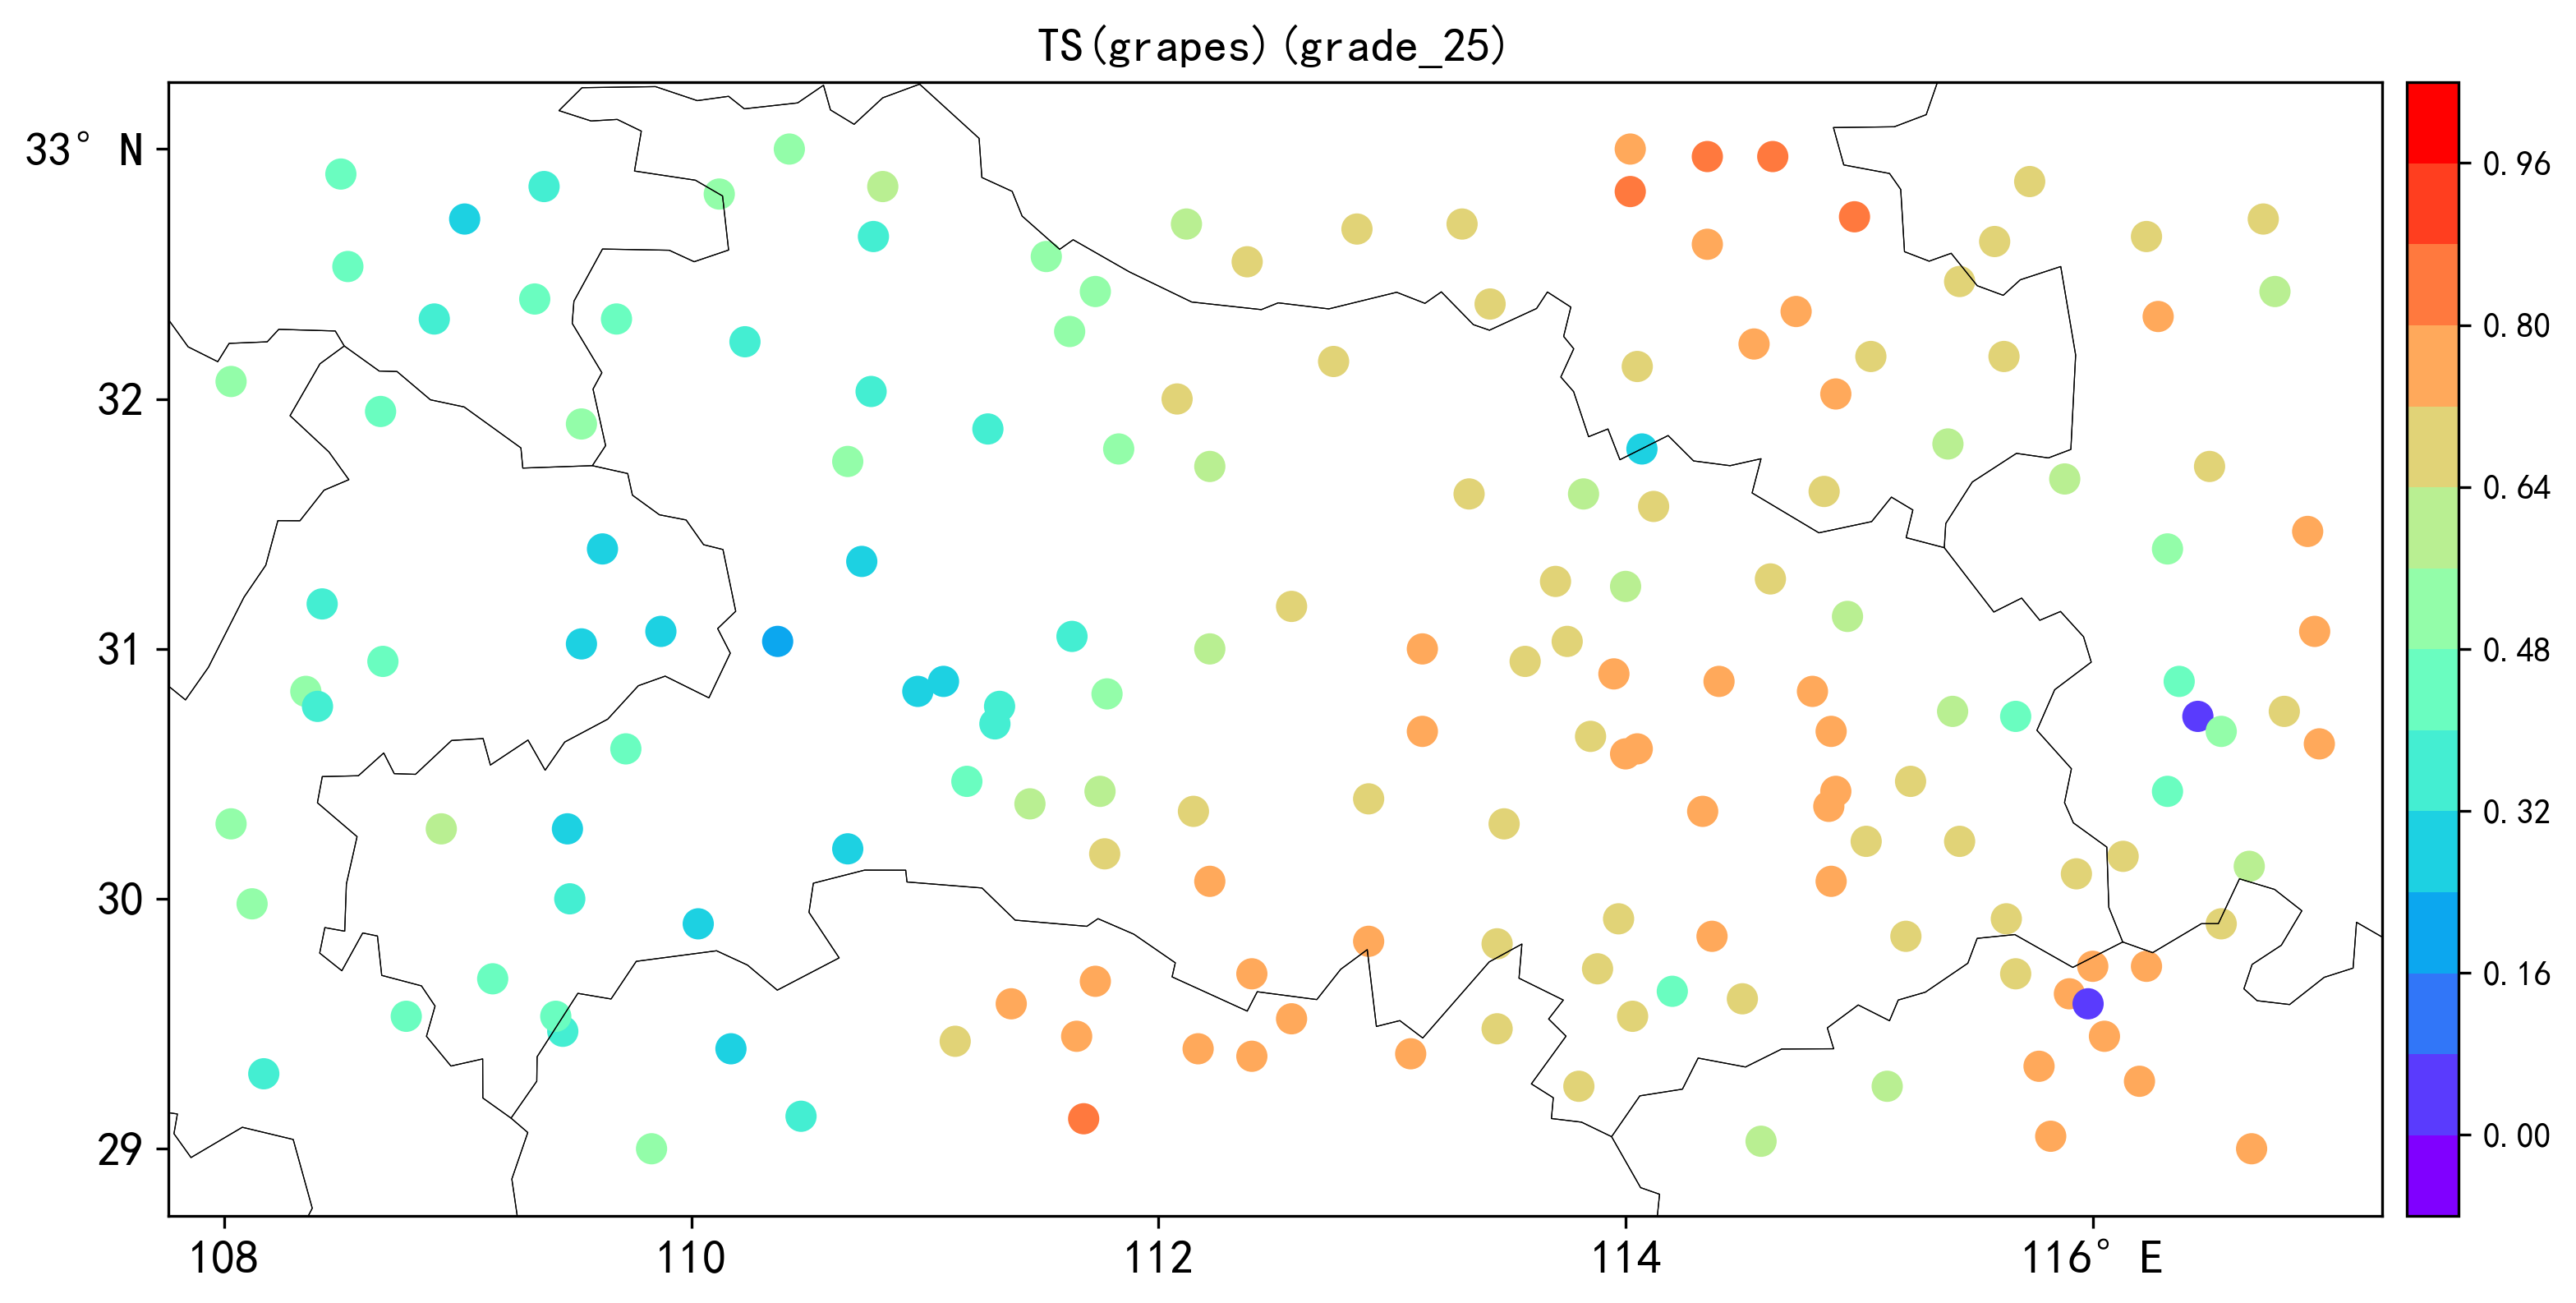

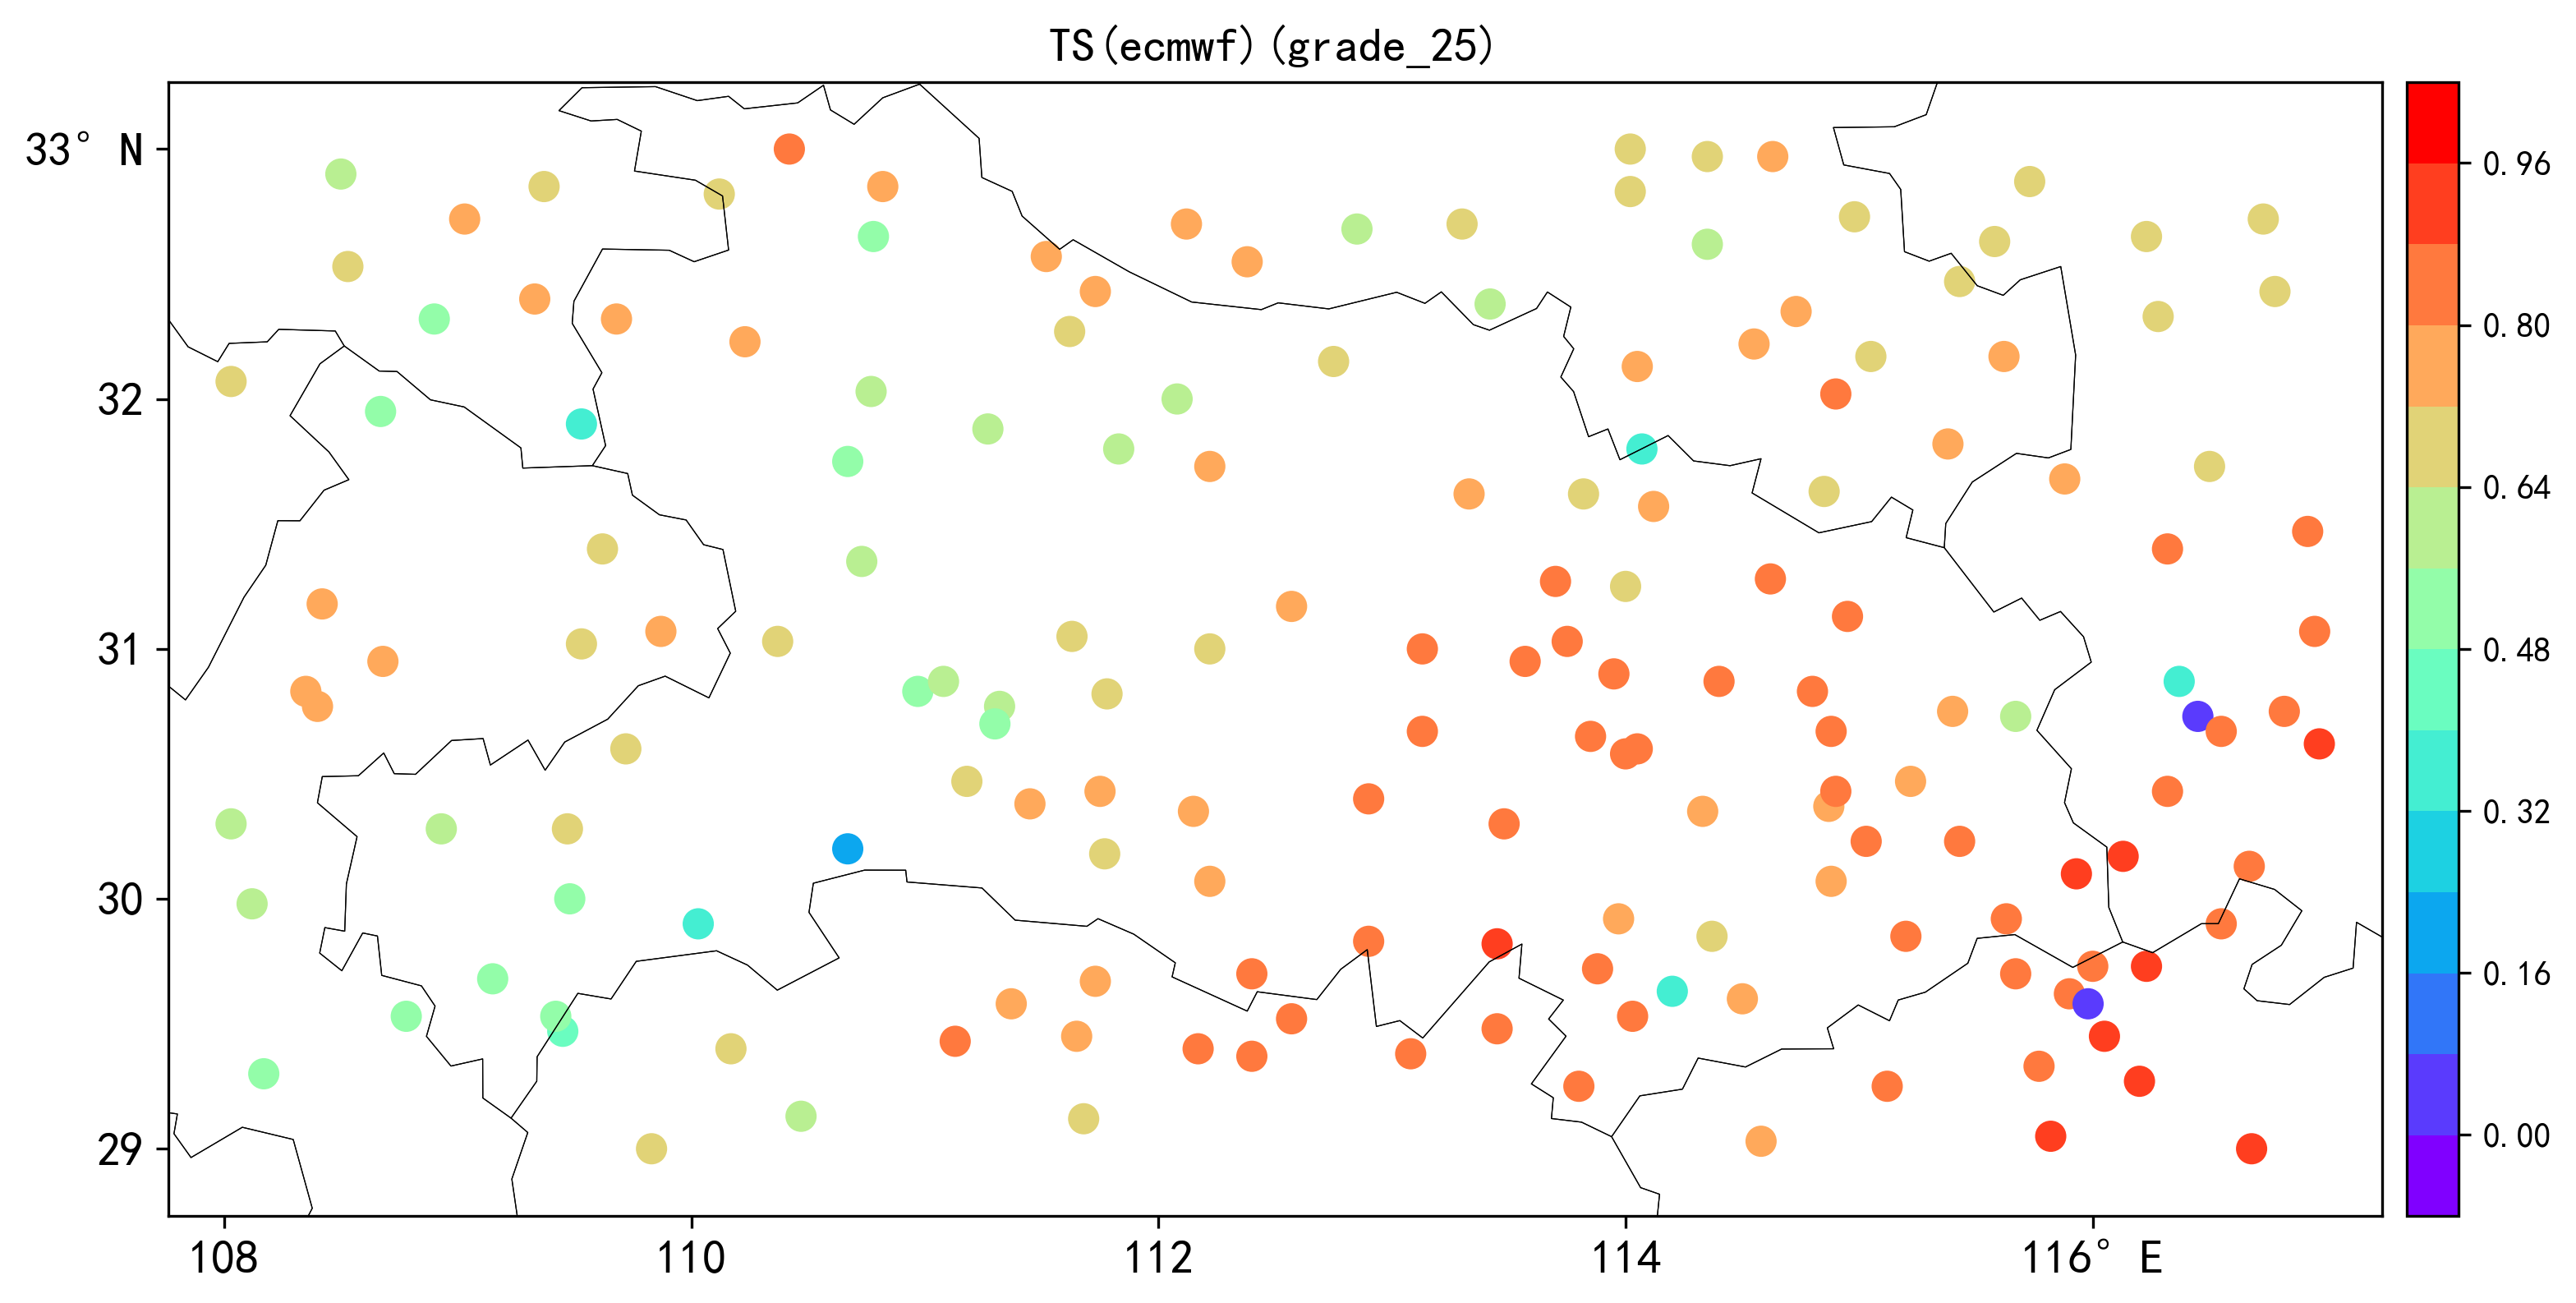

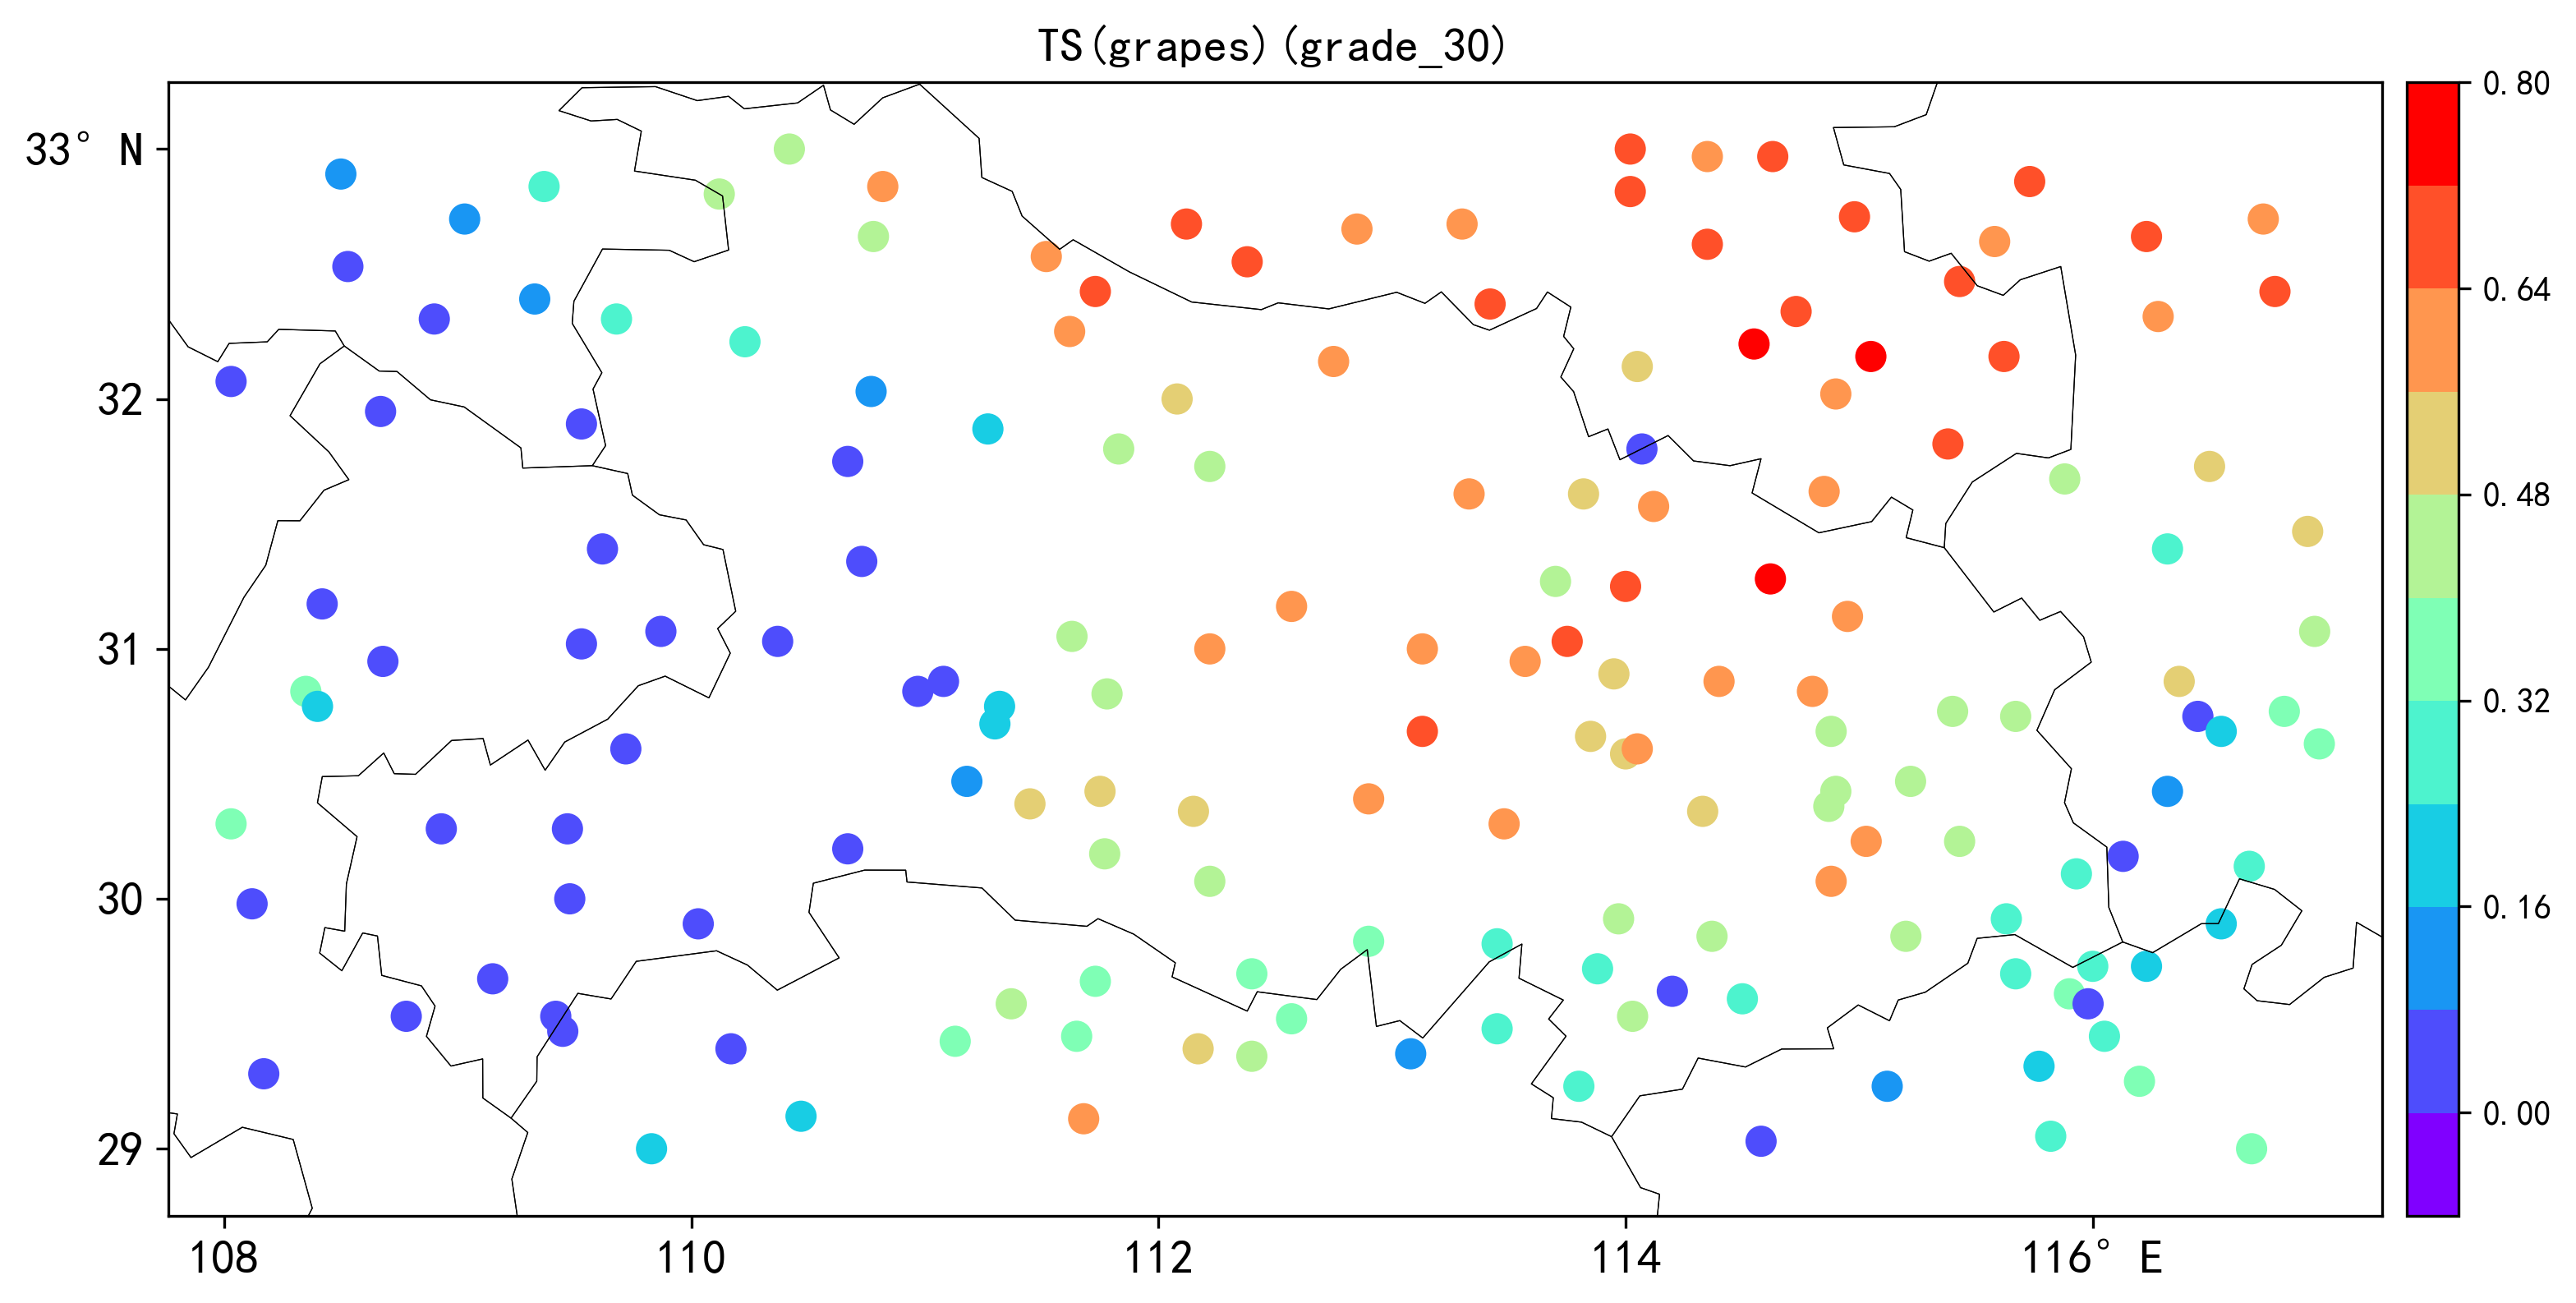

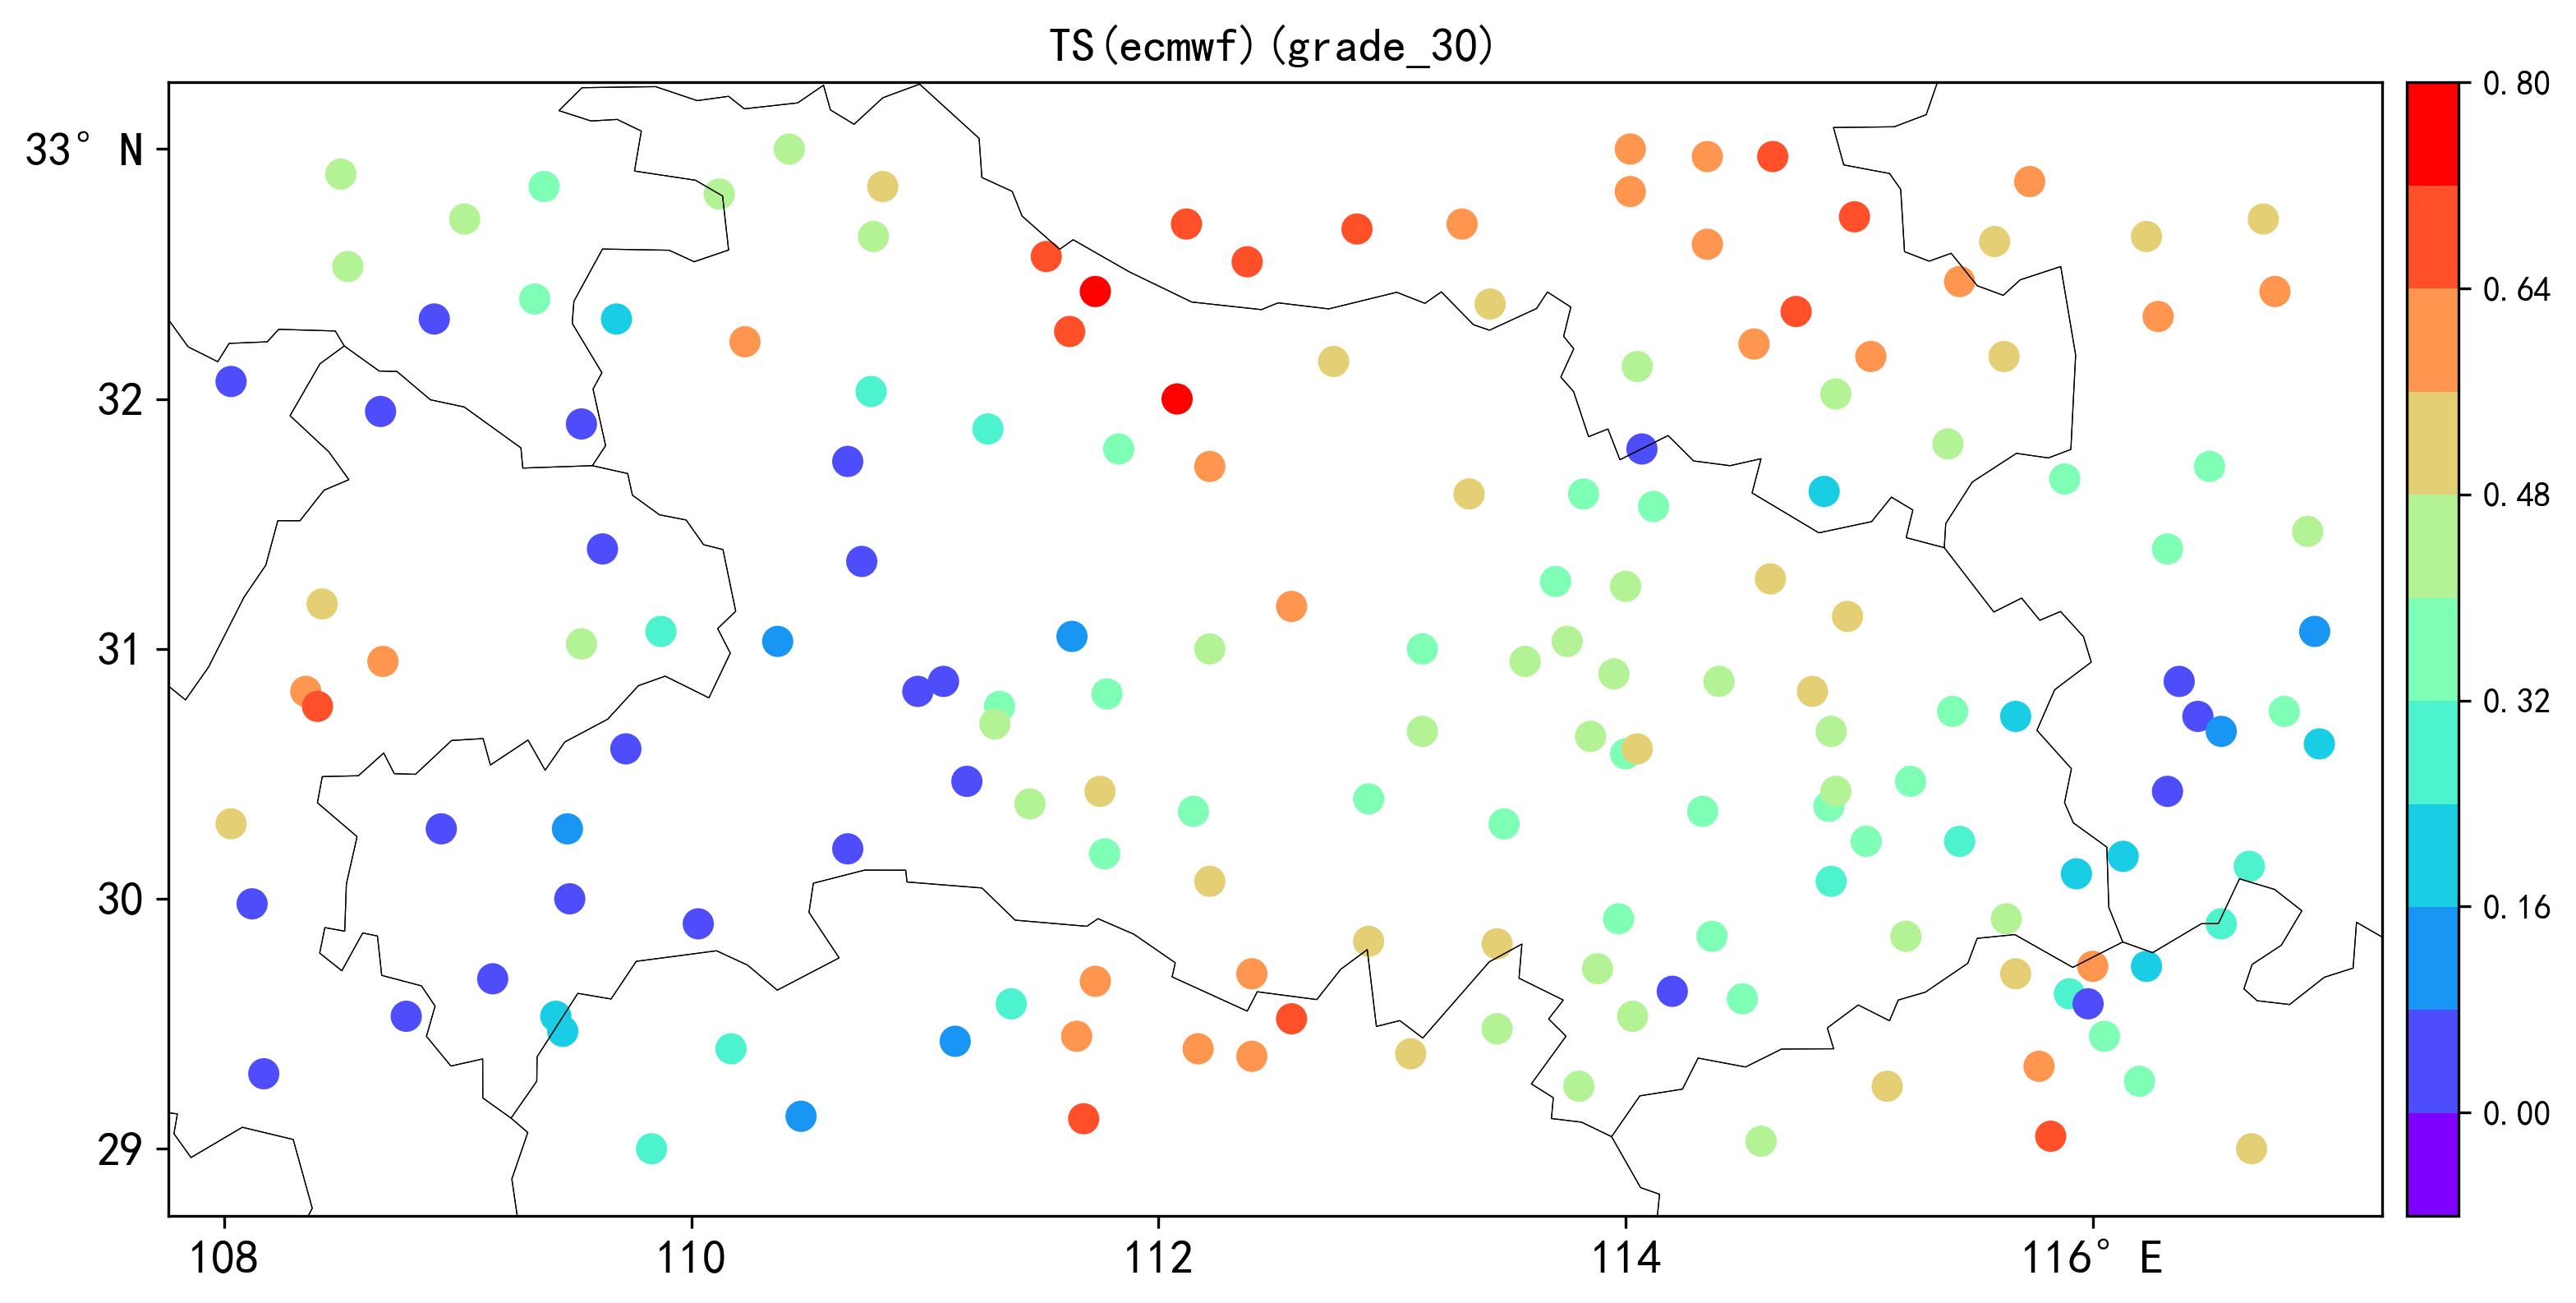

In [91]:
result = mpd.score_id(sta_all,mem.ts,plot ="scatter",grade_list = [25,30])  
#将检验指标切换成mem.ts，mem.ts有时需要等级参数，这个参数可以直接加载score_id函数里如上所示
#本示例中grade_list = [25,30]表示对sta_all中的样本采用两种等级阈值对预报进行检验
#result[0]中是包含两种等级检验结果的列表。

In [90]:
result = mpd.score_id(sta_all,mem.ts,g = "hour",grade_list = [25,30])  
#如果既有分组，又有多种等级
print(result) #result[0]中是包含双层的列表。内层是不同等级，外层是不同分组

([[     level                time  dtime     id     lon    lat    grapes  \
0      0.0 2020-06-29 08:00:00      3  57197  114.35  32.97  0.841584   
1      0.0 2020-06-29 08:00:00      3  57231  108.53  32.53  0.453333   
2      0.0 2020-06-29 08:00:00      3  57233  108.50  32.90  0.463768   
3      0.0 2020-06-29 08:00:00      3  57237  108.03  32.07  0.529412   
4      0.0 2020-06-29 08:00:00      3  57242  109.37  32.85  0.351351   
..     ...                 ...    ...    ...     ...    ...       ...   
164    0.0 2020-06-29 08:00:00      3  58510  116.23  29.73  0.718121   
165    0.0 2020-06-29 08:00:00      3  58512  116.55  29.90  0.666667   
166    0.0 2020-06-29 08:00:00      3  58514  116.05  29.45  0.732484   
167    0.0 2020-06-29 08:00:00      3  58517  116.20  29.27  0.734177   
168    0.0 2020-06-29 08:00:00      3  58519  116.68  29.00  0.793750   

        ecmwf  
0    0.669355  
1    0.707317  
2    0.645570  
3    0.632353  
4    0.639640  
..        ...  
164  0.8

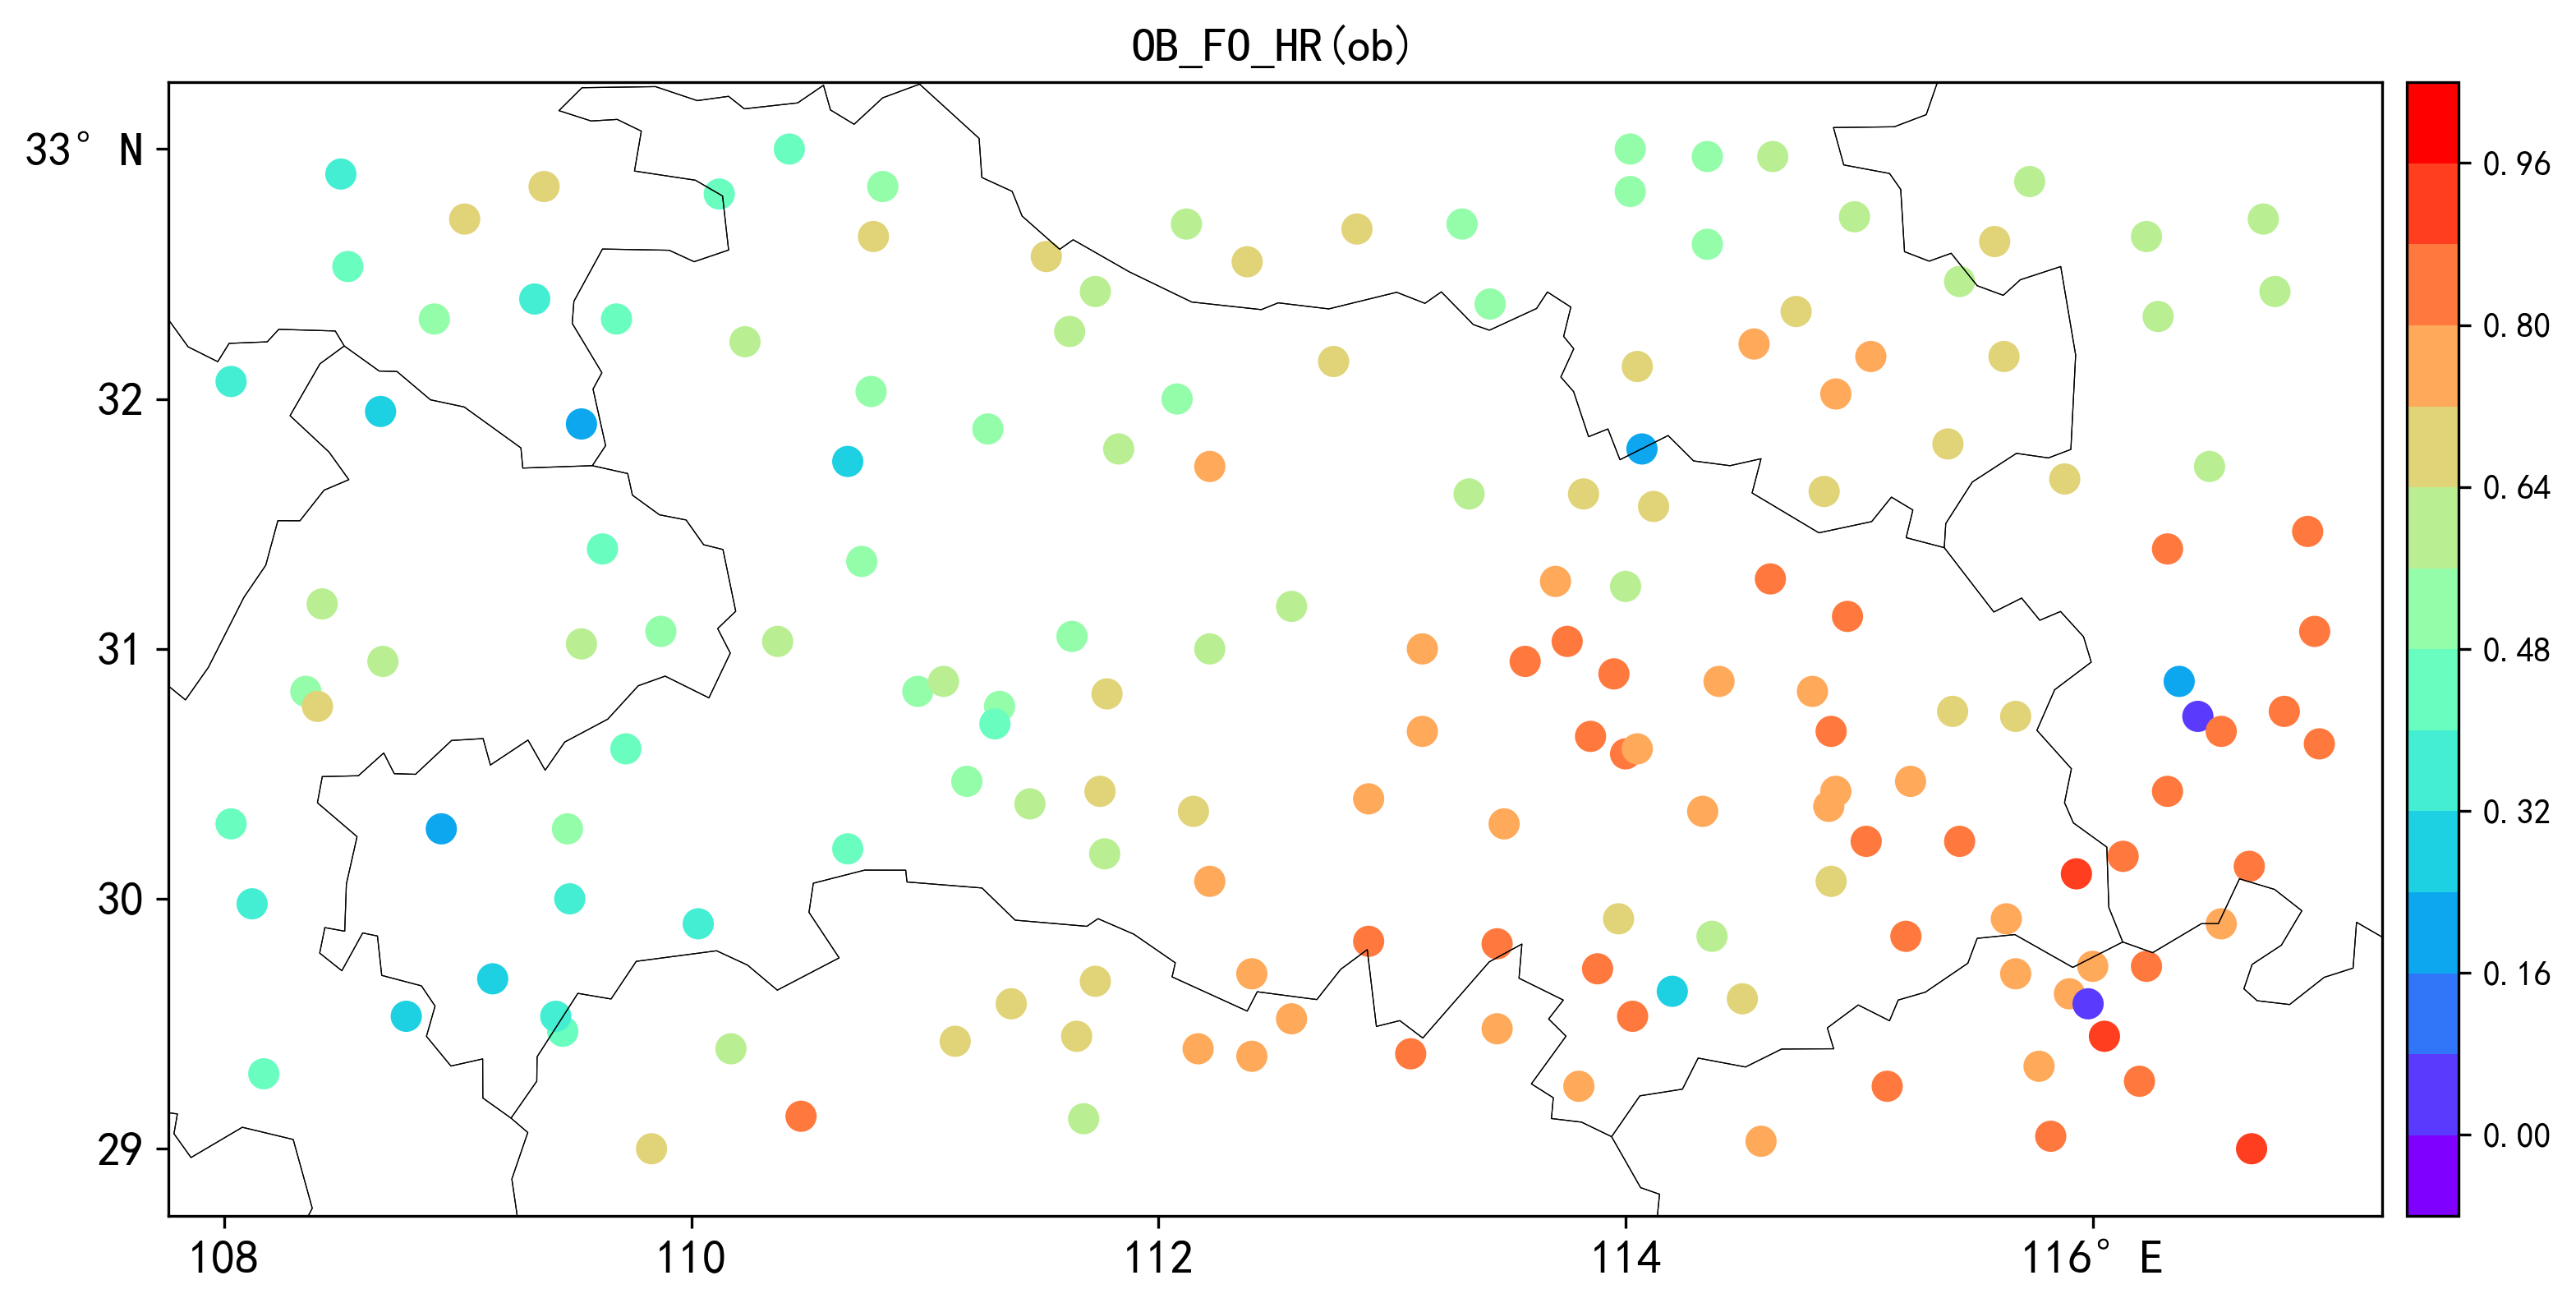

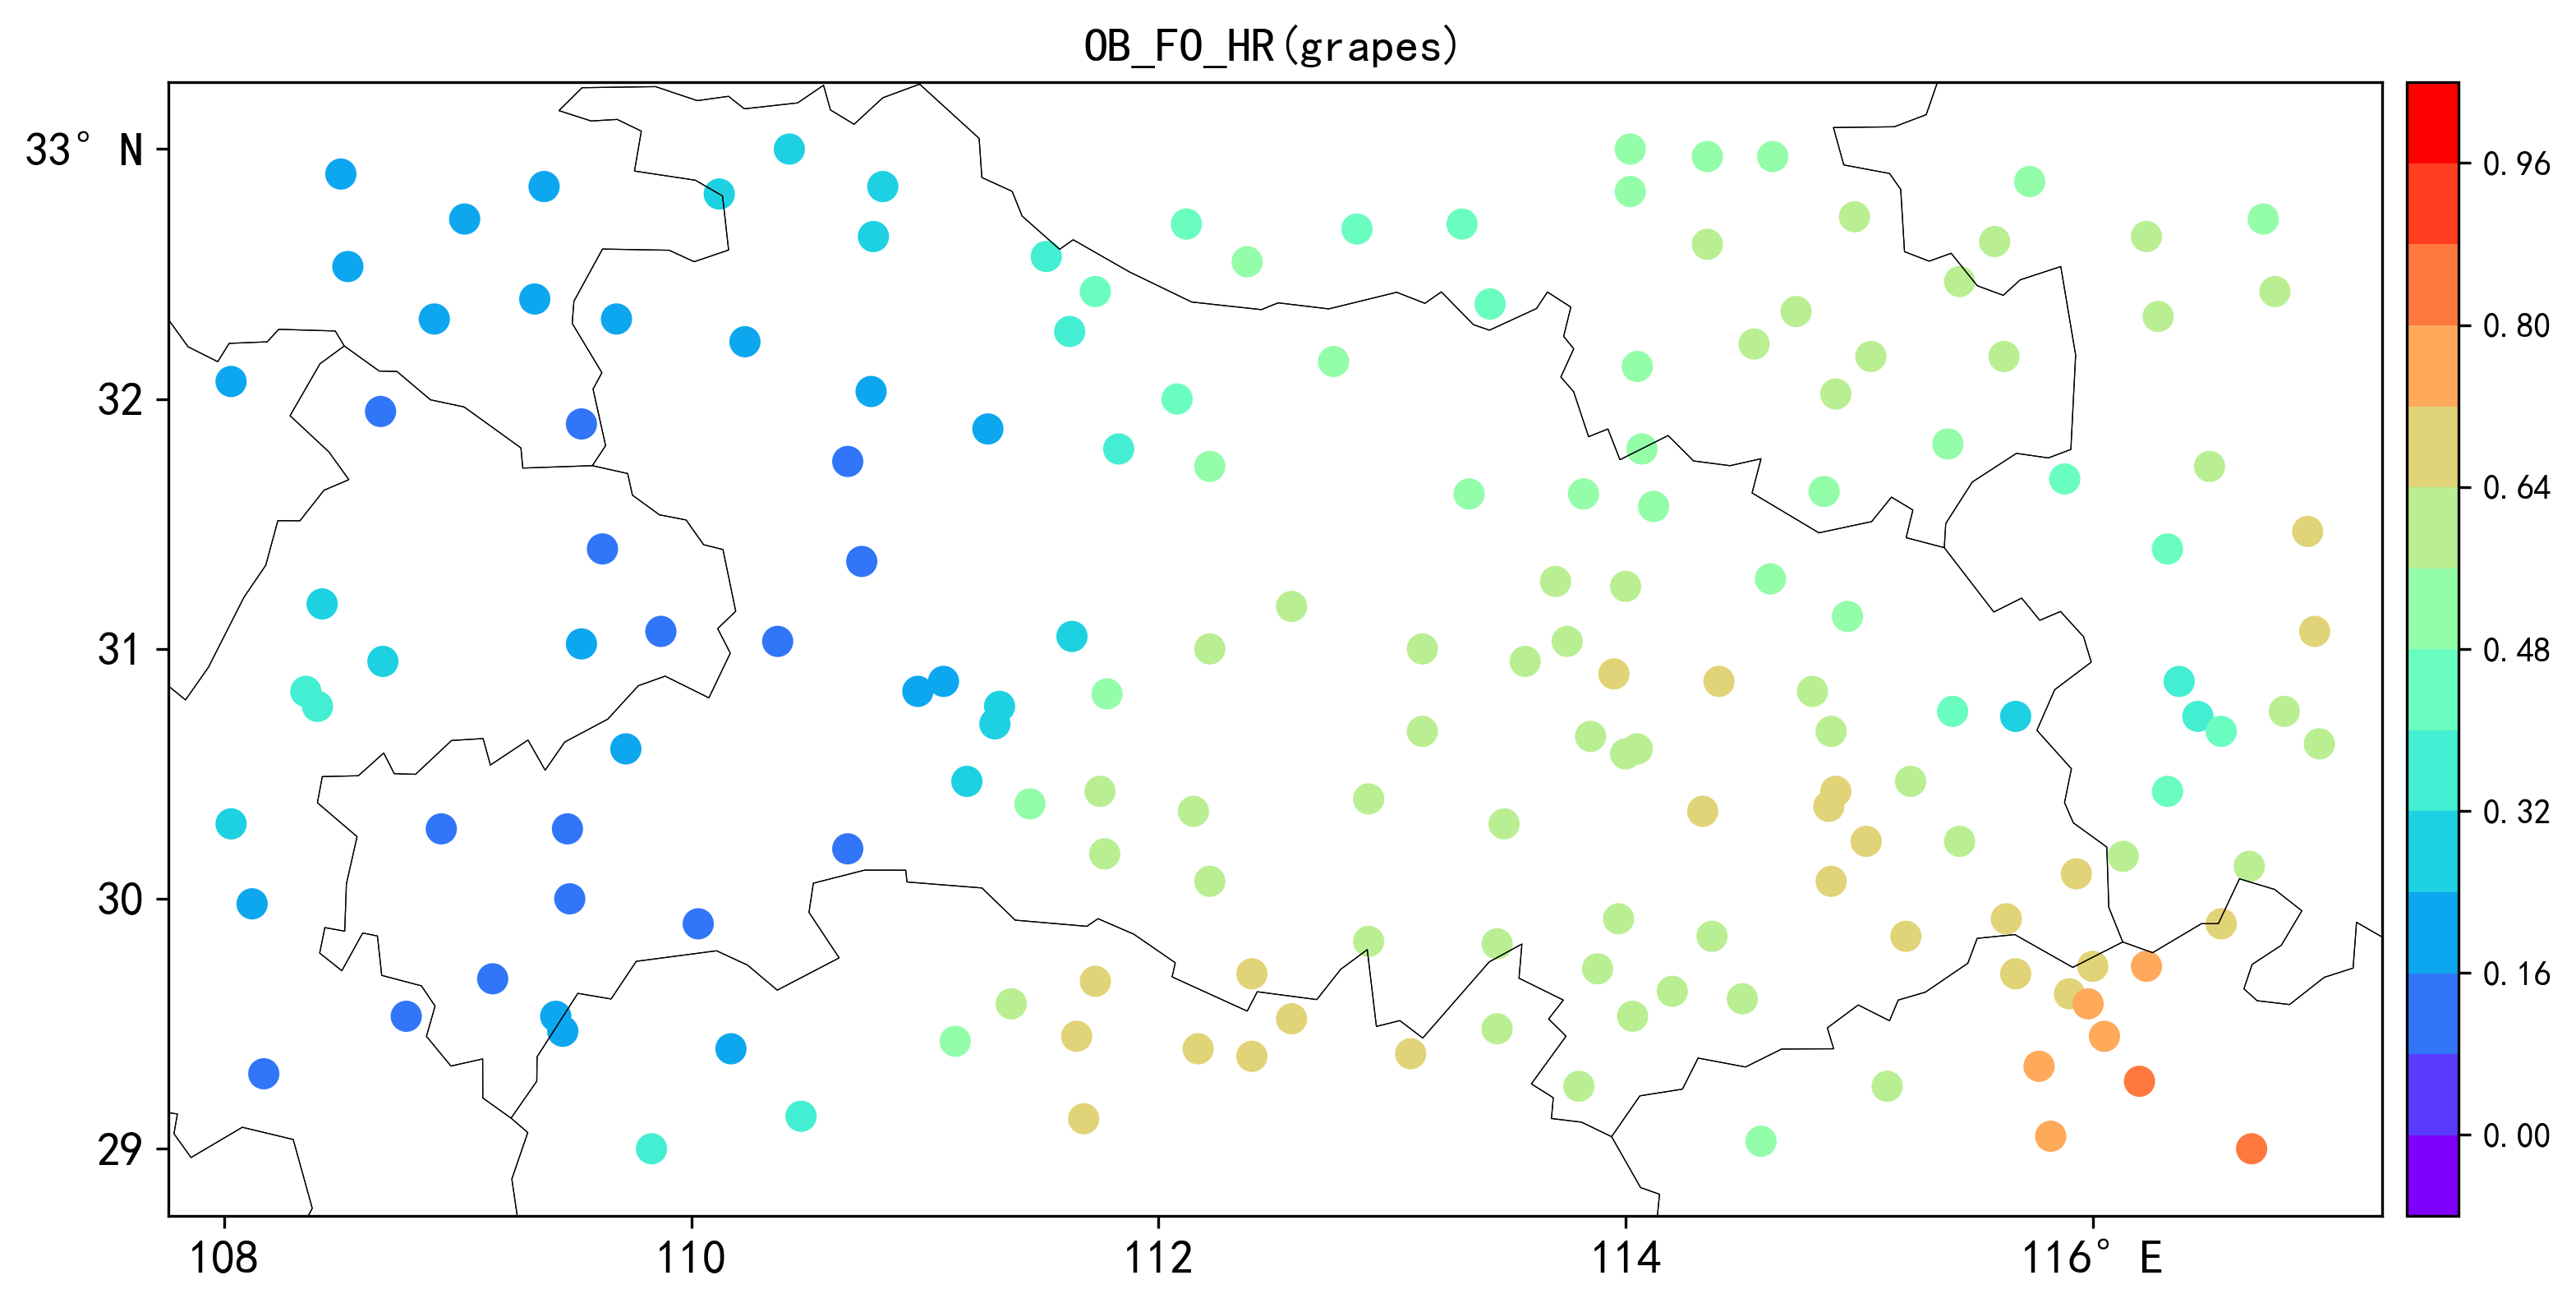

In [95]:
result = mpd.score_id(sta_all,mem.ob_fo_hr,s = {"member":["ob","grapes"]},grade_list = [25],plot = "scatter")  
#将统计指标切换成ob_fo_hr 并选择参数 grade_list=[25]，意思是分别统计观测和预报样本中取值大于25的比例。
#该函数的功能用于对比观测和预报的频率分别情况。

从上面的示例中可以看出，基于本程序库提供的函数，实现了数据收集、数据提取和检验计算代码的解耦，使得我们检验分析的过程变得十分灵活，同时解耦也为各部分的进一步模块化提供了基础。值得注意的是采用上述方法进行检验时，会出现如下几个方面的问题：  
    1，将数据全部收集到sta_all变量当中,需要内存足够大  
    2，当sta_all太大时，从中做数据选取，速度会变慢   
    3，不能计算和存储检验中间检验量，也因此不能开展并行计算  
    4，目前只能支持按一个纬度进行简单的分组，不能按多个维度同时分组，例如将样本同时按月份和时效进行分组的功能无法提供。 
上述问题可以在更上一层（perspact）中提供解决方案  